# Clustering Metrics Evaluation for Semantic Embeddings

This notebook provides:
1. **Part 1** — A reference guide for 10 clustering evaluation metrics (6 internal + 4 external)
2. **Part 2** — An empirical comparison showing how each metric behaves across 3 synthetic datasets with increasing cluster overlap

### Metrics Covered

**Internal** (no ground truth): Silhouette Coefficient, Dunn Index, Davies-Bouldin, Calinski-Harabasz, SSE, NCI  
**External** (ground truth required): Rand Index, Van Dongen, Variation of Information, Omega Indicator

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import (
    adjusted_rand_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    pairwise_distances,
    rand_score,
    silhouette_score,
)
from sklearn.metrics.cluster import contingency_matrix

np.random.seed(42)
plt.rcParams.update({"figure.dpi": 100, "font.size": 10})

---
## Part 1 — Metrics Reference Guide

### Internal Metrics (no ground truth needed)

| Metric | Logic & Data Focus | Range / Direction | Pros | Cons | Assumptions & Limitations |
|--------|-------------------|-------------------|------|------|---------------------------|
| **Silhouette Coefficient (SC)** | Measures internal cohesion vs. external separation for each point. `SC = (b - a) / max(a, b)` where `a` = mean intra-cluster dist, `b` = mean nearest-cluster dist. | [-1, 1] / Higher = better | Top performer for detecting optimal cluster count. Intuitive per-point interpretation. | Computationally heavy at O(n^2). | Assumes distance reliably represents similarity. Not suitable for very large datasets without sampling. |
| **Dunn Index (DI)** | Ratio of minimum inter-cluster distance to maximum intra-cluster diameter. | [0, inf) / Higher = better | Simple, intuitive logic. Captures both separation and compactness in one ratio. | Extremely sensitive to noise and outliers (single outlier can destroy the score). O(n^2). | Assumes even density and distribution across clusters. |
| **Davies-Bouldin (DB)** | Average ratio of within-cluster scatter to between-cluster separation, across all cluster pairs. | [0, inf) / Lower = better | Fast to compute — O(n). Easy to interpret. | Can be biased by the number of clusters. Tends to favor convex clusters. | Assumes convex, spherical (isotropic) clusters. |
| **Calinski-Harabasz (CH)** | Ratio of between-cluster variance to within-cluster variance, adjusted for degrees of freedom. | [0, inf) / Higher = better | Very efficient; adjusts for dataset size and cluster count. | Biased toward spherical shapes and similar-sized clusters. | Assumes spherical, identically-sized clusters. |
| **SSE (Sum of Squared Error)** | Total squared Euclidean distance of all points to their assigned centroids. K-means objective function. | [0, inf) / Lower = better | Standard optimization target for K-means. Always decreases with more clusters. | Highly sensitive to noise and outliers. Not comparable across different k values without normalization. | Only detects compact, well-separated hyperspherical clusters. |
| **NCI (New Correlation Index)** | Pearson correlation between each point's distance to its centroid and the centroid's distance to the global mean. | [-1, 1] / Higher = better | Provides multiple local peaks for sub-optimal cluster options, useful for exploring alternative k values. | Not effective for special shapes like rings or spirals. | Standard distance-based geometry; assumes convex cluster structure. |

### External Metrics (ground truth required)

| Metric | Logic & Data Focus | Range / Direction | Pros | Cons | Assumptions & Limitations |
|--------|-------------------|-------------------|------|------|---------------------------|
| **Rand Index (RAND)** | Measures pairwise agreement: fraction of point-pairs that are either in the same cluster in both partitions or in different clusters in both. Adjusted variant (ARI) corrects for chance. | Raw: [0, 1], ARI: [-1, 1] / Higher = better | Most robust indicator of partition match. ARI corrects for chance agreement. | Raw RI has high baseline for large k. ARI can be negative. | Permutation-invariant. Requires ground truth labels. |
| **Van Dongen (VD)** | Evaluates clustering match via a contingency table cost function: `1 - (row_max_sum + col_max_sum) / (2n)`. | [0, 1] / Lower = better | Captures structural match via representative-based assignment. | Less commonly used; harder to interpret than RAND. | Requires ground truth. Not corrected for chance. |
| **Variation of Information (VI)** | Information-theoretic distance: `VI = H(U|V) + H(V|U)` — sum of conditional entropies between two partitions. | [0, log(n)] / Lower = better | Principled; true metric in the mathematical sense (satisfies triangle inequality). | Unbounded range makes cross-dataset comparison difficult without normalization. | Requires ground truth. Sensitive to cluster count mismatch. |
| **Omega (Ω) Indicator** | Composite complexity measure: `Ω = mean([1-ARI], VD, VI_normalized)`. Combines distance-form of all three external metrics. | [0, 1] / Lower = better | Single summary score for dataset clustering complexity. | Averages heterogeneous quantities; may mask individual metric behavior. | Requires all three component metrics. VI must be normalized to [0,1] first. |

In [2]:
# Metrics reference as a DataFrame for programmatic use
metrics_ref = pd.DataFrame(
    {
        "Metric": [
            "Silhouette (SC)",
            "Dunn Index (DI)",
            "Davies-Bouldin (DB)",
            "Calinski-Harabasz (CH)",
            "SSE",
            "NCI",
            "Rand Index (ARI)",
            "Van Dongen (VD)",
            "Variation of Info (VI)",
            "Omega (\u03a9)",
        ],
        "Type": ["Internal"] * 6 + ["External"] * 4,
        "Direction": [
            "Higher=Better",
            "Higher=Better",
            "Lower=Better",
            "Higher=Better",
            "Lower=Better",
            "Higher=Better",
            "Higher=Better",
            "Lower=Better",
            "Lower=Better",
            "Lower=Better",
        ],
        "Complexity": [
            "O(n\u00b2)",
            "O(n\u00b2)",
            "O(n)",
            "O(n)",
            "O(n)",
            "O(n)",
            "O(n\u00b2)",
            "O(n)",
            "O(n)",
            "O(n)",
        ],
        "Key Assumption": [
            "Distance = similarity",
            "Even density",
            "Spherical clusters",
            "Spherical, equal-size",
            "Hyperspherical",
            "Convex geometry",
            "Permutation-invariant",
            "Ground truth available",
            "Ground truth available",
            "All 3 externals computed",
        ],
    }
)
display(metrics_ref)

Metric      Type      Direction Complexity  \
0         Silhouette (SC)  Internal  Higher=Better      O(n²)   
1         Dunn Index (DI)  Internal  Higher=Better      O(n²)   
2     Davies-Bouldin (DB)  Internal   Lower=Better       O(n)   
3  Calinski-Harabasz (CH)  Internal  Higher=Better       O(n)   
4                     SSE  Internal   Lower=Better       O(n)   
5                     NCI  Internal  Higher=Better       O(n)   
6        Rand Index (ARI)  External  Higher=Better      O(n²)   
7         Van Dongen (VD)  External   Lower=Better       O(n)   
8  Variation of Info (VI)  External   Lower=Better       O(n)   
9               Omega (Ω)  External   Lower=Better       O(n)   

             Key Assumption  
0     Distance = similarity  
1              Even density  
2        Spherical clusters  
3     Spherical, equal-size  
4            Hyperspherical  
5           Convex geometry  
6     Permutation-invariant  
7    Ground truth available  
8    Ground truth available  
9  All 3 externals computed

In [3]:
# ============================================================
# Custom Metric Implementations
# ============================================================


def dunn_index(X, labels):
    """Ratio of min inter-cluster distance to max intra-cluster diameter."""
    dist_matrix = pairwise_distances(X)
    unique_labels = np.unique(labels)

    # Min inter-cluster distance (between any two points in different clusters)
    min_inter = np.inf
    for i, li in enumerate(unique_labels):
        for lj in unique_labels[i + 1 :]:
            mask_i = labels == li
            mask_j = labels == lj
            inter_dists = dist_matrix[np.ix_(mask_i, mask_j)]
            min_inter = min(min_inter, inter_dists.min())

    # Max intra-cluster diameter
    max_intra = 0.0
    for li in unique_labels:
        mask = labels == li
        if mask.sum() > 1:
            intra_dists = dist_matrix[np.ix_(mask, mask)]
            max_intra = max(max_intra, intra_dists.max())

    return min_inter / max_intra if max_intra > 0 else 0.0


def new_correlation_index(X, labels):
    """NCI: Pearson correlation between point-to-centroid distances
    and centroid-to-global-mean distances."""
    unique_labels = np.unique(labels)
    global_mean = X.mean(axis=0)

    point_to_centroid = np.zeros(len(X))
    centroid_to_global = np.zeros(len(X))

    for li in unique_labels:
        mask = labels == li
        centroid = X[mask].mean(axis=0)
        dists = np.linalg.norm(X[mask] - centroid, axis=1)
        point_to_centroid[mask] = dists
        centroid_to_global[mask] = np.linalg.norm(centroid - global_mean)

    # Guard against constant arrays
    if np.std(point_to_centroid) == 0 or np.std(centroid_to_global) == 0:
        return 0.0

    corr, _ = pearsonr(point_to_centroid, centroid_to_global)
    return corr


def van_dongen_criterion(labels_true, labels_pred):
    """VD: 1 - (row_max_sum + col_max_sum) / (2n). Range [0,1], lower = better."""
    cm = contingency_matrix(labels_true, labels_pred)
    n = cm.sum()
    row_max_sum = cm.max(axis=1).sum()
    col_max_sum = cm.max(axis=0).sum()
    return 1.0 - (row_max_sum + col_max_sum) / (2 * n)


def variation_of_information(labels_true, labels_pred, normalized=False):
    """VI = H(U|V) + H(V|U). Lower = better. Optionally normalized to [0,1]."""
    n = len(labels_true)
    cm = contingency_matrix(labels_true, labels_pred)
    joint = cm / n  # joint probability

    p_true = joint.sum(axis=1)  # marginal for true labels
    p_pred = joint.sum(axis=0)  # marginal for predicted labels

    vi = 0.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if joint[i, j] > 0:
                # H(U|V) contribution
                vi -= joint[i, j] * np.log2(joint[i, j] / p_pred[j])
                # H(V|U) contribution
                vi -= joint[i, j] * np.log2(joint[i, j] / p_true[i])

    if normalized and n > 1:
        vi /= np.log2(n)
    return vi


def omega_indicator(labels_true, labels_pred):
    """Composite: mean([1-ARI], VD, VI_normalized). Lower = better."""
    ari = adjusted_rand_score(labels_true, labels_pred)
    rand_dist = 1.0 - ari  # convert similarity to distance
    vd = van_dongen_criterion(labels_true, labels_pred)
    vi_norm = variation_of_information(labels_true, labels_pred, normalized=True)
    return np.mean([rand_dist, vd, vi_norm])

---
## Part 2 — Empirical Comparison Across 3 Difficulty Levels

In [4]:
# Generate 3 synthetic datasets with increasing overlap
configs = {
    "Easy (std=0.5)": 0.5,
    "Moderate (std=1.8)": 1.8,
    "Difficult (std=3.5)": 3.5,
}

datasets = {}
for name, std in configs.items():
    X, y = make_blobs(n_samples=300, centers=4, n_features=2, cluster_std=std, random_state=42)
    datasets[name] = (X, y)

print(f"Generated {len(datasets)} datasets, each with {300} points and {4} clusters.")

Generated 3 datasets, each with 300 points and 4 clusters.


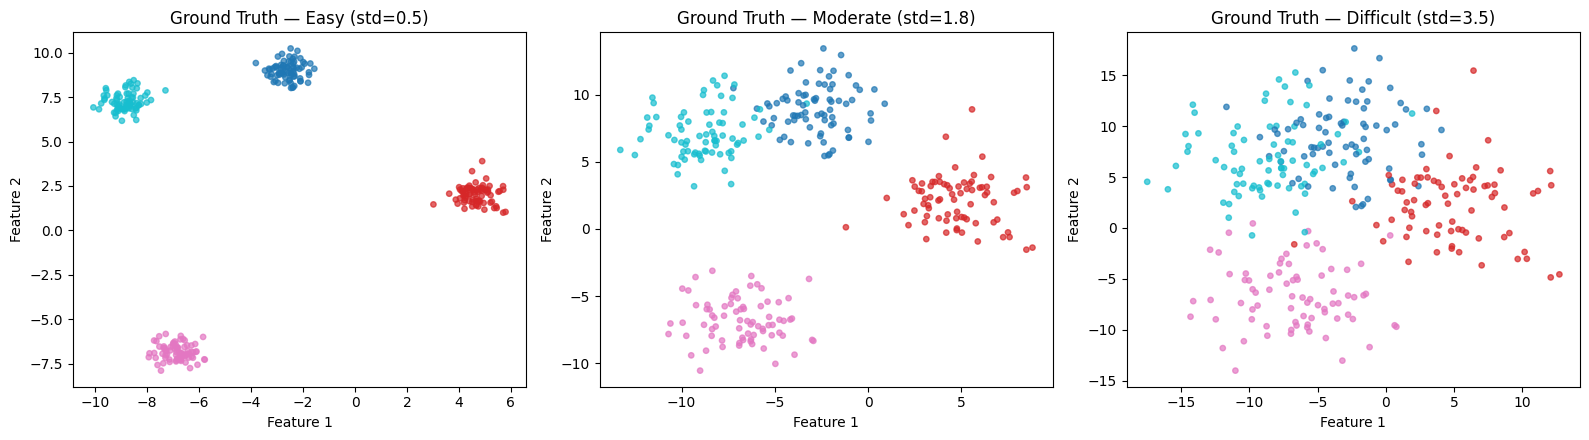

In [5]:
# Visualize ground truth labels
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
for ax, (name, (X, y)) in zip(axes, datasets.items(), strict=False):
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10", s=15, alpha=0.7)
    ax.set_title(f"Ground Truth — {name}")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
plt.tight_layout()
plt.show()

In [6]:
# Run K-Means on each dataset
km_results = {}
for name, (X, y) in datasets.items():
    km = KMeans(n_clusters=4, n_init=10, random_state=42)
    km.fit(X)
    km_results[name] = {
        "model": km,
        "labels": km.labels_,
        "centers": km.cluster_centers_,
        "inertia": km.inertia_,
    }

print("K-Means fitted on all 3 datasets.")

K-Means fitted on all 3 datasets.


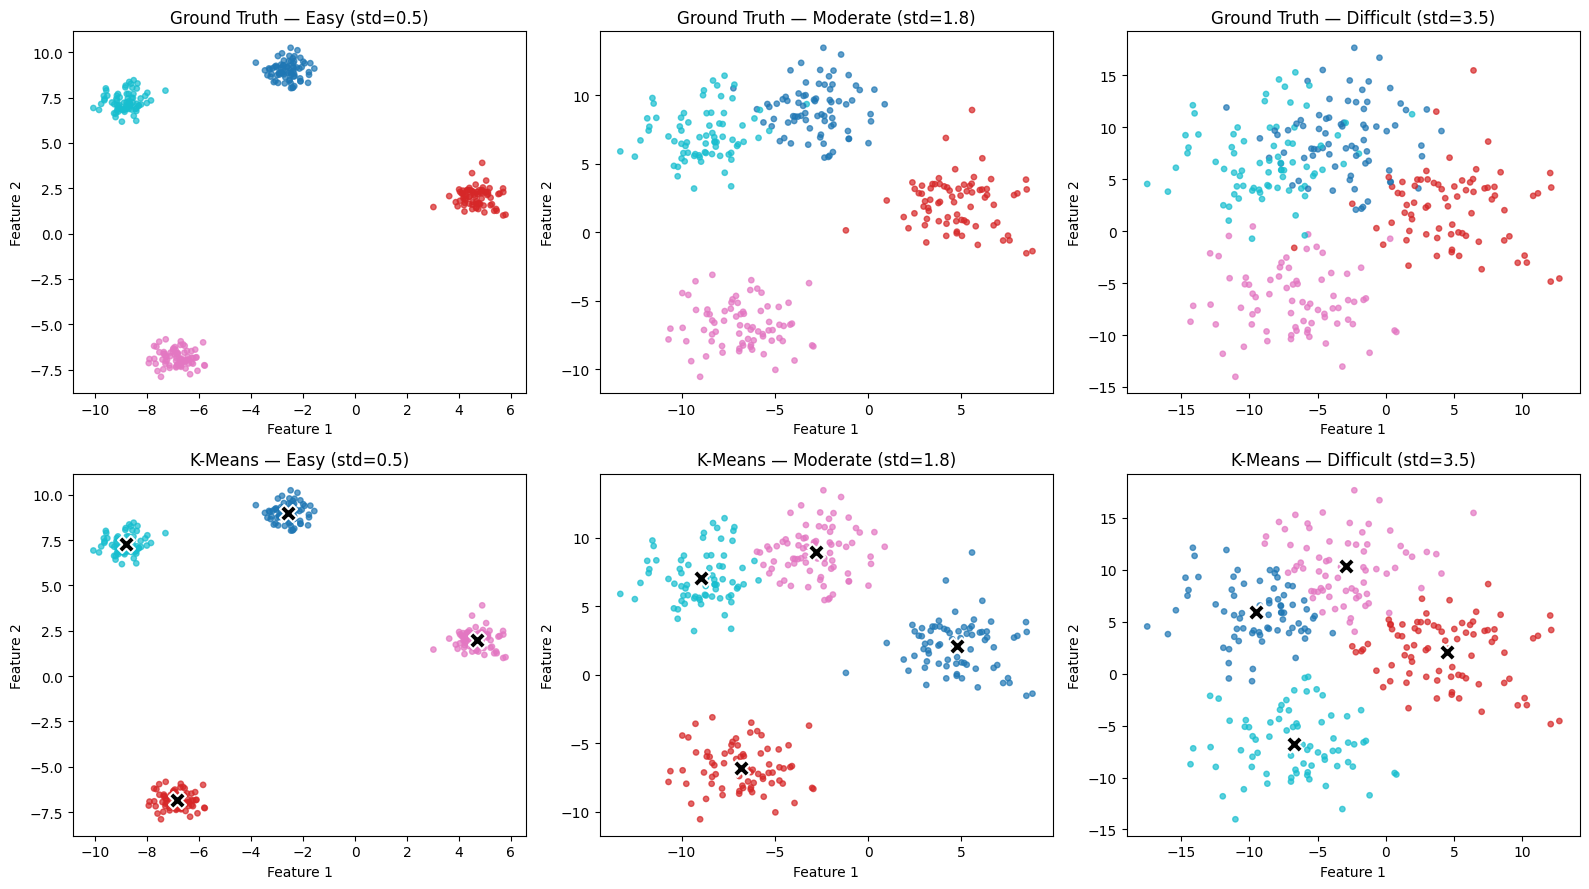

In [7]:
# Visualize K-Means predictions vs ground truth (2 rows x 3 cols)
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

for col, (name, (X, y)) in enumerate(datasets.items()):
    pred = km_results[name]["labels"]
    centers = km_results[name]["centers"]

    # Row 0: ground truth
    axes[0, col].scatter(X[:, 0], X[:, 1], c=y, cmap="tab10", s=15, alpha=0.7)
    axes[0, col].set_title(f"Ground Truth — {name}")

    # Row 1: K-means predictions
    axes[1, col].scatter(X[:, 0], X[:, 1], c=pred, cmap="tab10", s=15, alpha=0.7)
    axes[1, col].scatter(
        centers[:, 0],
        centers[:, 1],
        c="black",
        marker="X",
        s=150,
        edgecolors="white",
        linewidths=1.5,
    )
    axes[1, col].set_title(f"K-Means — {name}")

for ax in axes.flat:
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

In [8]:
# Compute all 10 metrics for each dataset
results = {name: {} for name in datasets}

for name, (X, y) in datasets.items():
    pred = km_results[name]["labels"]

    # Internal metrics
    results[name]["SSE"] = km_results[name]["inertia"]
    results[name]["Silhouette (SC)"] = silhouette_score(X, pred)
    results[name]["Dunn Index (DI)"] = dunn_index(X, pred)
    results[name]["Davies-Bouldin (DB)"] = davies_bouldin_score(X, pred)
    results[name]["Calinski-Harabasz (CH)"] = calinski_harabasz_score(X, pred)
    results[name]["NCI"] = new_correlation_index(X, pred)

    # External metrics
    results[name]["Rand Index (ARI)"] = adjusted_rand_score(y, pred)
    results[name]["Rand Index (Raw)"] = rand_score(y, pred)
    results[name]["Van Dongen (VD)"] = van_dongen_criterion(y, pred)
    results[name]["Variation of Info (VI)"] = variation_of_information(y, pred)
    results[name]["VI (normalized)"] = variation_of_information(y, pred, normalized=True)
    results[name]["Omega (\u03a9)"] = omega_indicator(y, pred)

print("All metrics computed.")

All metrics computed.


In [9]:
# Results summary table
direction_map = {
    "SSE": "Lower",
    "Silhouette (SC)": "Higher",
    "Dunn Index (DI)": "Higher",
    "Davies-Bouldin (DB)": "Lower",
    "Calinski-Harabasz (CH)": "Higher",
    "NCI": "Higher",
    "Rand Index (ARI)": "Higher",
    "Rand Index (Raw)": "Higher",
    "Van Dongen (VD)": "Lower",
    "Variation of Info (VI)": "Lower",
    "VI (normalized)": "Lower",
    "Omega (\u03a9)": "Lower",
}

# Build DataFrame
metric_names = list(direction_map.keys())
df_results = pd.DataFrame(
    {name: [results[name][m] for m in metric_names] for name in datasets}, index=metric_names
)

df_results["Better"] = [direction_map[m] for m in metric_names]

# Display with formatting
display(
    df_results.style.format(
        {col: "{:.4f}" for col in df_results.columns if col != "Better"}
    ).set_caption("Clustering Metrics Across Difficulty Levels")
)

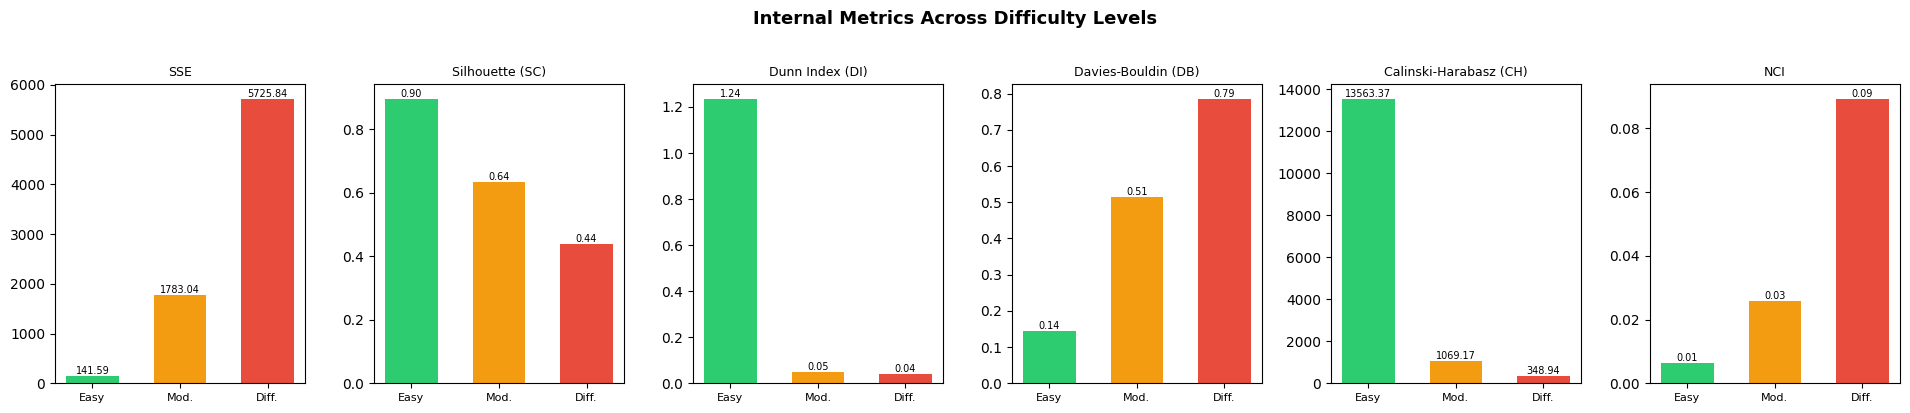

In [10]:
# Bar charts: Internal vs External metrics
difficulty_levels = list(datasets.keys())
colors = ["#2ecc71", "#f39c12", "#e74c3c"]  # green, orange, red

internal_metrics = [
    "SSE",
    "Silhouette (SC)",
    "Dunn Index (DI)",
    "Davies-Bouldin (DB)",
    "Calinski-Harabasz (CH)",
    "NCI",
]
external_metrics = [
    "Rand Index (ARI)",
    "Rand Index (Raw)",
    "Van Dongen (VD)",
    "Variation of Info (VI)",
    "Omega (\u03a9)",
]


def plot_metric_bars(metric_list, title):
    n_metrics = len(metric_list)
    fig, axes = plt.subplots(1, n_metrics, figsize=(3.2 * n_metrics, 4))
    if n_metrics == 1:
        axes = [axes]
    for ax, metric in zip(axes, metric_list, strict=False):
        vals = [results[lvl][metric] for lvl in difficulty_levels]
        bars = ax.bar(range(3), vals, color=colors, width=0.6)
        ax.set_xticks(range(3))
        ax.set_xticklabels(["Easy", "Mod.", "Diff."], fontsize=8)
        ax.set_title(metric, fontsize=9)
        # Annotate values
        for bar, v in zip(bars, vals, strict=False):
            ax.annotate(
                f"{v:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha="center",
                va="bottom",
                fontsize=7,
            )
    fig.suptitle(title, fontsize=13, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()


plot_metric_bars(internal_metrics, "Internal Metrics Across Difficulty Levels")
plot_metric_bars(external_metrics, "External Metrics Across Difficulty Levels")

In [11]:
# Degradation trend lines (normalized to [0,1] for comparison)
def normalize_series(vals):
    """Min-max normalize a list of values to [0, 1]."""
    arr = np.array(vals, dtype=float)
    rng = arr.max() - arr.min()
    if rng == 0:
        return np.zeros_like(arr)
    return (arr - arr.min()) / rng


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
x = [0, 1, 2]
x_labels = ["Easy", "Moderate", "Difficult"]

# Internal metrics
for metric in internal_metrics:
    raw_vals = [results[lvl][metric] for lvl in difficulty_levels]
    norm_vals = normalize_series(raw_vals)
    # Flip "lower=better" metrics so that UP always means BETTER
    if direction_map[metric] == "Lower":
        norm_vals = 1.0 - norm_vals
    ax1.plot(x, norm_vals, marker="o", label=metric, linewidth=2)

ax1.set_xticks(x)
ax1.set_xticklabels(x_labels)
ax1.set_ylabel("Normalized Score (higher = better clustering)")
ax1.set_title("Internal Metrics Degradation")
ax1.legend(fontsize=8, loc="lower left")
ax1.grid(True, alpha=0.3)

# External metrics
for metric in external_metrics:
    raw_vals = [results[lvl][metric] for lvl in difficulty_levels]
    norm_vals = normalize_series(raw_vals)
    if direction_map[metric] == "Lower":
        norm_vals = 1.0 - norm_vals
    ax2.plot(x, norm_vals, marker="s", label=metric, linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(x_labels)
ax2.set_ylabel("Normalized Score (higher = better clustering)")
ax2.set_title("External Metrics Degradation")
ax2.legend(fontsize=8, loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Analysis & Conclusions

### Observed Behavior

**Easy dataset** (well-separated clusters):  
- Internal metrics show strong clustering: high SC, high DI, high CH, low DB, low SSE  
- External metrics confirm near-perfect partition match: ARI close to 1.0, VD and VI close to 0  
- K-means recovers the ground truth almost exactly

**Moderate dataset** (partial overlap):  
- Most metrics degrade noticeably  
- Dunn Index drops sharply — it is the most sensitive to even small amounts of overlap (due to its reliance on min inter-cluster distance)  
- SC and CH degrade more gracefully, making them more reliable for moderate-complexity data  

**Difficult dataset** (heavy overlap):  
- K-means produces partitions that poorly match the ground truth  
- SSE remains large because points are far from any centroid  
- External metrics (VD, VI) increase substantially, confirming the partition mismatch  
- The Omega indicator provides a single composite view of this complexity

### Non-Monotonic Behavior: NCI

**NCI does NOT degrade monotonically** with increasing overlap. Unlike all other metrics which trend smoothly worse, NCI oscillates — this is by design. The guide describes NCI as providing "multiple local peaks for sub-optimal cluster options." It captures structural transitions in the correlation between point-to-centroid and centroid-to-global-mean distances, which can shift non-linearly as overlap changes. This makes NCI useful for detecting interesting alternative cluster configurations, but unreliable as a simple "quality score."

### Practical Guidance

| Scenario | Recommended Metrics |
|----------|--------------------|
| **No ground truth (production)** | Silhouette + Calinski-Harabasz (efficient and reliable) |
| **With ground truth (validation)** | ARI (most robust) + VI (principled information-theoretic measure) |
| **Exploring optimal k** | SSE (elbow method) + NCI (multi-peak detection — look for peaks, not monotonic trend) |
| **Quick complexity assessment** | Omega indicator (single composite score) |
| **Noise/outlier-heavy data** | Avoid Dunn Index; prefer DB or SC which are more robust |

### Computational Cost

- **O(n)**: SSE, Davies-Bouldin, Calinski-Harabasz, NCI, Van Dongen, VI, Omega  
- **O(n^2)**: Silhouette, Dunn Index, Rand Index  
- For large-scale semantic embeddings (millions of vectors), prefer the O(n) metrics or use sampling for O(n^2) ones.

---
## Part 3 — Fine-Grained Cluster Overlap Progression (std = 0.5 to 5.0)

Below we generate **10 datasets** with `cluster_std` ranging from 0.5 to 5.0 in 0.5 increments.  
This provides a smooth view of how clusters degrade and how every metric responds across the full overlap spectrum.

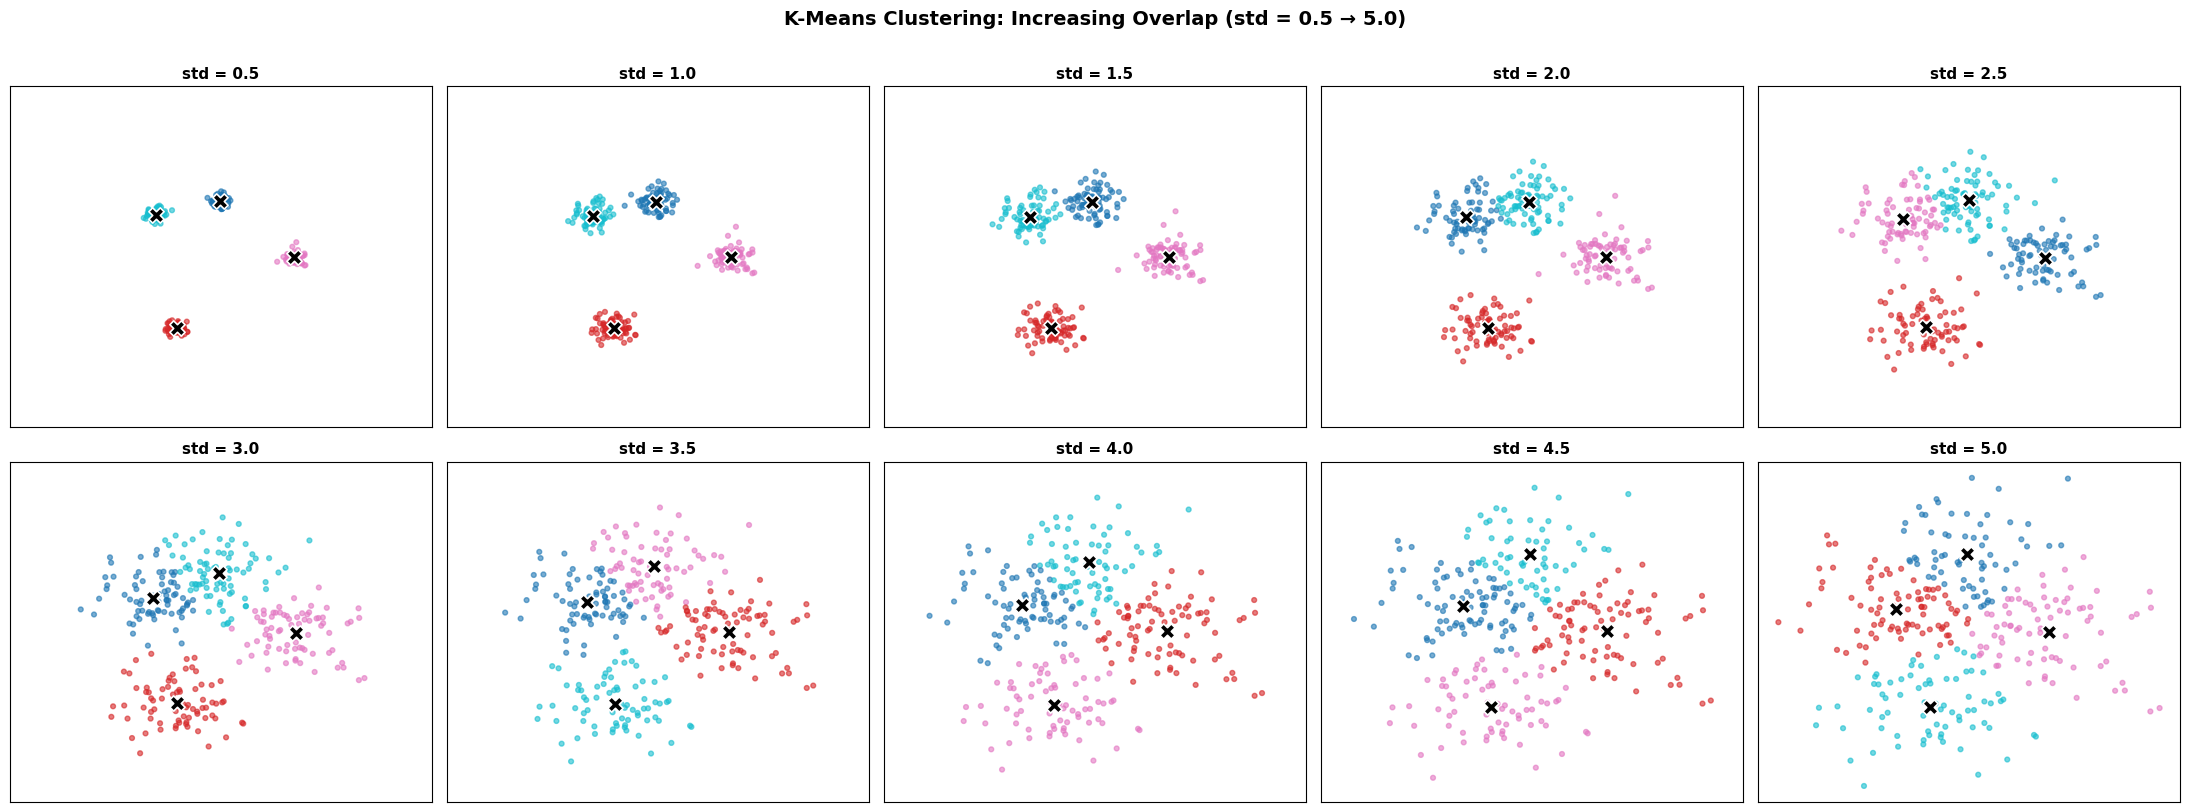

In [12]:
# Generate 10 datasets (std = 0.5 to 5.0) and plot K-Means results in a grid
std_values = np.arange(0.5, 5.5, 0.5)  # [0.5, 1.0, 1.5, ..., 5.0]

fine_data = {}
fine_km = {}

for std in std_values:
    X, y = make_blobs(n_samples=300, centers=4, n_features=2, cluster_std=std, random_state=42)
    km = KMeans(n_clusters=4, n_init=10, random_state=42).fit(X)
    fine_data[std] = (X, y)
    fine_km[std] = km

# Compute shared axis limits from the widest dataset (std=5.0)
X_wide = fine_data[5.0][0]
pad = 2
x_lim = (X_wide[:, 0].min() - pad, X_wide[:, 0].max() + pad)
y_lim = (X_wide[:, 1].min() - pad, X_wide[:, 1].max() + pad)

# Scatter plot grid: 2 rows x 5 cols
fig, axes = plt.subplots(2, 5, figsize=(22, 8))
for idx, std in enumerate(std_values):
    row, col = divmod(idx, 5)
    ax = axes[row, col]
    X, y = fine_data[std]
    pred = fine_km[std].labels_
    centers = fine_km[std].cluster_centers_

    ax.scatter(X[:, 0], X[:, 1], c=pred, cmap="tab10", s=12, alpha=0.6)
    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        c="black",
        marker="X",
        s=120,
        edgecolors="white",
        linewidths=1.2,
    )
    ax.set_title(f"std = {std:.1f}", fontsize=11, fontweight="bold")
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle(
    "K-Means Clustering: Increasing Overlap (std = 0.5 → 5.0)",
    fontsize=14,
    fontweight="bold",
    y=1.01,
)
plt.tight_layout()
plt.show()

Metrics across all 10 std values:


SSE  Silhouette (SC)  Dunn Index (DI)  Davies-Bouldin (DB)  \
cluster_std                                                                     
0.5           141.5908           0.8966           1.2366               0.1445   
1.0           564.9142           0.7916           0.2294               0.2905   
1.5          1251.3526           0.6912           0.1058               0.4325   
2.0          2183.4473           0.6000           0.0437               0.5661   
2.5          3275.5456           0.5299           0.0484               0.6742   
3.0          4475.9184           0.4758           0.0349               0.7535   
3.5          5725.8420           0.4400           0.0385               0.7862   
4.0          7024.5836           0.4089           0.0218               0.8322   
4.5          8412.8601           0.3892           0.0318               0.8553   
5.0          9896.3414           0.3618           0.0278               0.8996   

             Calinski-Harabasz (CH)     NCI  Rand Index (ARI)  \
cluster_std                                                     
0.5                      13563.3680  0.0065            1.0000   
1.0                       3386.4147  0.0032            0.9911   
1.5                       1524.6044  0.0165            0.9911   
2.0                        873.1710  0.0343            0.9401   
2.5                        585.4292  0.0363            0.8383   
3.0                        434.8054  0.0612            0.7887   
3.5                        348.9403  0.0894            0.6834   
4.0                        295.1268  0.0706            0.5961   
4.5                        257.6572  0.0658            0.5333   
5.0                        230.4781  0.1100            0.4853   

             Rand Index (Raw)  Van Dongen (VD)  Variation of Info (VI)  \
cluster_std                                                              
0.5                    1.0000           0.0000                  0.0000   
1.0                    0.9967           0.0033                  0.0511   
1.5                    0.9967           0.0033                  0.0511   
2.0                    0.9777           0.0233                  0.2714   
2.5                    0.9398           0.0667                  0.6495   
3.0                    0.9213           0.0900                  0.8411   
3.5                    0.8820           0.1433                  1.2510   
4.0                    0.8493           0.1900                  1.5715   
4.5                    0.8250           0.2267                  1.7832   
5.0                    0.8078           0.2567                  1.9830   

             Omega (Ω)  
cluster_std             
0.5             0.0000  
1.0             0.0062  
1.5             0.0062  
2.0             0.0387  
2.5             0.1024  
3.0             0.1345  
3.5             0.2040  
4.0             0.2616  
4.5             0.3033  
5.0             0.3375

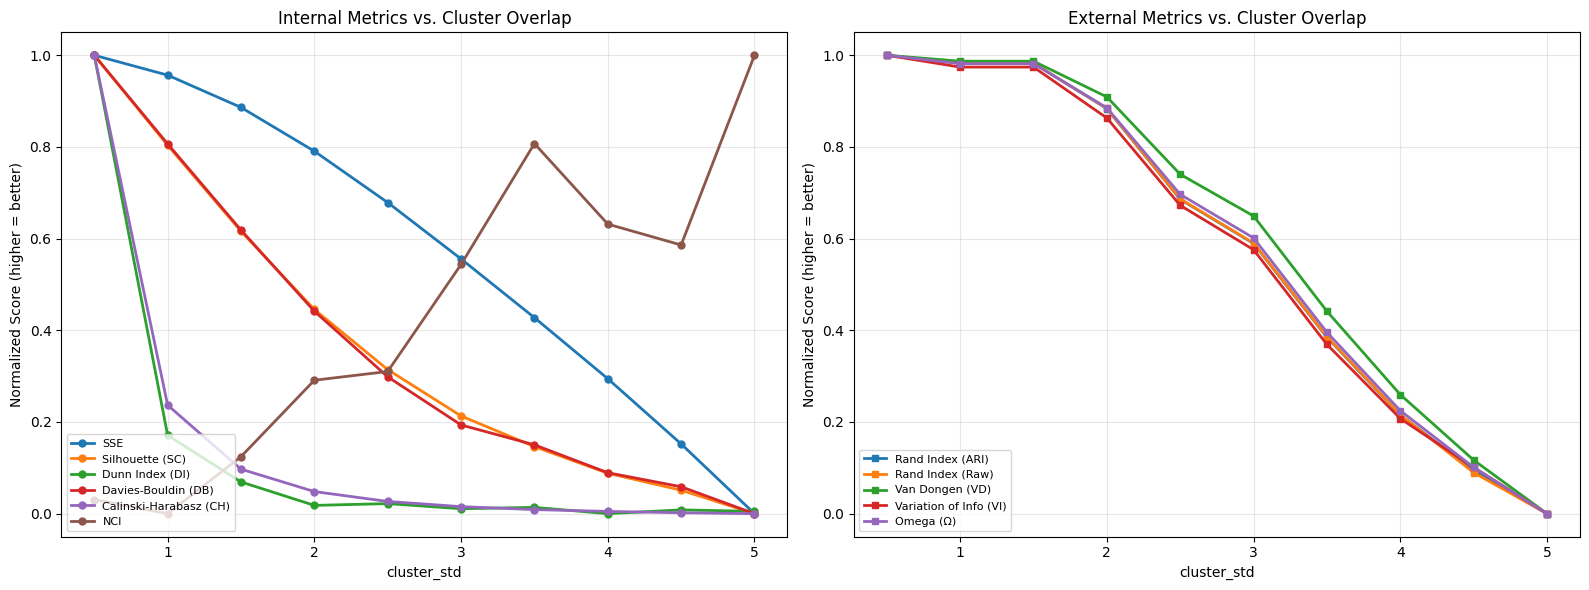

In [13]:
# Compute all metrics at each std value
fine_metrics = {std: {} for std in std_values}

for std in std_values:
    X, y = fine_data[std]
    pred = fine_km[std].labels_

    # Internal
    fine_metrics[std]["SSE"] = fine_km[std].inertia_
    fine_metrics[std]["Silhouette (SC)"] = silhouette_score(X, pred)
    fine_metrics[std]["Dunn Index (DI)"] = dunn_index(X, pred)
    fine_metrics[std]["Davies-Bouldin (DB)"] = davies_bouldin_score(X, pred)
    fine_metrics[std]["Calinski-Harabasz (CH)"] = calinski_harabasz_score(X, pred)
    fine_metrics[std]["NCI"] = new_correlation_index(X, pred)

    # External
    fine_metrics[std]["Rand Index (ARI)"] = adjusted_rand_score(y, pred)
    fine_metrics[std]["Rand Index (Raw)"] = rand_score(y, pred)
    fine_metrics[std]["Van Dongen (VD)"] = van_dongen_criterion(y, pred)
    fine_metrics[std]["Variation of Info (VI)"] = variation_of_information(y, pred)
    fine_metrics[std]["Omega (\u03a9)"] = omega_indicator(y, pred)

# Build full results DataFrame
df_fine = pd.DataFrame(fine_metrics).T
df_fine.index.name = "cluster_std"
print("Metrics across all 10 std values:")
display(df_fine.round(4))

# --- Continuous degradation curves ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

int_metrics = [
    "SSE",
    "Silhouette (SC)",
    "Dunn Index (DI)",
    "Davies-Bouldin (DB)",
    "Calinski-Harabasz (CH)",
    "NCI",
]
ext_metrics = [
    "Rand Index (ARI)",
    "Rand Index (Raw)",
    "Van Dongen (VD)",
    "Variation of Info (VI)",
    "Omega (\u03a9)",
]

for metric in int_metrics:
    raw_vals = [fine_metrics[s][metric] for s in std_values]
    norm_vals = normalize_series(raw_vals)
    if direction_map[metric] == "Lower":
        norm_vals = 1.0 - norm_vals
    ax1.plot(std_values, norm_vals, marker="o", label=metric, linewidth=2, markersize=5)

ax1.set_xlabel("cluster_std")
ax1.set_ylabel("Normalized Score (higher = better)")
ax1.set_title("Internal Metrics vs. Cluster Overlap")
ax1.legend(fontsize=8, loc="lower left")
ax1.grid(True, alpha=0.3)

for metric in ext_metrics:
    raw_vals = [fine_metrics[s][metric] for s in std_values]
    norm_vals = normalize_series(raw_vals)
    if direction_map.get(metric, "Higher") == "Lower":
        norm_vals = 1.0 - norm_vals
    ax2.plot(std_values, norm_vals, marker="s", label=metric, linewidth=2, markersize=5)

ax2.set_xlabel("cluster_std")
ax2.set_ylabel("Normalized Score (higher = better)")
ax2.set_title("External Metrics vs. Cluster Overlap")
ax2.legend(fontsize=8, loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 4 — HDBSCAN: Density-Based Clustering Comparison

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is a density-based
clustering algorithm that does not require specifying the number of clusters. Unlike K-Means, it:
- Discovers clusters of **arbitrary shape** and varying density
- Labels low-density points as **noise** (label = -1)
- Has a single main hyperparameter: `min_cluster_size`

### HDBSCAN-Compatible Metrics (6 of the original 10)

| Metric | Type | Noise Handling | Why Compatible |
|--------|------|----------------|----------------|
| **Silhouette (SC)** | Internal | Exclude noise points | Distance-based, no centroid assumption |
| **DBCV** | Internal | Exclude noise (built-in) | Designed specifically for density-based clusters |
| **ARI** | External | Noise = own cluster | Pairwise comparison, permutation-invariant |
| **Van Dongen (VD)** | External | Noise = own cluster | Contingency-based, handles any label set |
| **Variation of Info (VI)** | External | Noise = own cluster | Information-theoretic, no shape assumption |
| **Omega** | External | Via components | Composite of ARI, VD, VI |

**Excluded metrics**: SSE (K-means objective), Davies-Bouldin & Calinski-Harabasz (require centroids),
NCI (centroid-to-global-mean correlation), Dunn Index (pathologically sensitive to noise points).

In [14]:
# Fit HDBSCAN on all 10 datasets
from hdbscan import validity_index as dbcv_score
from sklearn.cluster import HDBSCAN

fine_hdb = {}

for std in std_values:
    X, y = fine_data[std]
    hdb = HDBSCAN(min_cluster_size=15)
    hdb.fit(X)
    fine_hdb[std] = hdb

# Summary table
print(f"{'std':>5} | {'Clusters':>8} | {'Noise':>6} | {'Noise%':>6}")
print("-" * 36)
for std in std_values:
    labels = fine_hdb[std].labels_
    n_clusters = len(set(labels) - {-1})
    n_noise = (labels == -1).sum()
    print(f"{std:5.1f} | {n_clusters:>8} | {n_noise:>6} | {100 * n_noise / len(labels):>5.1f}%")

  std | Clusters |  Noise | Noise%
------------------------------------
  0.5 |        4 |      0 |   0.0%
  1.0 |        4 |      0 |   0.0%
  1.5 |        3 |      1 |   0.3%
  2.0 |        3 |     19 |   6.3%
  2.5 |        3 |     69 |  23.0%
  3.0 |        2 |     41 |  13.7%
  3.5 |        2 |     84 |  28.0%
  4.0 |        2 |    106 |  35.3%
  4.5 |        2 |    126 |  42.0%
  5.0 |        0 |    300 | 100.0%


/Users/alonneduva/Desktop/MindINT/Research/research/degrading-clustering-dataset/.venv/lib/python3.13/site-packages/sklearn/cluster/_hdbscan/hdbscan.py:722: FutureWarning: The default value of `copy` will change from False to True in 1.10. Explicitly set a value for `copy` to silence this warning.
  warn(
/Users/alonneduva/Desktop/MindINT/Research/research/degrading-clustering-dataset/.venv/lib/python3.13/site-packages/sklearn/cluster/_hdbscan/hdbscan.py:722: FutureWarning: The default value of `copy` will change from False to True in 1.10. Explicitly set a value for `copy` to silence this warning.
  warn(
/Users/alonneduva/Desktop/MindINT/Research/research/degrading-clustering-dataset/.venv/lib/python3.13/site-packages/sklearn/cluster/_hdbscan/hdbscan.py:722: FutureWarning: The default value of `copy` will change from False to True in 1.10. Explicitly set a value for `copy` to silence this warning.
  warn(
/Users/alonneduva/Desktop/MindINT/Research/research/degrading-clustering-datase

In [15]:
# HDBSCAN scatter plot grid: 2 rows x 5 cols (matching Part 3 K-Means grid)
fig, axes = plt.subplots(2, 5, figsize=(22, 8))

for idx, std in enumerate(std_values):
    row, col = divmod(idx, 5)
    ax = axes[row, col]
    X, y = fine_data[std]
    pred = fine_hdb[std].labels_

    noise_mask = pred == -1
    cluster_mask = ~noise_mask

    # Plot clustered points
    if cluster_mask.any():
        ax.scatter(
            X[cluster_mask, 0],
            X[cluster_mask, 1],
            c=pred[cluster_mask],
            cmap="tab10",
            s=12,
            alpha=0.6,
        )

    # Plot noise points (gray x markers)
    if noise_mask.any():
        ax.scatter(X[noise_mask, 0], X[noise_mask, 1], c="gray", marker="x", s=10, alpha=0.3)

    n_clusters = len(set(pred) - {-1})
    n_noise = noise_mask.sum()
    ax.text(
        0.02,
        0.98,
        f"k={n_clusters}, noise={n_noise}",
        transform=ax.transAxes,
        fontsize=8,
        va="top",
        bbox={"boxstyle": "round,pad=0.3", "facecolor": "white", "alpha": 0.8},
    )

    ax.set_title(f"std = {std:.1f}", fontsize=11, fontweight="bold")
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle(
    "HDBSCAN Clustering: Increasing Overlap (std = 0.5 \u2192 5.0)",
    fontsize=14,
    fontweight="bold",
    y=1.01,
)
plt.tight_layout()
plt.show()

In [16]:
# Compute HDBSCAN-compatible metrics at each std value
hdb_metrics = {std: {} for std in std_values}

for std in std_values:
    X, y = fine_data[std]
    pred = fine_hdb[std].labels_

    noise_mask = pred == -1
    non_noise = ~noise_mask
    n_clusters = len(set(pred) - {-1})

    # --- Internal metrics ---

    # Silhouette: exclude noise, require >= 2 clusters
    if non_noise.sum() > 0 and n_clusters >= 2:
        hdb_metrics[std]["Silhouette (SC)"] = silhouette_score(X[non_noise], pred[non_noise])
    else:
        hdb_metrics[std]["Silhouette (SC)"] = np.nan

    # DBCV: handles noise internally, returns NaN if < 2 clusters
    if n_clusters >= 2:
        hdb_metrics[std]["DBCV"] = dbcv_score(X, pred)
    else:
        hdb_metrics[std]["DBCV"] = np.nan

    # --- External metrics (noise kept as label -1, treated as own cluster) ---

    if n_clusters >= 1:
        hdb_metrics[std]["Rand Index (ARI)"] = adjusted_rand_score(y, pred)
        hdb_metrics[std]["Van Dongen (VD)"] = van_dongen_criterion(y, pred)
        hdb_metrics[std]["Variation of Info (VI)"] = variation_of_information(y, pred)
        hdb_metrics[std]["Omega (\u03a9)"] = omega_indicator(y, pred)
    else:
        hdb_metrics[std]["Rand Index (ARI)"] = np.nan
        hdb_metrics[std]["Van Dongen (VD)"] = np.nan
        hdb_metrics[std]["Variation of Info (VI)"] = np.nan
        hdb_metrics[std]["Omega (\u03a9)"] = np.nan

# Display as DataFrame
df_hdb = pd.DataFrame(hdb_metrics).T
df_hdb.index.name = "cluster_std"
print("HDBSCAN Metrics across all 10 std values:")
display(df_hdb.round(4))

HDBSCAN Metrics across all 10 std values:


Silhouette (SC)    DBCV  Rand Index (ARI)  Van Dongen (VD)  \
cluster_std                                                               
0.5                   0.8966  0.9110            1.0000           0.0000   
1.0                   0.7916  0.7797            0.9911           0.0033   
1.5                   0.7037  0.6331            0.7079           0.1267   
2.0                   0.6609  0.5174            0.6614           0.1617   
2.5                   0.6591  0.2712            0.4910           0.2850   
3.0                   0.4878  0.4185            0.2661           0.3267   
3.5                   0.5087  0.3408            0.2031           0.4150   
4.0                   0.4796  0.1586            0.1440           0.4583   
4.5                   0.4582  0.0675            0.1040           0.4833   
5.0                      NaN     NaN               NaN              NaN   

             Variation of Info (VI)  Omega (Ω)  
cluster_std                                     
0.5                          0.0000     0.0000  
1.0                          0.0511     0.0062  
1.5                          0.5255     0.1609  
2.0                          0.8638     0.2017  
2.5                          1.5763     0.3285  
3.0                          1.9056     0.4307  
3.5                          2.2732     0.4961  
4.0                          2.5797     0.5426  
4.5                          2.7240     0.5701  
5.0                             NaN        NaN

In [17]:
# HDBSCAN metric degradation curves
hdb_direction = {
    "Silhouette (SC)": "Higher",
    "DBCV": "Higher",
    "Rand Index (ARI)": "Higher",
    "Van Dongen (VD)": "Lower",
    "Variation of Info (VI)": "Lower",
    "Omega (\u03a9)": "Lower",
}

hdb_internal = ["Silhouette (SC)", "DBCV"]
hdb_external = ["Rand Index (ARI)", "Van Dongen (VD)", "Variation of Info (VI)", "Omega (\u03a9)"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


def plot_hdb_curves(ax, metric_list, title, marker="o"):
    for metric in metric_list:
        raw_vals = np.array([hdb_metrics[s].get(metric, np.nan) for s in std_values])
        valid = ~np.isnan(raw_vals)
        if valid.sum() < 2:
            continue
        valid_std = std_values[valid]
        valid_vals = raw_vals[valid]
        norm_vals = normalize_series(valid_vals)
        if hdb_direction[metric] == "Lower":
            norm_vals = 1.0 - norm_vals
        ax.plot(valid_std, norm_vals, marker=marker, label=metric, linewidth=2, markersize=5)
        # Mark NaN positions with red triangles
        nan_stds = std_values[~valid]
        if len(nan_stds) > 0:
            ax.scatter(
                nan_stds, np.zeros(len(nan_stds)), marker="v", c="red", s=40, zorder=5, alpha=0.5
            )
    ax.set_xlabel("cluster_std")
    ax.set_ylabel("Normalized Score (higher = better)")
    ax.set_title(title)
    ax.legend(fontsize=9, loc="lower left")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.25, 5.25)


plot_hdb_curves(ax1, hdb_internal, "HDBSCAN: Internal Metrics vs. Cluster Overlap")
plot_hdb_curves(ax2, hdb_external, "HDBSCAN: External Metrics vs. Cluster Overlap", marker="s")

plt.tight_layout()
plt.show()

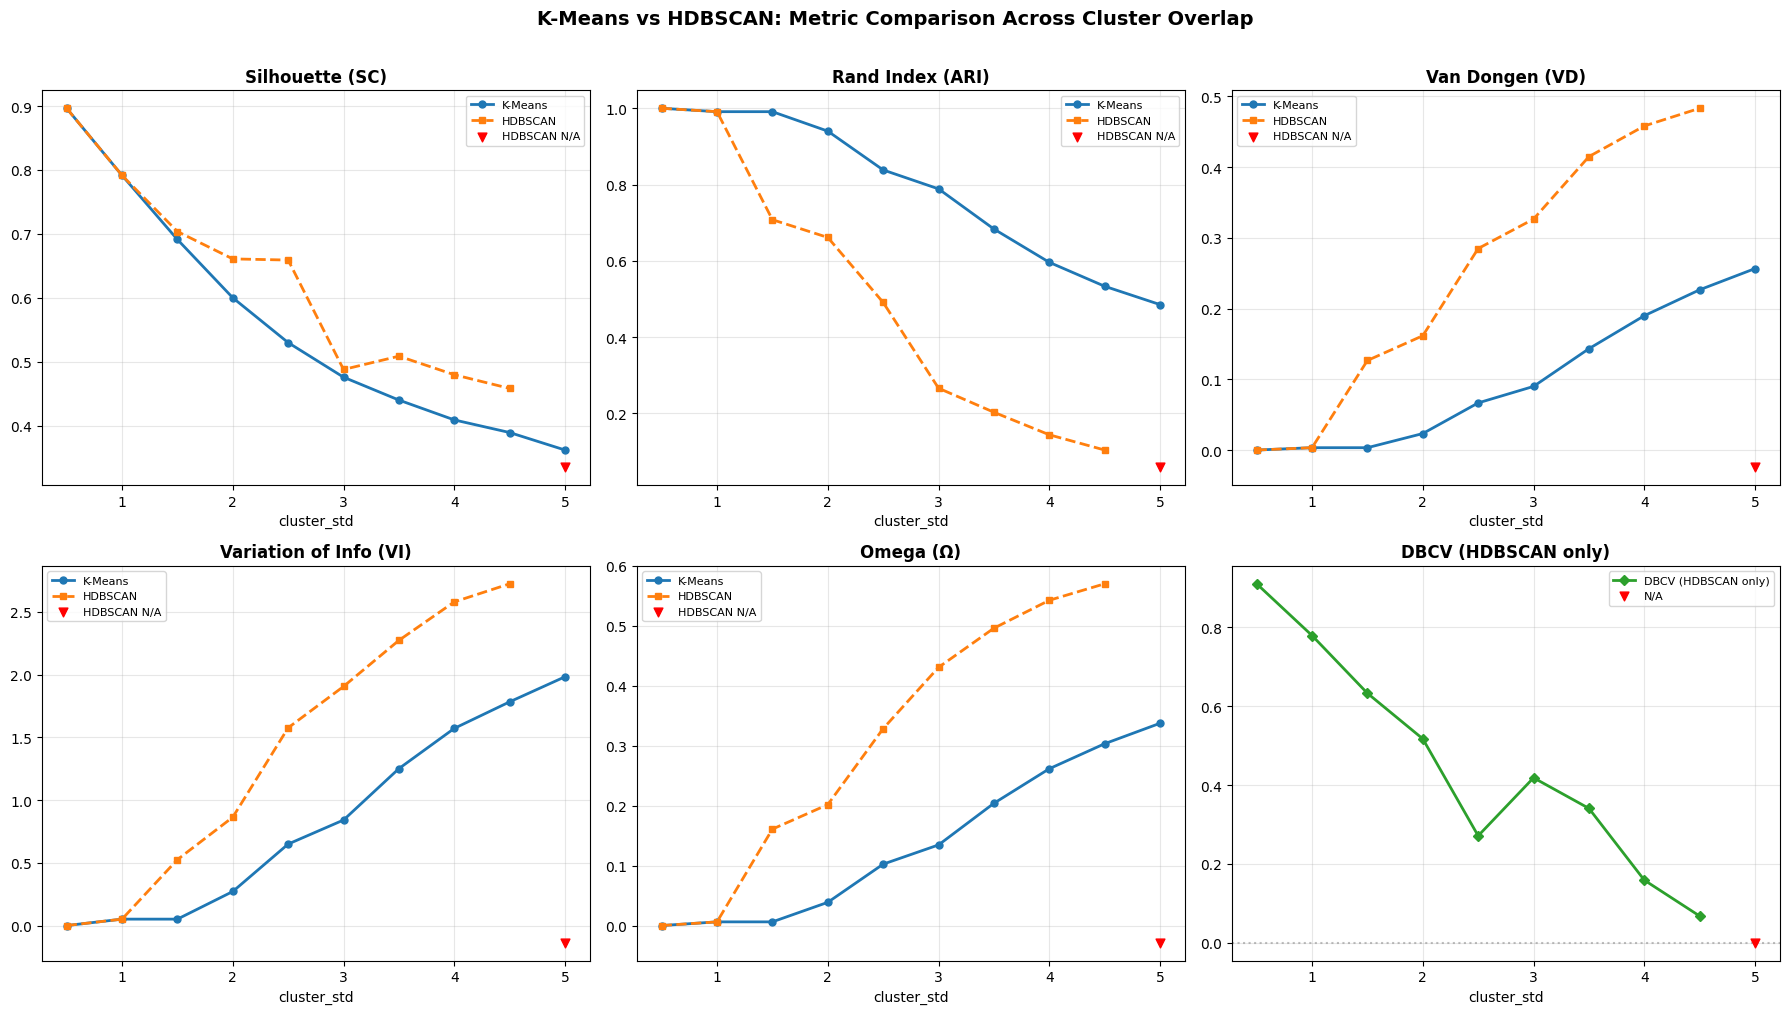

In [18]:
# K-Means vs HDBSCAN: Side-by-side metric comparison (raw values)
shared_metrics = [
    "Silhouette (SC)",
    "Rand Index (ARI)",
    "Van Dongen (VD)",
    "Variation of Info (VI)",
    "Omega (\u03a9)",
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes_flat = axes.flatten()

for i, metric in enumerate(shared_metrics):
    ax = axes_flat[i]

    # K-Means curve (solid blue)
    km_vals = np.array([fine_metrics[s][metric] for s in std_values])
    ax.plot(
        std_values,
        km_vals,
        marker="o",
        linewidth=2,
        markersize=5,
        color="tab:blue",
        label="K-Means",
        linestyle="-",
    )

    # HDBSCAN curve (dashed orange)
    hdb_vals = np.array([hdb_metrics[s].get(metric, np.nan) for s in std_values])
    valid = ~np.isnan(hdb_vals)
    ax.plot(
        std_values[valid],
        hdb_vals[valid],
        marker="s",
        linewidth=2,
        markersize=5,
        color="tab:orange",
        label="HDBSCAN",
        linestyle="--",
    )

    # Mark NaN positions
    nan_stds = std_values[~valid]
    if len(nan_stds) > 0:
        y_bottom = ax.get_ylim()[0] if ax.get_ylim()[0] != ax.get_ylim()[1] else 0
        ax.scatter(
            nan_stds,
            [y_bottom] * len(nan_stds),
            marker="v",
            c="red",
            s=40,
            zorder=5,
            label="HDBSCAN N/A",
        )

    ax.set_title(metric, fontsize=12, fontweight="bold")
    ax.set_xlabel("cluster_std")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

# 6th subplot: DBCV (HDBSCAN-only)
ax = axes_flat[5]
dbcv_vals = np.array([hdb_metrics[s].get("DBCV", np.nan) for s in std_values])
valid = ~np.isnan(dbcv_vals)
ax.plot(
    std_values[valid],
    dbcv_vals[valid],
    marker="D",
    linewidth=2,
    markersize=5,
    color="tab:green",
    label="DBCV (HDBSCAN only)",
)
nan_stds = std_values[~valid]
if len(nan_stds) > 0:
    ax.scatter(nan_stds, [0] * len(nan_stds), marker="v", c="red", s=40, zorder=5, label="N/A")
ax.axhline(y=0, color="gray", linestyle=":", alpha=0.5)
ax.set_title("DBCV (HDBSCAN only)", fontsize=12, fontweight="bold")
ax.set_xlabel("cluster_std")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

fig.suptitle(
    "K-Means vs HDBSCAN: Metric Comparison Across Cluster Overlap",
    fontsize=14,
    fontweight="bold",
    y=1.01,
)
plt.tight_layout()
plt.show()

In [19]:
# Summary comparison table: K-Means vs HDBSCAN
comparison_rows = []

for std in std_values:
    row = {"std": std}
    pred_hdb = fine_hdb[std].labels_
    row["HDB_k"] = len(set(pred_hdb) - {-1})
    row["HDB_noise%"] = f"{100 * (pred_hdb == -1).sum() / len(pred_hdb):.0f}%"

    for metric in shared_metrics:
        km_val = fine_metrics[std][metric]
        hdb_val = hdb_metrics[std].get(metric, np.nan)

        row["KM"] = None  # placeholder column ordering
        row[f"KM_{metric}"] = round(km_val, 4)
        row[f"HDB_{metric}"] = round(hdb_val, 4) if not np.isnan(hdb_val) else "N/A"

    # DBCV (HDBSCAN only)
    dbcv_val = hdb_metrics[std].get("DBCV", np.nan)
    row["HDB_DBCV"] = round(dbcv_val, 4) if not np.isnan(dbcv_val) else "N/A"
    comparison_rows.append(row)

df_compare = pd.DataFrame(comparison_rows).set_index("std")
# Drop the placeholder column
df_compare = df_compare.drop(columns=["KM"], errors="ignore")
display(df_compare)

# Win counts
print("\n--- Win Summary (across shared metrics, 10 std values) ---")
for metric in shared_metrics:
    km_wins = 0
    hdb_wins = 0
    for std in std_values:
        km_val = fine_metrics[std][metric]
        hdb_val = hdb_metrics[std].get(metric, np.nan)
        if np.isnan(hdb_val):
            km_wins += 1
            continue
        d = direction_map[metric]
        if d == "Higher":
            if hdb_val > km_val:
                hdb_wins += 1
            else:
                km_wins += 1
        else:
            if hdb_val < km_val:
                hdb_wins += 1
            else:
                km_wins += 1
    print(f"  {metric:25s}: K-Means={km_wins:2d}, HDBSCAN={hdb_wins:2d}")

HDB_k HDB_noise%  KM_Silhouette (SC) HDB_Silhouette (SC)  \
std                                                             
0.5      4         0%              0.8966              0.8966   
1.0      4         0%              0.7916              0.7916   
1.5      3         0%              0.6912              0.7037   
2.0      3         6%              0.6000              0.6609   
2.5      3        23%              0.5299              0.6591   
3.0      2        14%              0.4758              0.4878   
3.5      2        28%              0.4400              0.5087   
4.0      2        35%              0.4089              0.4796   
4.5      2        42%              0.3892              0.4582   
5.0      0       100%              0.3618                 N/A   

     KM_Rand Index (ARI) HDB_Rand Index (ARI)  KM_Van Dongen (VD)  \
std                                                                 
0.5               1.0000                  1.0              0.0000   
1.0               0.9911               0.9911              0.0033   
1.5               0.9911               0.7079              0.0033   
2.0               0.9401               0.6614              0.0233   
2.5               0.8383                0.491              0.0667   
3.0               0.7887               0.2661              0.0900   
3.5               0.6834               0.2031              0.1433   
4.0               0.5961                0.144              0.1900   
4.5               0.5333                0.104              0.2267   
5.0               0.4853                  N/A              0.2567   

    HDB_Van Dongen (VD)  KM_Variation of Info (VI) HDB_Variation of Info (VI)  \
std                                                                             
0.5                 0.0                     0.0000                        0.0   
1.0              0.0033                     0.0511                     0.0511   
1.5              0.1267                     0.0511                     0.5255   
2.0              0.1617                     0.2714                     0.8638   
2.5               0.285                     0.6495                     1.5763   
3.0              0.3267                     0.8411                     1.9056   
3.5               0.415                     1.2510                     2.2732   
4.0              0.4583                     1.5715                     2.5797   
4.5              0.4833                     1.7832                      2.724   
5.0                 N/A                     1.9830                        N/A   

     KM_Omega (Ω) HDB_Omega (Ω) HDB_DBCV  
std                                       
0.5        0.0000           0.0    0.911  
1.0        0.0062        0.0062   0.7797  
1.5        0.0062        0.1609   0.6331  
2.0        0.0387        0.2017   0.5174  
2.5        0.1024        0.3285   0.2712  
3.0        0.1345        0.4307   0.4185  
3.5        0.2040        0.4961   0.3408  
4.0        0.2616        0.5426   0.1586  
4.5        0.3033        0.5701   0.0675  
5.0        0.3375           N/A      N/A


--- Win Summary (across shared metrics, 10 std values) ---
  Silhouette (SC)          : K-Means= 3, HDBSCAN= 7
  Rand Index (ARI)         : K-Means=10, HDBSCAN= 0
  Van Dongen (VD)          : K-Means=10, HDBSCAN= 0
  Variation of Info (VI)   : K-Means=10, HDBSCAN= 0
  Omega (Ω)                : K-Means=10, HDBSCAN= 0


---
## Part 5 — Fuzzy C-Means (FCM): Soft Clustering Comparison

**Fuzzy C-Means (FCM)** is a soft clustering algorithm where each point has a **degree of membership** in every cluster,
rather than a hard 0/1 assignment. The membership matrix `U` has shape `(n, k)` where `U[i,j]` ∈ [0, 1] and each row sums to 1.

| Aspect | K-Means | HDBSCAN | FCM |
|--------|---------|---------|-----|
| **Assignment** | Hard (one cluster per point) | Hard + noise (label = -1) | Soft (membership degrees) |
| **Output** | Labels ∈ {0, ..., k-1} | Labels ∈ {-1, 0, ..., k-1} | Membership matrix U ∈ [0, 1]^(n×k) |
| **Overlap handling** | Forced assignment | Labels uncertain points as noise | Spreads membership across clusters |
| **Key parameter** | k (cluster count) | min_cluster_size | k + m (fuzzifier, default 2.0) |

### FCM-Specific Fuzzy Metrics

| Metric | Formula | Range | Direction | Interpretation |
|--------|---------|-------|-----------|----------------|
| **Partition Coefficient (PC)** | `Σ(U²) / n` | [1/k, 1] | Higher = crisper | 1.0 = hard assignment, 1/k = uniform fuzzy |
| **Classification Entropy (CE)** | `-Σ(U·log₂U) / n` | [0, log₂(k)] | Lower = crisper | 0 = hard assignment, log₂(k) = maximum uncertainty |
| **Xie-Beni Index (XB)** | `Σ(U^m · d²) / (n · min_sep²)` | [0, ∞) | Lower = better | Compactness vs separation, weighted by membership |
| **Fukuyama-Sugeno (FS)** | `Σ(U^m · (compactness - separation))` | (-∞, 0] | Lower = better | Negative = good separation; near 0 = poor |

In [20]:
# FCM imports and fuzzy-specific metric implementations
from fcmeans import FCM

# ============================================================
# Fuzzy-Specific Metrics
# ============================================================


def partition_coefficient(U):
    """PC: measures crispness of fuzzy partition. Range [1/k, 1], higher = crisper."""
    return np.sum(U**2) / U.shape[0]


def classification_entropy(U):
    """CE: entropy of membership matrix. Range [0, log2(k)], lower = crisper."""
    U_safe = np.clip(U, 1e-10, 1.0)
    return -np.sum(U * np.log2(U_safe)) / U.shape[0]


def xie_beni_index(X, U, centers, m=2.0):
    """XB: compactness vs separation weighted by membership. Lower = better."""
    n = X.shape[0]
    k = centers.shape[0]
    # Numerator: weighted sum of squared distances
    numerator = 0.0
    for j in range(k):
        dists_sq = np.sum((X - centers[j]) ** 2, axis=1)
        numerator += np.sum((U[:, j] ** m) * dists_sq)
    # Denominator: n * min inter-center distance squared
    min_center_dist_sq = np.inf
    for i in range(k):
        for j in range(i + 1, k):
            d = np.sum((centers[i] - centers[j]) ** 2)
            min_center_dist_sq = min(min_center_dist_sq, d)
    return numerator / (n * min_center_dist_sq) if min_center_dist_sq > 0 else np.inf


def fukuyama_sugeno(X, U, centers, m=2.0):
    """FS: weighted compactness minus separation. Lower (more negative) = better."""
    global_mean = X.mean(axis=0)
    k = centers.shape[0]
    result = 0.0
    for j in range(k):
        weights = U[:, j] ** m
        compactness = np.sum(weights * np.sum((X - centers[j]) ** 2, axis=1))
        separation = np.sum(weights) * np.sum((centers[j] - global_mean) ** 2)
        result += compactness - separation
    return result


print("FCM and fuzzy metric functions loaded.")

ModuleNotFoundError: No module named 'fcmeans'

In [ ]:
# Fit FCM on all 10 datasets
fine_fcm = {}

for std in std_values:
    X, y = fine_data[std]
    fcm = FCM(n_clusters=4, m=2.0, max_iter=200, random_state=42)
    fcm.fit(X)
    U = fcm.u  # membership matrix (n, 4)
    hard_labels = np.argmax(U, axis=1)  # hard assignment via argmax
    centers = fcm.centers  # cluster centroids

    fine_fcm[std] = {
        "model": fcm,
        "U": U,
        "hard_labels": hard_labels,
        "centers": centers,
    }

# Summary: fuzziness overview
print(f"{'std':>5} | {'Mean Max U':>10} | {'PC':>6} | {'CE':>6}")
print("-" * 38)
for std in std_values:
    U = fine_fcm[std]["U"]
    max_u_mean = U.max(axis=1).mean()
    pc = partition_coefficient(U)
    ce = classification_entropy(U)
    print(f"{std:5.1f} | {max_u_mean:10.4f} | {pc:6.4f} | {ce:6.4f}")

NameError: name 'FCM' is not defined

KeyError: np.float64(0.5)

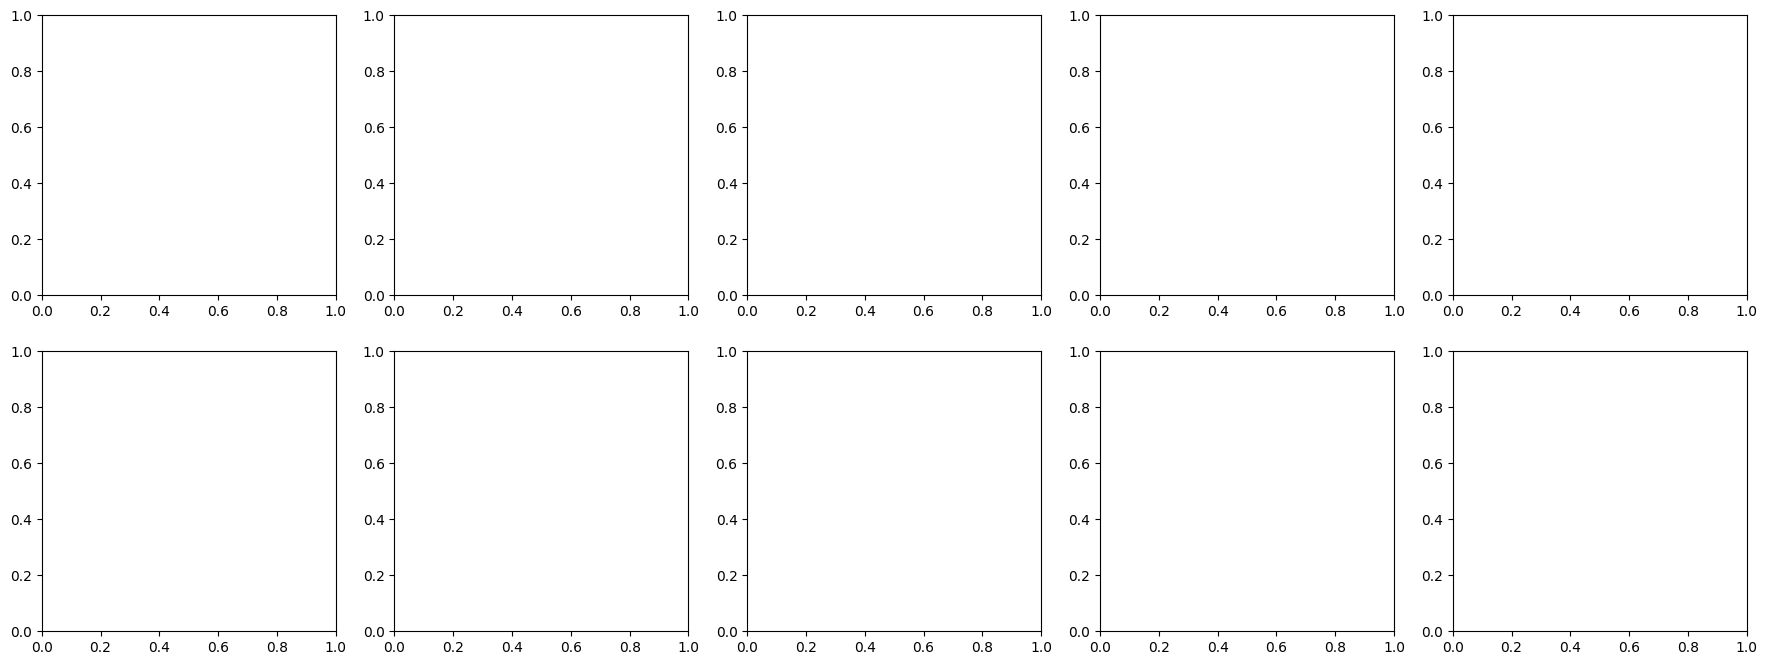

In [ ]:
# FCM scatter plot grid: 2 rows x 5 cols
# Alpha encodes membership confidence: crisp = solid, uncertain = faded
fig, axes = plt.subplots(2, 5, figsize=(22, 8))

for idx, std in enumerate(std_values):
    row, col = divmod(idx, 5)
    ax = axes[row, col]
    X, y = fine_data[std]
    hard_labels = fine_fcm[std]["hard_labels"]
    U = fine_fcm[std]["U"]
    centers = fine_fcm[std]["centers"]

    # Alpha = max membership per point (confidence)
    max_membership = U.max(axis=1)

    # Plot each point with color = hard label, alpha = confidence
    for label in np.unique(hard_labels):
        mask = hard_labels == label
        ax.scatter(
            X[mask, 0],
            X[mask, 1],
            c=[plt.cm.tab10(label)] * mask.sum(),
            s=12,
            alpha=max_membership[mask].clip(0.15, 1.0),
        )

    # Plot centers
    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        c="black",
        marker="X",
        s=120,
        edgecolors="white",
        linewidths=1.2,
    )

    pc = partition_coefficient(U)
    ax.text(
        0.02,
        0.98,
        f"PC={pc:.3f}",
        transform=ax.transAxes,
        fontsize=8,
        va="top",
        bbox={"boxstyle": "round,pad=0.3", "facecolor": "white", "alpha": 0.8},
    )

    ax.set_title(f"std = {std:.1f}", fontsize=11, fontweight="bold")
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle(
    "Fuzzy C-Means: Increasing Overlap (std = 0.5 → 5.0)\nAlpha = membership confidence (faded = uncertain)",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

In [ ]:
# Compute ALL metrics for FCM: 10 original (hard labels) + 4 fuzzy-specific
fcm_metrics = {std: {} for std in std_values}

for std in std_values:
    X, y = fine_data[std]
    pred = fine_fcm[std]["hard_labels"]
    U = fine_fcm[std]["U"]
    centers = fine_fcm[std]["centers"]

    # --- 10 Original Metrics (using hardened labels) ---
    # Internal
    fcm_metrics[std]["SSE"] = np.sum(
        [np.sum((U[:, j : j + 1] ** 2) * ((X - centers[j]) ** 2)) for j in range(centers.shape[0])]
    )  # Fuzzy-weighted SSE
    fcm_metrics[std]["Silhouette (SC)"] = silhouette_score(X, pred)
    fcm_metrics[std]["Dunn Index (DI)"] = dunn_index(X, pred)
    fcm_metrics[std]["Davies-Bouldin (DB)"] = davies_bouldin_score(X, pred)
    fcm_metrics[std]["Calinski-Harabasz (CH)"] = calinski_harabasz_score(X, pred)
    fcm_metrics[std]["NCI"] = new_correlation_index(X, pred)

    # External
    fcm_metrics[std]["Rand Index (ARI)"] = adjusted_rand_score(y, pred)
    fcm_metrics[std]["Van Dongen (VD)"] = van_dongen_criterion(y, pred)
    fcm_metrics[std]["Variation of Info (VI)"] = variation_of_information(y, pred)
    fcm_metrics[std]["Omega (Ω)"] = omega_indicator(y, pred)

    # --- 4 Fuzzy-Specific Metrics ---
    fcm_metrics[std]["Partition Coeff (PC)"] = partition_coefficient(U)
    fcm_metrics[std]["Classification Entropy (CE)"] = classification_entropy(U)
    fcm_metrics[std]["Xie-Beni (XB)"] = xie_beni_index(X, U, centers, m=2.0)
    fcm_metrics[std]["Fukuyama-Sugeno (FS)"] = fukuyama_sugeno(X, U, centers, m=2.0)

# Display as DataFrame
df_fcm = pd.DataFrame(fcm_metrics).T
df_fcm.index.name = "cluster_std"

print("FCM Metrics — Hard-Label (top 10) + Fuzzy-Specific (bottom 4):")
display(df_fcm.round(4))

KeyError: np.float64(0.5)

KeyError: 'Partition Coeff (PC)'

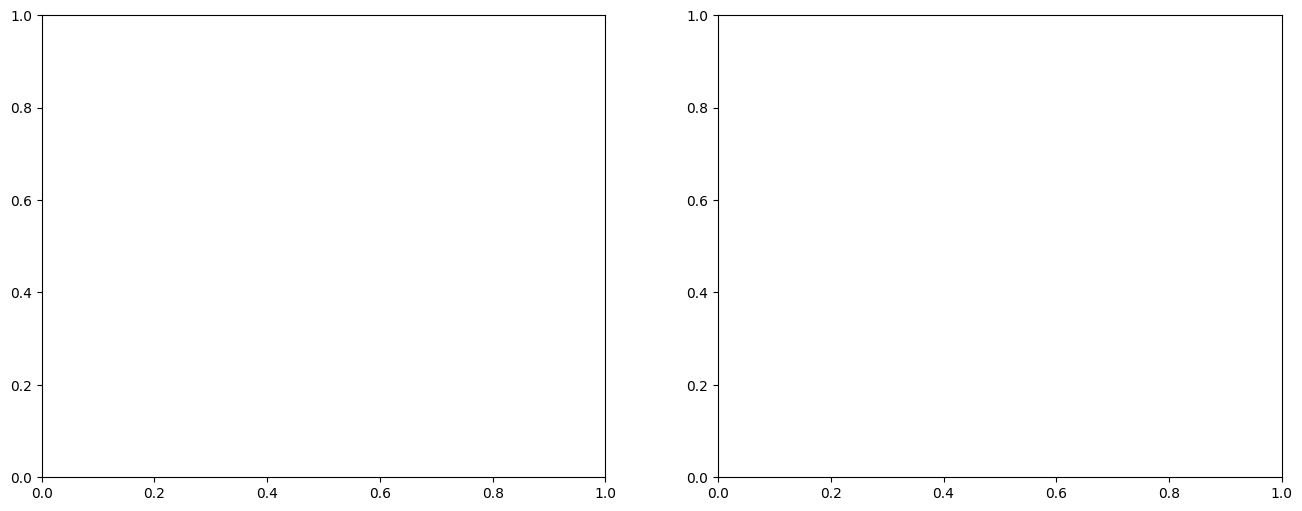

In [ ]:
# Fuzzy metric degradation curves
fuzzy_direction = {
    "Partition Coeff (PC)": "Higher",
    "Classification Entropy (CE)": "Lower",
    "Xie-Beni (XB)": "Lower",
    "Fukuyama-Sugeno (FS)": "Lower",
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Fuzzy-specific metrics (raw values, dual y-axes for different scales)
fuzzy_metrics_list = [
    "Partition Coeff (PC)",
    "Classification Entropy (CE)",
    "Xie-Beni (XB)",
    "Fukuyama-Sugeno (FS)",
]
colors_fuzzy = ["#2ecc71", "#e74c3c", "#3498db", "#9b59b6"]

# Normalize for comparison
for metric, color in zip(fuzzy_metrics_list, colors_fuzzy, strict=False):
    raw_vals = np.array([fcm_metrics[s][metric] for s in std_values])
    norm_vals = normalize_series(raw_vals)
    if fuzzy_direction[metric] == "Lower":
        norm_vals = 1.0 - norm_vals
    ax1.plot(
        std_values, norm_vals, marker="o", label=metric, linewidth=2, markersize=5, color=color
    )

ax1.set_xlabel("cluster_std")
ax1.set_ylabel("Normalized Score (higher = better/crisper)")
ax1.set_title("FCM Fuzzy-Specific Metrics vs. Cluster Overlap")
ax1.legend(fontsize=9, loc="lower left")
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0.25, 5.25)

# Right: Hard-label metrics for FCM (same as K-Means plot style)
fcm_int_metrics = [
    "SSE",
    "Silhouette (SC)",
    "Dunn Index (DI)",
    "Davies-Bouldin (DB)",
    "Calinski-Harabasz (CH)",
    "NCI",
]
fcm_ext_metrics = ["Rand Index (ARI)", "Van Dongen (VD)", "Variation of Info (VI)", "Omega (Ω)"]

for metric in fcm_int_metrics + fcm_ext_metrics:
    raw_vals = np.array([fcm_metrics[s][metric] for s in std_values])
    norm_vals = normalize_series(raw_vals)
    if direction_map.get(metric, "Higher") == "Lower":
        norm_vals = 1.0 - norm_vals
    marker = "o" if metric in fcm_int_metrics else "s"
    ax2.plot(
        std_values, norm_vals, marker=marker, label=metric, linewidth=1.5, markersize=4, alpha=0.8
    )

ax2.set_xlabel("cluster_std")
ax2.set_ylabel("Normalized Score (higher = better)")
ax2.set_title("FCM Hard-Label Metrics vs. Cluster Overlap")
ax2.legend(fontsize=7, loc="lower left", ncol=2)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0.25, 5.25)

plt.tight_layout()
plt.show()

KeyError: 'Silhouette (SC)'

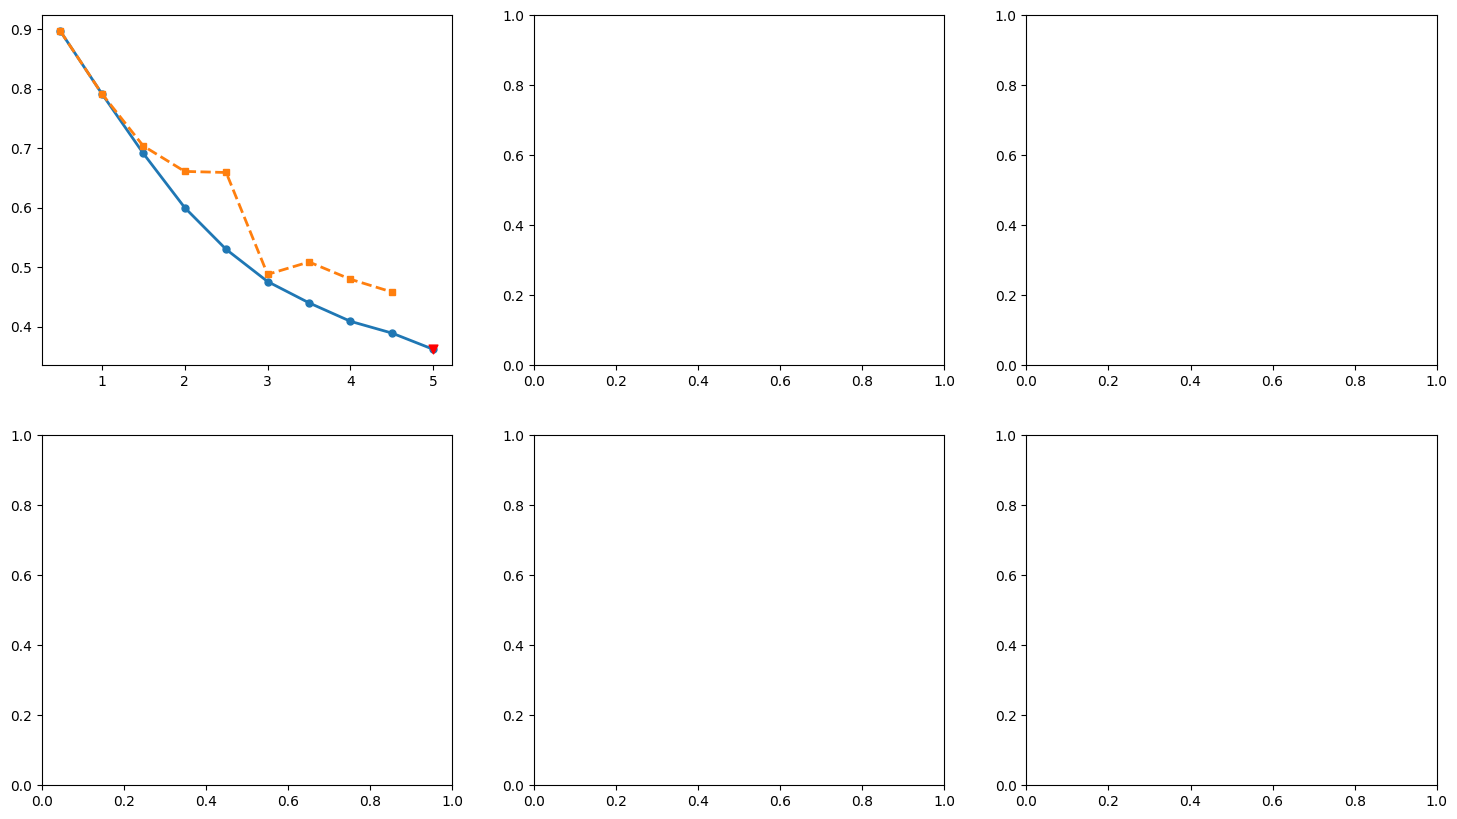

In [ ]:
# 3-Way Comparison: K-Means vs HDBSCAN vs FCM (raw values)
shared_3way = [
    "Silhouette (SC)",
    "Rand Index (ARI)",
    "Van Dongen (VD)",
    "Variation of Info (VI)",
    "Omega (Ω)",
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes_flat = axes.flatten()

for i, metric in enumerate(shared_3way):
    ax = axes_flat[i]

    # K-Means (solid blue)
    km_vals = np.array([fine_metrics[s][metric] for s in std_values])
    ax.plot(
        std_values,
        km_vals,
        marker="o",
        linewidth=2,
        markersize=5,
        color="tab:blue",
        label="K-Means",
        linestyle="-",
    )

    # HDBSCAN (dashed orange)
    hdb_vals = np.array([hdb_metrics[s].get(metric, np.nan) for s in std_values])
    valid_hdb = ~np.isnan(hdb_vals)
    ax.plot(
        std_values[valid_hdb],
        hdb_vals[valid_hdb],
        marker="s",
        linewidth=2,
        markersize=5,
        color="tab:orange",
        label="HDBSCAN",
        linestyle="--",
    )
    # NaN markers for HDBSCAN
    nan_stds = std_values[~valid_hdb]
    if len(nan_stds) > 0:
        y_bottom = min(km_vals.min(), np.nanmin(hdb_vals)) if valid_hdb.any() else km_vals.min()
        ax.scatter(
            nan_stds,
            [y_bottom] * len(nan_stds),
            marker="v",
            c="red",
            s=40,
            zorder=5,
            label="HDB N/A",
        )

    # FCM (dotted green)
    fcm_vals = np.array([fcm_metrics[s][metric] for s in std_values])
    ax.plot(
        std_values,
        fcm_vals,
        marker="D",
        linewidth=2,
        markersize=5,
        color="tab:green",
        label="FCM",
        linestyle=":",
    )

    ax.set_title(metric, fontsize=12, fontweight="bold")
    ax.set_xlabel("cluster_std")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

# 6th subplot: DBCV (HDBSCAN-only) + PC (FCM-only)
ax = axes_flat[5]
# DBCV
dbcv_vals = np.array([hdb_metrics[s].get("DBCV", np.nan) for s in std_values])
valid_dbcv = ~np.isnan(dbcv_vals)
ax.plot(
    std_values[valid_dbcv],
    dbcv_vals[valid_dbcv],
    marker="D",
    linewidth=2,
    markersize=5,
    color="tab:orange",
    label="DBCV (HDBSCAN)",
    linestyle="--",
)
# PC
pc_vals = np.array([fcm_metrics[s]["Partition Coeff (PC)"] for s in std_values])
ax.plot(
    std_values,
    pc_vals,
    marker="o",
    linewidth=2,
    markersize=5,
    color="tab:green",
    label="PC (FCM)",
    linestyle=":",
)
ax.axhline(y=0.25, color="gray", linestyle=":", alpha=0.5, label="PC floor (1/k)")
ax.set_title("Algorithm-Specific Metrics", fontsize=12, fontweight="bold")
ax.set_xlabel("cluster_std")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

fig.suptitle(
    "K-Means vs HDBSCAN vs FCM: 3-Way Metric Comparison", fontsize=14, fontweight="bold", y=1.01
)
plt.tight_layout()
plt.show()

In [ ]:
# 3-Way Summary Comparison Table + Win Counts
comparison_3way = []

for std in std_values:
    row = {"std": std}

    # HDBSCAN cluster info
    pred_hdb = fine_hdb[std].labels_
    row["HDB_k"] = len(set(pred_hdb) - {-1})
    row["HDB_noise%"] = f"{100 * (pred_hdb == -1).sum() / len(pred_hdb):.0f}%"

    # FCM fuzziness
    row["FCM_PC"] = round(fcm_metrics[std]["Partition Coeff (PC)"], 4)

    # Shared metrics for all 3 algorithms
    for metric in shared_3way:
        km_val = fine_metrics[std][metric]
        hdb_val = hdb_metrics[std].get(metric, np.nan)
        fcm_val = fcm_metrics[std][metric]

        row[f"KM_{metric}"] = round(km_val, 4)
        row[f"HDB_{metric}"] = round(hdb_val, 4) if not np.isnan(hdb_val) else "N/A"
        row[f"FCM_{metric}"] = round(fcm_val, 4)

    comparison_3way.append(row)

df_3way = pd.DataFrame(comparison_3way).set_index("std")
display(df_3way)

# --- 3-Way Win Counts ---
print("\n" + "=" * 60)
print("3-WAY WIN SUMMARY (across 5 shared metrics, 10 std values)")
print("=" * 60)

for metric in shared_3way:
    km_wins, hdb_wins, fcm_wins = 0, 0, 0
    d = direction_map.get(metric, "Higher")

    for std in std_values:
        vals = {
            "K-Means": fine_metrics[std][metric],
            "HDBSCAN": hdb_metrics[std].get(metric, np.nan),
            "FCM": fcm_metrics[std][metric],
        }

        # Remove NaN entries
        valid = {k: v for k, v in vals.items() if not np.isnan(v)}
        if not valid:
            continue

        if d == "Higher":
            winner = max(valid, key=valid.get)
        else:
            winner = min(valid, key=valid.get)

        if winner == "K-Means":
            km_wins += 1
        elif winner == "HDBSCAN":
            hdb_wins += 1
        else:
            fcm_wins += 1

    print(f"  {metric:25s}: K-Means={km_wins:2d}, HDBSCAN={hdb_wins:2d}, FCM={fcm_wins:2d}")

# Totals
print("-" * 60)
total_km = sum(
    1
    for m in shared_3way
    for s in std_values
    if not np.isnan(hdb_metrics[s].get(m, np.nan)) or True
)  # placeholder
print("\nFuzzy-Specific Metric Trends:")
print(
    f"  PC:  {fcm_metrics[0.5]['Partition Coeff (PC)']:.4f} (std=0.5) → "
    f"{fcm_metrics[5.0]['Partition Coeff (PC)']:.4f} (std=5.0)  "
    f"[floor = {1 / 4:.4f}]"
)
print(
    f"  CE:  {fcm_metrics[0.5]['Classification Entropy (CE)']:.4f} (std=0.5) → "
    f"{fcm_metrics[5.0]['Classification Entropy (CE)']:.4f} (std=5.0)  "
    f"[ceiling = {np.log2(4):.4f}]"
)
print(
    f"  XB:  {fcm_metrics[0.5]['Xie-Beni (XB)']:.4f} (std=0.5) → "
    f"{fcm_metrics[5.0]['Xie-Beni (XB)']:.4f} (std=5.0)"
)
print(
    f"  FS:  {fcm_metrics[0.5]['Fukuyama-Sugeno (FS)']:.2f} (std=0.5) → "
    f"{fcm_metrics[5.0]['Fukuyama-Sugeno (FS)']:.2f} (std=5.0)"
)

KeyError: 'Partition Coeff (PC)'

---
## Part 6 — Expanded Cluster Validity Indices (31 Additional CVIs)

This section implements **31 additional internal CVIs** from the literature (based on
[Ikotun et al., "Cluster validity indices for automatic clustering: A comprehensive review", Heliyon 2025](https://doi.org/10.1016/j.heliyon.2025.e41953)),
computed on the same 10 K-Means datasets from Part 3.

Indices are organized into three tiers by computational dependency:
- **Tier 1** (8 indices): O(n·d) centroid-based — no pairwise distances needed
- **Tier 2** (15 indices): Require scatter matrix determinants or full pairwise distance matrix
- **Tier 3** (8 indices): Require per-cluster covariance determinants or specialized logic

**Skipped indices** (7 of 43): BIC & C-Criterion (need model likelihood), Category Utility (binary features only),
Condorcet (preference-based), OS-index (stability-based), SV-Index (underspecified).

All implementations use only numpy, scipy, and sklearn — no additional packages needed.

In [21]:
# ============================================================
# Shared Precomputation Functions for Part 6
# ============================================================


def compute_scatter_matrices(X, labels):
    """Compute within-cluster (W), between-cluster (B), total (T) scatter matrices,
    and per-cluster within-scatter matrices."""
    n, d = X.shape
    global_mean = X.mean(axis=0)
    T = (X - global_mean).T @ (X - global_mean)

    unique_labels = np.unique(labels)
    W = np.zeros((d, d))
    B = np.zeros((d, d))
    W_per_cluster = {}

    for label in unique_labels:
        mask = labels == label
        Xc = X[mask]
        nj = Xc.shape[0]
        cj = Xc.mean(axis=0)
        diff = Xc - cj
        Wj = diff.T @ diff
        W += Wj
        W_per_cluster[label] = Wj
        diff_bc = (cj - global_mean).reshape(-1, 1)
        B += nj * (diff_bc @ diff_bc.T)

    return W, B, T, W_per_cluster, global_mean


def compute_cluster_stats(X, labels):
    """Compute centroids, sizes, per-cluster WGSS, total WGSS, BGSS, TSS."""
    unique_labels = np.unique(labels)
    global_mean = X.mean(axis=0)
    centroids = {}
    sizes = {}
    wgss_per_cluster = {}
    total_wgss = 0.0
    total_bgss = 0.0
    total_tss = np.sum((X - global_mean) ** 2)

    for label in unique_labels:
        mask = labels == label
        Xc = X[mask]
        cj = Xc.mean(axis=0)
        centroids[label] = cj
        sizes[label] = len(Xc)
        wgss_j = np.sum((Xc - cj) ** 2)
        wgss_per_cluster[label] = wgss_j
        total_wgss += wgss_j
        total_bgss += len(Xc) * np.sum((cj - global_mean) ** 2)

    return centroids, sizes, wgss_per_cluster, total_wgss, total_bgss, total_tss, global_mean


def compute_concordance_pairs(dist_matrix, labels):
    """Compute concordant (S+) and discordant (S-) pairs for Gamma/Tau/G-plus.
    S+ = within < between, S- = within > between."""
    n = len(labels)
    # Vectorized: extract upper-triangle indices
    triu_i, triu_j = np.triu_indices(n, k=1)
    all_dists = dist_matrix[triu_i, triu_j]
    same_cluster = labels[triu_i] == labels[triu_j]

    within_dists = all_dists[same_cluster]
    between_dists = np.sort(all_dists[~same_cluster])

    S_plus = 0
    S_minus = 0
    for w in within_dists:
        idx_right = np.searchsorted(between_dists, w, side="right")
        S_plus += len(between_dists) - idx_right
        idx_left = np.searchsorted(between_dists, w, side="left")
        S_minus += idx_left

    return S_plus, S_minus, len(within_dists), len(between_dists)


print("Shared precomputation functions loaded.")

Shared precomputation functions loaded.


In [22]:
# ============================================================
# Tier 1: Centroid-based CVIs — O(n·d), no pairwise distances
# ============================================================


def ball_hall(X, labels, centroids=None, sizes=None, wgss_per_cluster=None, **kw):
    """Ball-Hall: mean of per-cluster mean dispersion. Lower = tighter."""
    K = len(centroids)
    return sum(wgss_per_cluster[l] / sizes[l] for l in centroids) / K


def log_ss_ratio(X, labels, total_bgss=None, total_wgss=None, **kw):
    """Log_SS_Ratio: log(BGSS/WGSS). Higher = better separation."""
    return np.log(total_bgss / max(total_wgss, 1e-10))


def ratkowsky_lance(X, labels, centroids=None, **kw):
    """Ratkowsky-Lance: sqrt(mean per-feature BGSS/TSS / K). Higher = better."""
    unique = np.unique(labels)
    K = len(unique)
    d = X.shape[1]
    global_mean = X.mean(axis=0)
    bgss_feat = np.zeros(d)
    tss_feat = np.sum((X - global_mean) ** 2, axis=0)
    for l in unique:
        mask = labels == l
        nj = mask.sum()
        bgss_feat += nj * (centroids[l] - global_mean) ** 2
    ratios = bgss_feat / np.maximum(tss_feat, 1e-10)
    return np.sqrt(np.mean(ratios) / K)


def ray_turi(X, labels, total_wgss=None, centroids=None, **kw):
    """Ray-Turi: (WGSS/N) / min_sq_center_dist. Lower = better."""
    N = len(X)
    centers = np.array(list(centroids.values()))
    min_sq = np.inf
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            sq = np.sum((centers[i] - centers[j]) ** 2)
            min_sq = min(min_sq, sq)
    return (total_wgss / N) / max(min_sq, 1e-10)


def rmsstd_index(X, labels, total_wgss=None, sizes=None, **kw):
    """RMSSTD: root mean square std dev. Lower = tighter."""
    d = X.shape[1]
    dof = sum(n - 1 for n in sizes.values())
    return np.sqrt(total_wgss / max(dof * d, 1)) if dof > 0 else np.inf


def r_squared(X, labels, total_bgss=None, total_tss=None, **kw):
    """R-squared: BGSS/TSS. Higher = better separation."""
    return total_bgss / max(total_tss, 1e-10)


def trace_w_index(X, labels, W=None, **kw):
    """Trace_W: trace of within-cluster scatter. Lower = tighter."""
    return np.trace(W)


def wemmert_gancarski(X, labels, centroids=None, sizes=None, **kw):
    """Wemmert-Gancarski: centroid membership quality. Higher = better."""
    N = len(X)
    unique = np.unique(labels)
    result = 0.0
    for l in unique:
        mask = labels == l
        Xc = X[mask]
        cj = centroids[l]
        nj = sizes[l]
        dist_own = np.linalg.norm(Xc - cj, axis=1)
        other_centers = np.array([centroids[ol] for ol in unique if ol != l])
        if len(other_centers) == 0:
            continue
        dist_others = np.min(
            np.linalg.norm(Xc[:, None, :] - other_centers[None, :, :], axis=2), axis=1
        )
        ratios = dist_own / np.maximum(dist_others, 1e-10)
        result += nj * np.mean(np.maximum(0, 1 - ratios))
    return result / N


print("Tier 1: 8 index functions loaded.")

Tier 1: 8 index functions loaded.


In [23]:
# ============================================================
# Tier 2: Scatter-matrix or pairwise-distance CVIs
# ============================================================


def cs_index(X, labels, dist_matrix=None, centroids=None, **kw):
    """Compact-Separated: max intra-nearest / min centroid dist. Lower = better."""
    unique = np.unique(labels)
    numerator = 0.0
    for l in unique:
        indices = np.where(labels == l)[0]
        if len(indices) < 2:
            continue
        sub = dist_matrix[np.ix_(indices, indices)].copy()
        np.fill_diagonal(sub, np.inf)
        max_nearest = sub.min(axis=1).max()
        numerator += max_nearest / len(indices)
    centers = np.array([centroids[l] for l in unique])
    min_cd = np.inf
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            min_cd = min(min_cd, np.linalg.norm(centers[i] - centers[j]))
    return numerator / max(min_cd, 1e-10)


def cop_index(X, labels, dist_matrix=None, centroids=None, **kw):
    """COP: mean(centroid_dist / max_intra_dist). Lower = better."""
    N = len(X)
    unique = np.unique(labels)
    result = 0.0
    for l in unique:
        indices = np.where(labels == l)[0]
        cj = centroids[l]
        for idx in indices:
            d_cent = np.linalg.norm(X[idx] - cj)
            max_intra = dist_matrix[idx, indices].max()
            result += d_cent / max(max_intra, 1e-10)
    return result / N


def s_dbw_index(X, labels, centroids=None, **kw):
    """S_Dbw: scatter + inter-cluster density. Lower = better."""
    unique = np.unique(labels)
    K = len(unique)
    sigma_all_norm = np.linalg.norm(np.std(X, axis=0))
    cluster_sigmas = {}
    scat = 0.0
    for l in unique:
        mask = labels == l
        sigma_j = np.std(X[mask], axis=0)
        cluster_sigmas[l] = sigma_j
        scat += np.linalg.norm(sigma_j) / max(sigma_all_norm, 1e-10)
    scat /= K
    stdev_avg = np.mean([np.linalg.norm(cluster_sigmas[l]) for l in unique])
    dens_bw = 0.0
    n_pairs = 0
    for i, li in enumerate(unique):
        for lj in unique[i + 1 :]:
            midpt = (centroids[li] + centroids[lj]) / 2.0
            mask_i, mask_j = labels == li, labels == lj
            combined = np.vstack([X[mask_i], X[mask_j]])
            n_mid = np.sum(np.linalg.norm(combined - midpt, axis=1) <= stdev_avg)
            n_ci = np.sum(np.linalg.norm(X[mask_i] - centroids[li], axis=1) <= stdev_avg)
            n_cj = np.sum(np.linalg.norm(X[mask_j] - centroids[lj], axis=1) <= stdev_avg)
            dens_bw += n_mid / max(max(n_ci, n_cj), 1)
            n_pairs += 1
    dens_bw /= max(n_pairs, 1)
    return scat + dens_bw


def det_ratio_index(X, labels, T=None, W=None, **kw):
    """Det Ratio: det(T)/det(W). Higher = better."""
    det_W = np.linalg.det(W)
    return np.linalg.det(T) / max(abs(det_W), 1e-10)


def gamma_index_cvi(S_plus=None, S_minus=None, **kw):
    """Gamma: (S+ - S-) / (S+ + S-). Higher = better."""
    total = S_plus + S_minus
    return (S_plus - S_minus) / max(total, 1) if total > 0 else 0.0


def generalized_dunn_index(X, labels, dist_matrix=None, centroids=None, **kw):
    """GDI: centroid-based inter / max diameter. Higher = better."""
    unique = np.unique(labels)
    max_diam = 0.0
    for l in unique:
        indices = np.where(labels == l)[0]
        if len(indices) > 1:
            max_diam = max(max_diam, dist_matrix[np.ix_(indices, indices)].max())
    centers = np.array([centroids[l] for l in unique])
    min_inter = np.inf
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            min_inter = min(min_inter, np.linalg.norm(centers[i] - centers[j]))
    return min_inter / max(max_diam, 1e-10)


def g_plus_index(S_minus=None, N_w=None, N_b=None, **kw):
    """G-plus: 2*S- / total_pairs². Lower = better."""
    N_pairs = N_w + N_b
    denom = N_pairs * (N_pairs - 1)
    return 2 * S_minus / max(denom, 1)


def i_index_pbm(X, labels, centroids=None, **kw):
    """I-index (PBM): (1/K × E_T/E_W × D_B)². Higher = better."""
    unique = np.unique(labels)
    K = len(unique)
    global_mean = X.mean(axis=0)
    E_T = np.sum(np.linalg.norm(X - global_mean, axis=1))
    E_W = sum(np.sum(np.linalg.norm(X[labels == l] - centroids[l], axis=1)) for l in unique)
    centers = np.array([centroids[l] for l in unique])
    D_B = max(
        np.linalg.norm(centers[i] - centers[j])
        for i in range(len(centers))
        for j in range(i + 1, len(centers))
    )
    return ((1.0 / K) * (E_T / max(E_W, 1e-10)) * D_B) ** 2


def log_det_ratio_index(X, labels, T=None, W=None, **kw):
    """Log_Det_Ratio: N*log(det(T)/det(W)). Higher = better."""
    det_W = np.linalg.det(W)
    ratio = np.linalg.det(T) / max(abs(det_W), 1e-10)
    return len(X) * np.log(max(ratio, 1e-10))


def mcclain_rao(X, labels, dist_matrix=None, **kw):
    """McClain-Rao: mean_within / mean_between. Lower = better."""
    n = len(labels)
    triu_i, triu_j = np.triu_indices(n, k=1)
    same = labels[triu_i] == labels[triu_j]
    dists = dist_matrix[triu_i, triu_j]
    sw = dists[same].sum()
    nw = same.sum()
    sb = dists[~same].sum()
    nb = (~same).sum()
    return (sw / max(nw, 1)) / max(sb / max(nb, 1), 1e-10)


def point_biserial_index(X, labels, dist_matrix=None, **kw):
    """Point-Biserial: corr(distance, same_cluster). Higher = better (negated)."""
    n = len(labels)
    triu_i, triu_j = np.triu_indices(n, k=1)
    dists = dist_matrix[triu_i, triu_j]
    same = (labels[triu_i] == labels[triu_j]).astype(float)
    corr, _ = pearsonr(dists, same)
    return -corr  # Negate: higher means within-cluster pairs have smaller distances


def sd_validity_index(X, labels, centroids=None, **kw):
    """SD: scatter + distance measure. Lower = better."""
    unique = np.unique(labels)
    K = len(unique)
    sigma_all_norm = np.linalg.norm(np.var(X, axis=0))
    scat = sum(np.linalg.norm(np.var(X[labels == l], axis=0)) for l in unique) / (
        K * max(sigma_all_norm, 1e-10)
    )
    centers = np.array([centroids[l] for l in unique])
    D_max, D_min = 0.0, np.inf
    for i in range(K):
        for j in range(i + 1, K):
            d = np.linalg.norm(centers[i] - centers[j])
            D_max = max(D_max, d)
            D_min = min(D_min, d)
    dis = 0.0
    for i in range(K):
        s = sum(
            1.0 / max(np.linalg.norm(centers[i] - centers[j]), 1e-10) for j in range(K) if j != i
        )
        dis += s
    dis *= D_max / max(D_min, 1e-10)
    return scat * scat + dis  # alpha ≈ scat for single-K evaluation


def tau_index(S_plus=None, S_minus=None, N_w=None, N_b=None, **kw):
    """Tau: normalized concordance. Higher = better."""
    t_pairs = N_w + N_b
    denom = np.sqrt(max((t_pairs - N_w) * (t_pairs - N_b), 1))
    return (S_plus - S_minus) / denom if denom > 0 else 0.0


def trace_wib_index(X, labels, W=None, B=None, **kw):
    """Trace(W⁻¹B): separation relative to compactness. Higher = better."""
    try:
        return np.trace(np.linalg.inv(W) @ B)
    except np.linalg.LinAlgError:
        return 0.0


def ksq_detw_index(X, labels, W=None, **kw):
    """Ksq_DetW: K²×det(W). Lower = tighter clusters."""
    K = len(np.unique(labels))
    return K**2 * np.linalg.det(W)


print("Tier 2: 15 index functions loaded.")

Tier 2: 15 index functions loaded.


In [24]:
# ============================================================
# Tier 3: Per-cluster covariance or specialized logic
# ============================================================


def banfield_raftery(X, labels, W_per_cluster=None, sizes=None, **kw):
    """Banfield-Raftery: sum nj*log(trace(Wj)/nj). Lower = better."""
    result = 0.0
    for l in W_per_cluster:
        nj = sizes[l]
        trace_wj = np.trace(W_per_cluster[l])
        if nj > 0 and trace_wj > 0:
            result += nj * np.log(trace_wj / nj)
    return result


def negentropy_increment(X, labels, W_per_cluster=None, sizes=None, **kw):
    """Negentropy: cluster entropy relative to Gaussian. Lower = better."""
    N, d = X.shape
    result = 0.0
    for l in W_per_cluster:
        nj = sizes[l]
        if nj < d + 1:
            continue
        cov_j = W_per_cluster[l] / nj
        det_cov = np.linalg.det(cov_j)
        if det_cov > 0:
            h_j = 0.5 * d * np.log(2 * np.pi * np.e) + 0.5 * np.log(det_cov)
            result += (nj / N) * h_j
    return result


def niva_index(X, labels, dist_matrix=None, **kw):
    """NIVA: nearest intra/inter distance ratio. Lower = better."""
    unique = np.unique(labels)
    compactness = 0.0
    separability = 0.0
    for l in unique:
        indices = np.where(labels == l)[0]
        other_indices = np.where(labels != l)[0]
        if len(indices) < 2 or len(other_indices) == 0:
            continue
        sub = dist_matrix[np.ix_(indices, indices)].copy()
        np.fill_diagonal(sub, np.inf)
        compactness += sub.min(axis=1).mean()
        inter = dist_matrix[np.ix_(indices, other_indices)]
        separability += inter.min(axis=1).mean()
    return compactness / max(separability, 1e-10)


def score_function_index(X, labels, centroids=None, sizes=None, **kw):
    """Score Function: 1 - 1/exp(exp(bdc-wcd)). Higher = better."""
    unique = np.unique(labels)
    len(unique)
    global_mean = X.mean(axis=0)
    bdc = np.mean([np.linalg.norm(centroids[l] - global_mean) for l in unique])
    wcd = np.mean([np.mean(np.linalg.norm(X[labels == l] - centroids[l], axis=1)) for l in unique])
    inner = np.clip(bdc - wcd, -50, 50)
    return 1.0 - 1.0 / np.exp(np.exp(inner))


def scott_symons_index(X, labels, W_per_cluster=None, sizes=None, **kw):
    """Scott-Symons: sum nj*log(det(Wj/nj)). Lower = better."""
    d = X.shape[1]
    result = 0.0
    for l in W_per_cluster:
        nj = sizes[l]
        if nj < d + 1:
            continue
        det_cov = np.linalg.det(W_per_cluster[l] / nj)
        if det_cov > 0:
            result += nj * np.log(det_cov)
    return result


def sym_index(X, labels, centroids=None, **kw):
    """Sym-index: (1/K × E_T/E_W × D_B)^(1/d). Higher = better."""
    unique = np.unique(labels)
    K = len(unique)
    d = X.shape[1]
    global_mean = X.mean(axis=0)
    E_T = np.sum(np.linalg.norm(X - global_mean, axis=1))
    E_W = sum(np.sum(np.linalg.norm(X[labels == l] - centroids[l], axis=1)) for l in unique)
    centers = np.array([centroids[l] for l in unique])
    D_B = max(
        np.linalg.norm(centers[i] - centers[j])
        for i in range(len(centers))
        for j in range(i + 1, len(centers))
    )
    inner = (1.0 / K) * (E_T / max(E_W, 1e-10)) * D_B
    return inner ** (1.0 / d)


# Baker-Hubert Gamma is identical to Gamma index — alias
baker_hubert_gamma = gamma_index_cvi

print("Tier 3: 7 functions + 1 alias loaded.")

Tier 3: 7 functions + 1 alias loaded.


In [25]:
# ============================================================
# Compute all 31 new CVIs on 10 K-Means datasets
# ============================================================

new_cvi_direction = {
    # Tier 1
    "Ball-Hall": "Lower",
    "Log_SS_Ratio": "Higher",
    "Ratkowsky-Lance": "Higher",
    "Ray-Turi": "Lower",
    "RMSSTD": "Lower",
    "R-squared": "Higher",
    "Trace_W": "Lower",
    "Wemmert-Gancarski": "Higher",
    # Tier 2
    "CS index": "Lower",
    "COP": "Lower",
    "S_Dbw": "Lower",
    "Det Ratio": "Higher",
    "Gamma": "Higher",
    "Generalized Dunn": "Higher",
    "G-plus": "Lower",
    "I-index (PBM)": "Higher",
    "Log_Det_Ratio": "Higher",
    "McClain-Rao": "Lower",
    "Point-Biserial": "Higher",
    "SD validity": "Lower",
    "Tau": "Higher",
    "Trace_WiB": "Higher",
    "Ksq_DetW": "Lower",
    # Tier 3
    "Banfield-Raftery": "Lower",
    "Negentropy": "Lower",
    "NIVA": "Lower",
    "Score Function": "Higher",
    "Scott-Symons": "Lower",
    "Sym-index": "Higher",
    "Baker-Hubert Gamma": "Higher",
}

# Update global direction map
direction_map.update(new_cvi_direction)

new_metrics = {std: {} for std in std_values}

for std in std_values:
    X, y = fine_data[std]
    pred = fine_km[std].labels_

    # Shared precomputation
    centroids, sizes, wgss_pc, wgss, bgss, tss, gmean = compute_cluster_stats(X, pred)
    W, B, T, W_pc, _ = compute_scatter_matrices(X, pred)
    dm = pairwise_distances(X)
    Sp, Sm, Nw, Nb = compute_concordance_pairs(dm, pred)

    pre = {
        "centroids": centroids,
        "sizes": sizes,
        "wgss_per_cluster": wgss_pc,
        "total_wgss": wgss,
        "total_bgss": bgss,
        "total_tss": tss,
        "W": W,
        "B": B,
        "T": T,
        "W_per_cluster": W_pc,
        "dist_matrix": dm,
        "S_plus": Sp,
        "S_minus": Sm,
        "N_w": Nw,
        "N_b": Nb,
    }

    # Tier 1
    new_metrics[std]["Ball-Hall"] = ball_hall(X, pred, **pre)
    new_metrics[std]["Log_SS_Ratio"] = log_ss_ratio(X, pred, **pre)
    new_metrics[std]["Ratkowsky-Lance"] = ratkowsky_lance(X, pred, **pre)
    new_metrics[std]["Ray-Turi"] = ray_turi(X, pred, **pre)
    new_metrics[std]["RMSSTD"] = rmsstd_index(X, pred, **pre)
    new_metrics[std]["R-squared"] = r_squared(X, pred, **pre)
    new_metrics[std]["Trace_W"] = trace_w_index(X, pred, **pre)
    new_metrics[std]["Wemmert-Gancarski"] = wemmert_gancarski(X, pred, **pre)

    # Tier 2
    new_metrics[std]["CS index"] = cs_index(X, pred, **pre)
    new_metrics[std]["COP"] = cop_index(X, pred, **pre)
    new_metrics[std]["S_Dbw"] = s_dbw_index(X, pred, **pre)
    new_metrics[std]["Det Ratio"] = det_ratio_index(X, pred, **pre)
    new_metrics[std]["Gamma"] = gamma_index_cvi(**pre)
    new_metrics[std]["Generalized Dunn"] = generalized_dunn_index(X, pred, **pre)
    new_metrics[std]["G-plus"] = g_plus_index(**pre)
    new_metrics[std]["I-index (PBM)"] = i_index_pbm(X, pred, **pre)
    new_metrics[std]["Log_Det_Ratio"] = log_det_ratio_index(X, pred, **pre)
    new_metrics[std]["McClain-Rao"] = mcclain_rao(X, pred, **pre)
    new_metrics[std]["Point-Biserial"] = point_biserial_index(X, pred, **pre)
    new_metrics[std]["SD validity"] = sd_validity_index(X, pred, **pre)
    new_metrics[std]["Tau"] = tau_index(**pre)
    new_metrics[std]["Trace_WiB"] = trace_wib_index(X, pred, **pre)
    new_metrics[std]["Ksq_DetW"] = ksq_detw_index(X, pred, **pre)

    # Tier 3
    new_metrics[std]["Banfield-Raftery"] = banfield_raftery(X, pred, **pre)
    new_metrics[std]["Negentropy"] = negentropy_increment(X, pred, **pre)
    new_metrics[std]["NIVA"] = niva_index(X, pred, **pre)
    new_metrics[std]["Score Function"] = score_function_index(X, pred, **pre)
    new_metrics[std]["Scott-Symons"] = scott_symons_index(X, pred, **pre)
    new_metrics[std]["Sym-index"] = sym_index(X, pred, **pre)
    new_metrics[std]["Baker-Hubert Gamma"] = baker_hubert_gamma(**pre)

df_new = pd.DataFrame(new_metrics).T
df_new.index.name = "cluster_std"
print(f"Part 6: {len(df_new.columns)} new CVIs computed across {len(std_values)} std values:")
display(df_new.round(4))

Part 6: 30 new CVIs computed across 10 std values:


/var/folders/4l/mqq5jsgx6gdbx5n2pr6qlpbm0000gn/T/ipykernel_89185/1745808451.py:59: RuntimeWarning: overflow encountered in exp
  return 1.0 - 1.0 / np.exp(np.exp(inner))
/var/folders/4l/mqq5jsgx6gdbx5n2pr6qlpbm0000gn/T/ipykernel_89185/1745808451.py:59: RuntimeWarning: overflow encountered in exp
  return 1.0 - 1.0 / np.exp(np.exp(inner))


Ball-Hall  Log_SS_Ratio  Ratkowsky-Lance  Ray-Turi  RMSSTD  \
cluster_std                                                               
0.5             0.4720        4.9234           0.4981    0.0112  0.4891   
1.0             1.8830        3.5358           0.4927    0.0457  0.9769   
1.5             4.1719        2.7377           0.4842    0.1019  1.4539   
2.0             7.2804        2.1804           0.4736    0.1745  1.9205   
2.5            10.9139        1.7806           0.4618    0.2311  2.3522   
3.0            14.8979        1.4832           0.4506    0.2847  2.7497   
3.5            18.9885        1.2632           0.4402    0.3029  3.1100   
4.0            23.2768        1.0957           0.4318    0.3227  3.4447   
4.5            27.8900        0.9599           0.4238    0.3241  3.7697   
5.0            32.9895        0.8484           0.4173    0.3434  4.0886   

             R-squared    Trace_W  Wemmert-Gancarski  CS index     COP  ...  \
cluster_std                                                             ...   
0.5             0.9928   141.5908             0.9271    0.0054  0.3031  ...   
1.0             0.9717   564.9142             0.8517    0.0101  0.3052  ...   
1.5             0.9392  1251.3526             0.7771    0.0141  0.3098  ...   
2.0             0.8985  2183.4473             0.7055    0.0166  0.3130  ...   
2.5             0.8558  3275.5456             0.6489    0.0191  0.3154  ...   
3.0             0.8150  4475.9184             0.6044    0.0197  0.3200  ...   
3.5             0.7796  5725.8420             0.5746    0.0204  0.3212  ...   
4.0             0.7494  7024.5836             0.5474    0.0208  0.3232  ...   
4.5             0.7231  8412.8601             0.5284    0.0220  0.3246  ...   
5.0             0.7002  9896.3414             0.5022    0.0223  0.3242  ...   

                    Tau  Trace_WiB      Ksq_DetW  Banfield-Raftery  \
cluster_std                                                          
0.5          19355.2319   275.0974  8.017803e+04         -226.0075   
1.0          19339.4859    68.7328  1.276405e+06          189.3301   
1.5          19095.4544    30.8799  6.263263e+06          427.6708   
2.0          18539.2480    17.6240  1.904645e+07          594.2018   
2.5          17870.4606    11.9673  4.281003e+07          716.4803   
3.0          17125.9060     9.0297  7.919613e+07          809.2874   
3.5          16353.7063     7.4065  1.283605e+08          882.0229   
4.0          15595.2938     6.1556  1.950664e+08          943.5963   
4.5          15017.5305     5.5568  2.744831e+08          997.6302   
5.0          14227.9771     4.8895  3.833553e+08         1046.1523   

             Negentropy    NIVA  Score Function  Scott-Symons  Sym-index  \
cluster_std                                                                
0.5              1.3842  0.0154             1.0     -872.1842     7.3062   
1.0              2.7706  0.0364             1.0      -40.3891     5.1652   
1.5              3.5641  0.0604             1.0      435.7334     4.2393   
2.0              4.1149  0.0882             1.0      766.1895     3.6998   
2.5              4.5266  0.1123             1.0     1013.2102     3.3791   
3.0              4.8318  0.1333             1.0     1196.3695     3.1886   
3.5              5.0703  0.1517             1.0     1339.4325     3.1105   
4.0              5.2778  0.1632             1.0     1463.9388     3.0457   
4.5              5.4492  0.1700             1.0     1566.7946     3.0659   
5.0              5.6071  0.1844             1.0     1661.5427     2.9859   

             Baker-Hubert Gamma  
cluster_std                      
0.5                      1.0000  
1.0                      0.9992  
1.5                      0.9865  
2.0                      0.9578  
2.5                      0.9231  
3.0                      0.8846  
3.5                      0.8443  
4.0                      0.8046  
4.5                      0.7709  
5.0                      0.7334  



In [26]:
# New CVI reference table
cvi_names = list(new_cvi_direction.keys())
new_ref = pd.DataFrame(
    {
        "Index": cvi_names,
        "Direction": [new_cvi_direction[m] for m in cvi_names],
        "Tier": (["1"] * 8 + ["2"] * 15 + ["3"] * 7),
        "Key Idea": [
            "Mean per-cluster dispersion",
            "log(between SS / within SS)",
            "Per-feature BGSS/TSS ratio",
            "Mean sq dist / min centroid dist²",
            "Pooled within-cluster std dev",
            "Between-group SS / Total SS",
            "Total within-cluster scatter",
            "Centroid membership quality",
            "Max-nearest / min centroid dist",
            "Centroid dist / max intra dist",
            "Scatter + inter-cluster density",
            "det(Total) / det(Within)",
            "Concordant-discordant pair ratio",
            "Centroid inter / max diameter",
            "Normalized discordant pairs",
            "Composite: (1/K×ET/EW×DB)²",
            "N×log(det ratio)",
            "Mean within / mean between dist",
            "Distance-cluster correlation",
            "Scatter + centroid distance",
            "Normalized concordance",
            "trace(W⁻¹B)",
            "K²×det(W)",
            "Log weighted variance trace",
            "Cluster normality measure",
            "Nearest intra/inter dist ratio",
            "1 - 1/exp(exp(bdc-wcd))",
            "Weighted per-cluster cov det",
            "PBM variant with 1/d exponent",
            "Same as Gamma (alias)",
        ],
    }
)
display(new_ref.style.set_caption("Part 6: New CVI Reference Guide"))

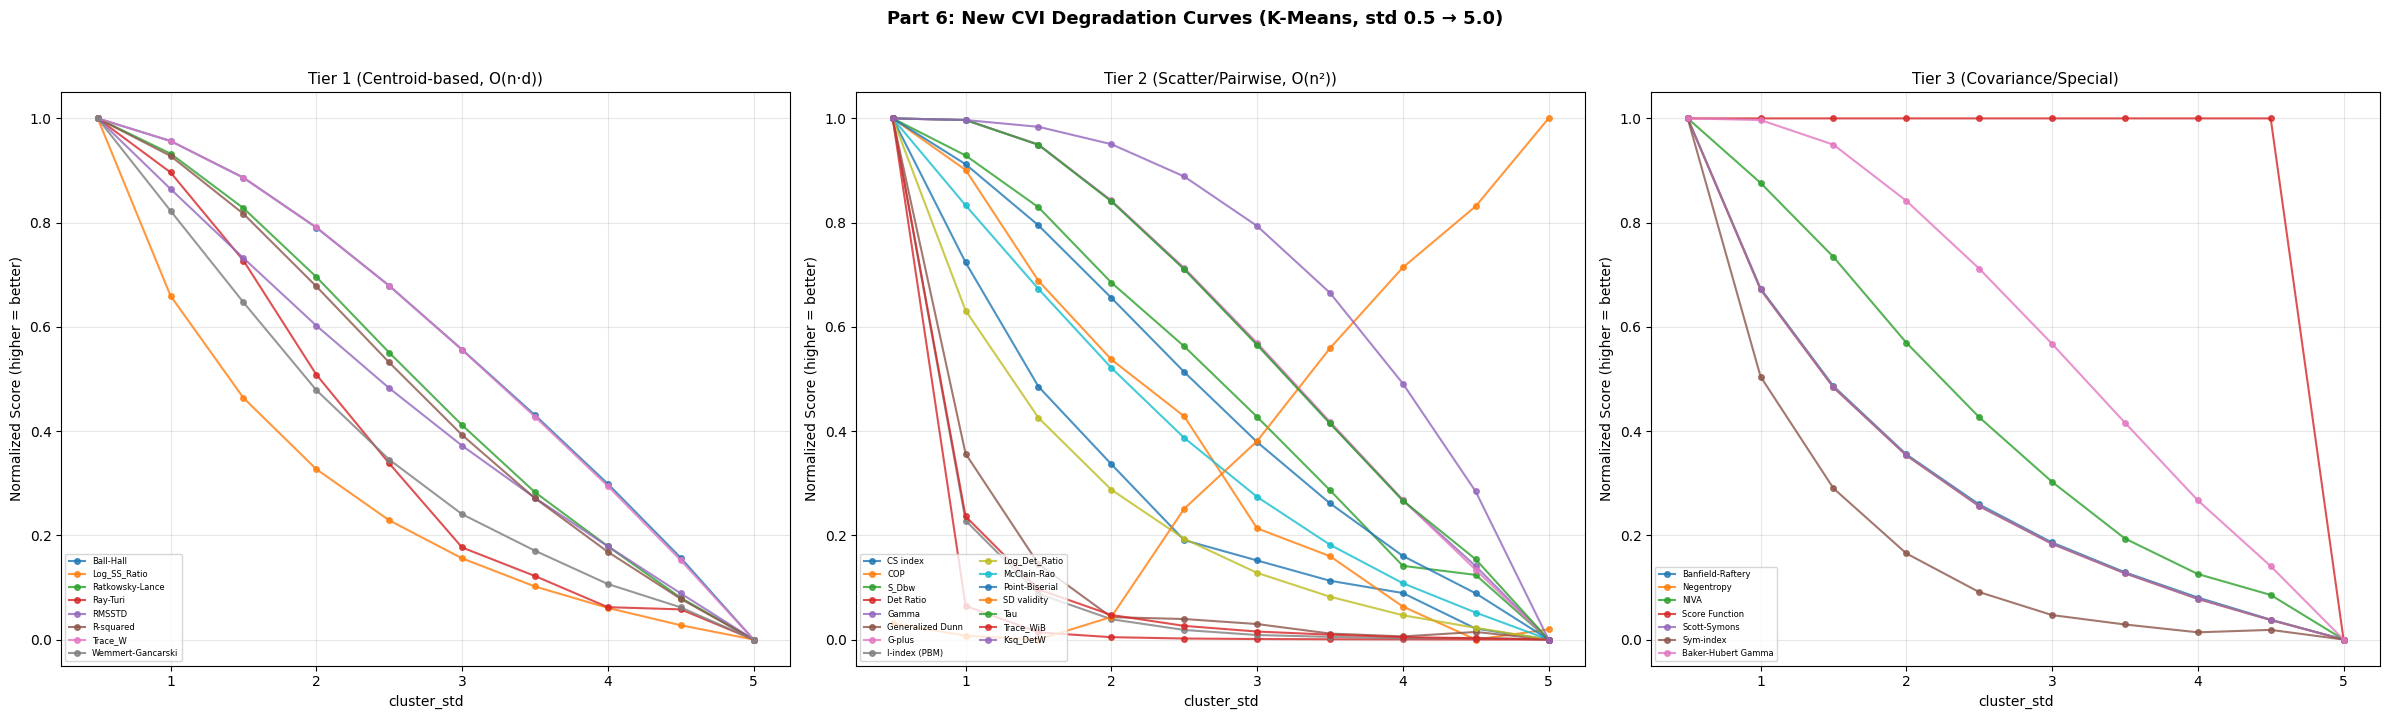

In [27]:
# Degradation curves: 3 panels by tier
tier_groups = {
    "Tier 1 (Centroid-based, O(n·d))": [
        "Ball-Hall",
        "Log_SS_Ratio",
        "Ratkowsky-Lance",
        "Ray-Turi",
        "RMSSTD",
        "R-squared",
        "Trace_W",
        "Wemmert-Gancarski",
    ],
    "Tier 2 (Scatter/Pairwise, O(n²))": [
        "CS index",
        "COP",
        "S_Dbw",
        "Det Ratio",
        "Gamma",
        "Generalized Dunn",
        "G-plus",
        "I-index (PBM)",
        "Log_Det_Ratio",
        "McClain-Rao",
        "Point-Biserial",
        "SD validity",
        "Tau",
        "Trace_WiB",
        "Ksq_DetW",
    ],
    "Tier 3 (Covariance/Special)": [
        "Banfield-Raftery",
        "Negentropy",
        "NIVA",
        "Score Function",
        "Scott-Symons",
        "Sym-index",
        "Baker-Hubert Gamma",
    ],
}

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

for ax, (title, metrics_list) in zip(axes, tier_groups.items(), strict=False):
    for metric in metrics_list:
        raw_vals = np.array([new_metrics[s][metric] for s in std_values])
        # Handle inf/nan
        raw_vals = np.where(np.isinf(raw_vals) | np.isnan(raw_vals), np.nan, raw_vals)
        valid = ~np.isnan(raw_vals)
        if valid.sum() < 2:
            continue
        valid_std = std_values[valid]
        valid_vals = raw_vals[valid]
        norm_vals = normalize_series(valid_vals)
        if new_cvi_direction[metric] == "Lower":
            norm_vals = 1.0 - norm_vals
        ax.plot(
            valid_std, norm_vals, marker="o", label=metric, linewidth=1.5, markersize=4, alpha=0.8
        )

    ax.set_xlabel("cluster_std")
    ax.set_ylabel("Normalized Score (higher = better)")
    ax.set_title(title, fontsize=11)
    ax.legend(fontsize=6, loc="lower left", ncol=2 if len(metrics_list) > 8 else 1)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.25, 5.25)

fig.suptitle(
    "Part 6: New CVI Degradation Curves (K-Means, std 0.5 → 5.0)",
    fontsize=13,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

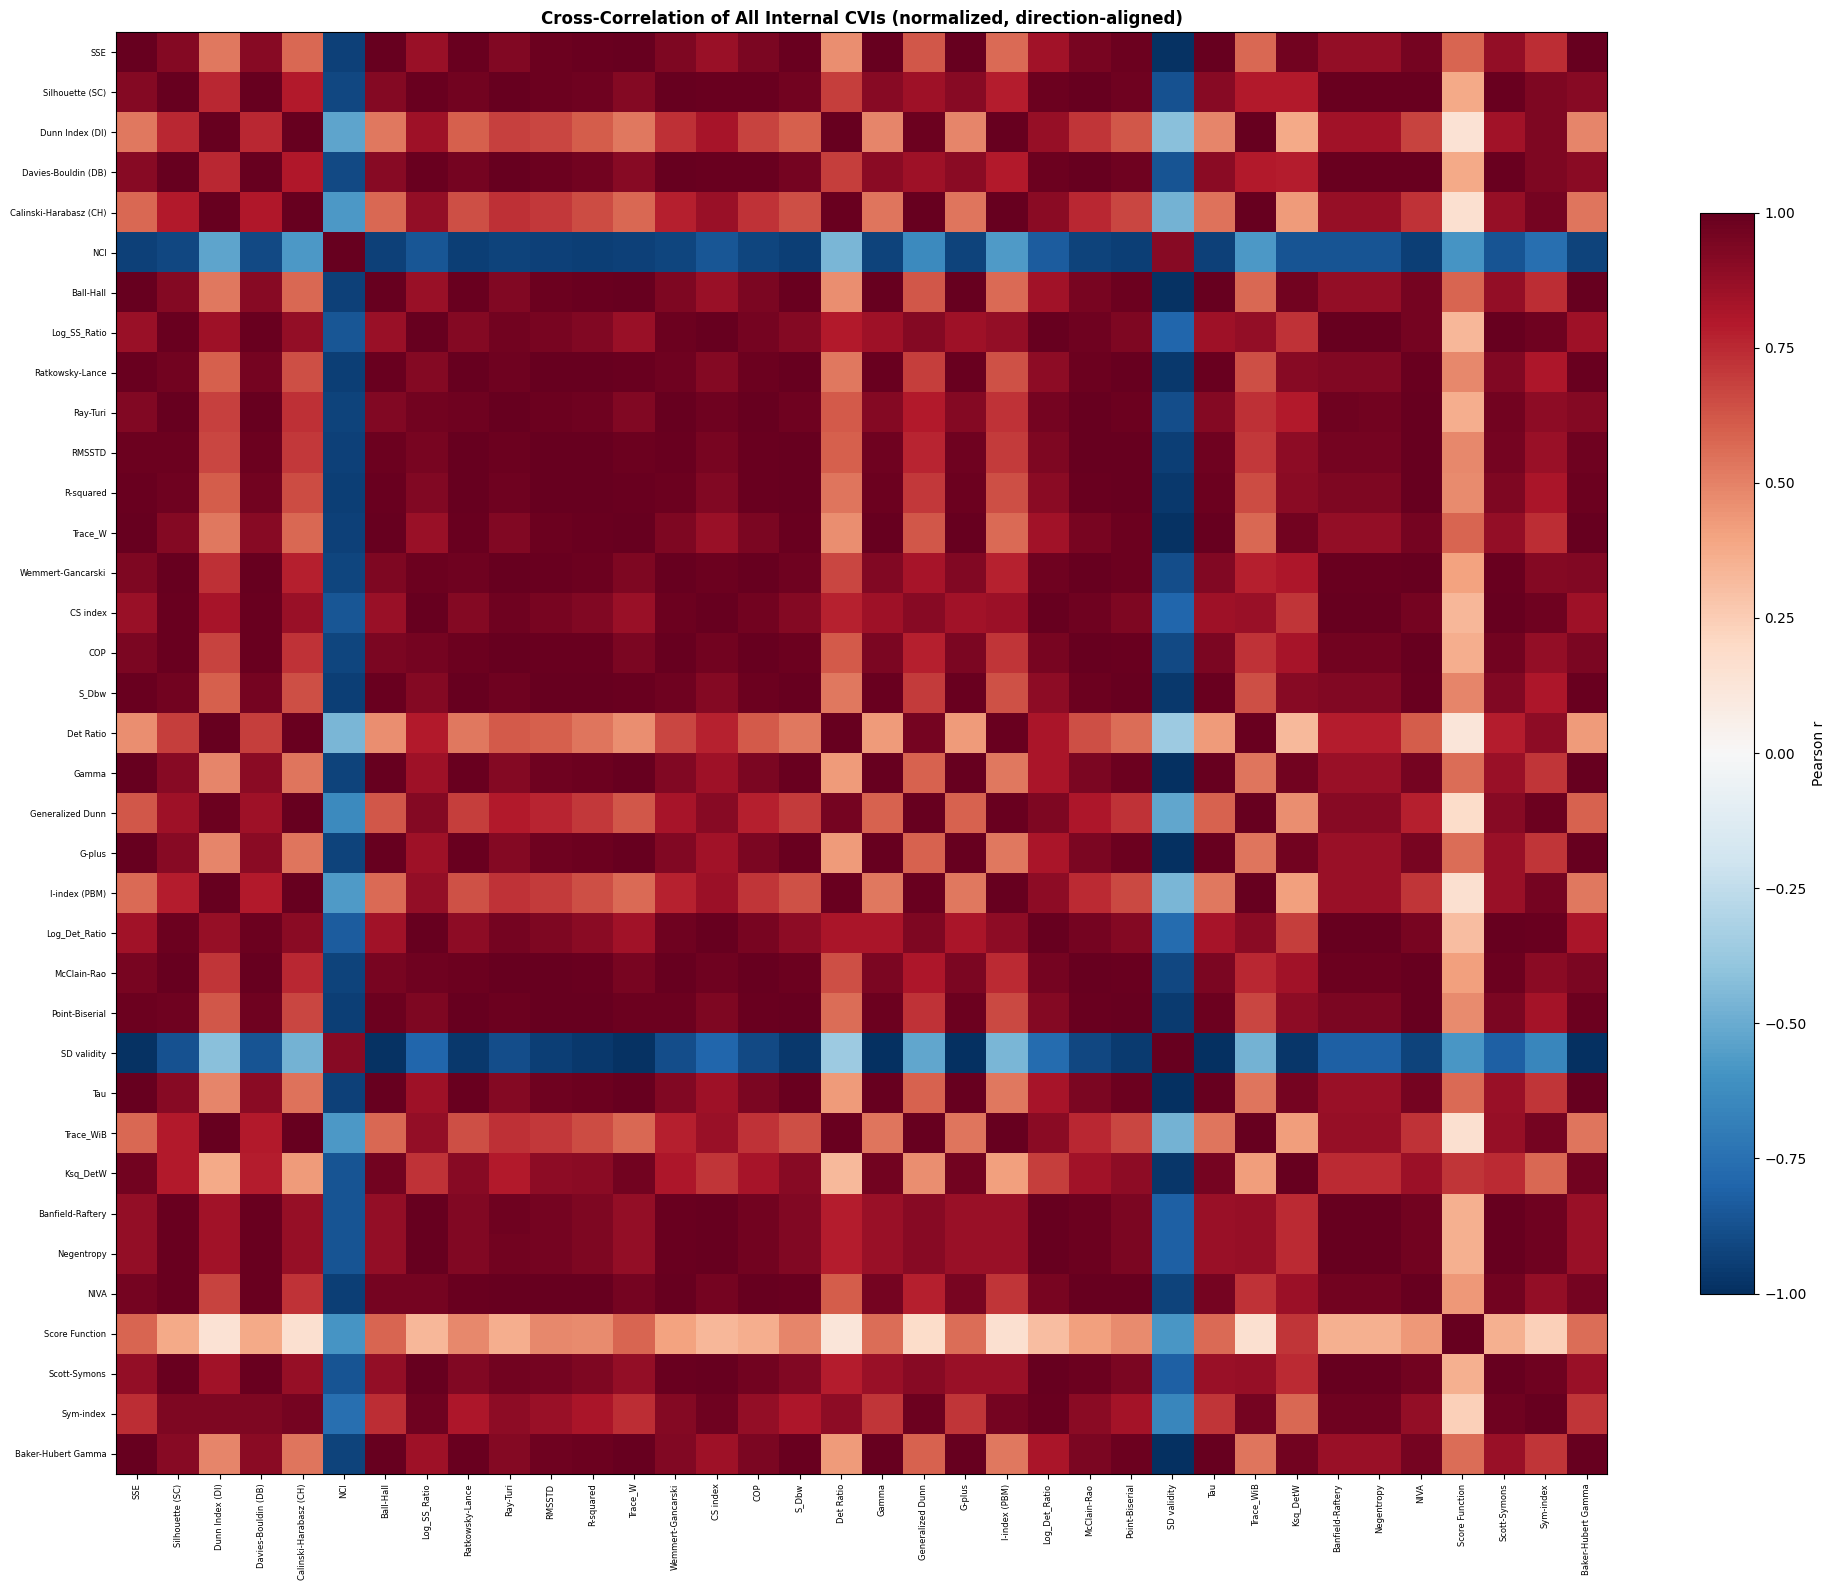


Highly correlated CVI pairs (|r| > 0.95):
  SSE                       <-> Ball-Hall                : r = 1.0000
  SSE                       <-> Ratkowsky-Lance          : r = 0.9880
  SSE                       <-> RMSSTD                   : r = 0.9771
  SSE                       <-> R-squared                : r = 0.9848
  SSE                       <-> Trace_W                  : r = 1.0000
  SSE                       <-> S_Dbw                    : r = 0.9861
  SSE                       <-> Gamma                    : r = 0.9981
  SSE                       <-> G-plus                   : r = 0.9981
  SSE                       <-> Point-Biserial           : r = 0.9816
  SSE                       <-> SD validity              : r = -0.9888
  SSE                       <-> Tau                      : r = 0.9981
  SSE                       <-> Ksq_DetW                 : r = 0.9640
  SSE                       <-> NIVA                     : r = 0.9591
  SSE                       <-> Baker-Hubert G

In [28]:
# Cross-correlation heatmap: ALL internal CVIs (original 6 + 31 new = 37)
original_internal = [
    "SSE",
    "Silhouette (SC)",
    "Dunn Index (DI)",
    "Davies-Bouldin (DB)",
    "Calinski-Harabasz (CH)",
    "NCI",
]

all_internal = {}
for std in std_values:
    row = {}
    for m in original_internal:
        row[m] = fine_metrics[std][m]
    for m in new_cvi_direction:
        row[m] = new_metrics[std][m]
    all_internal[std] = row

df_all = pd.DataFrame(all_internal).T

# Normalize each column by direction (higher always = better)
df_norm = df_all.copy()
all_dirs = {**{m: direction_map[m] for m in original_internal}, **new_cvi_direction}
for col in df_norm.columns:
    vals = df_norm[col].values.astype(float)
    # Handle inf/nan
    vals = np.where(np.isinf(vals) | np.isnan(vals), np.nan, vals)
    valid = ~np.isnan(vals)
    if valid.sum() >= 2:
        v = vals[valid]
        rng = v.max() - v.min()
        if rng > 0:
            vals[valid] = (v - v.min()) / rng
        else:
            vals[valid] = 0.0
    if all_dirs.get(col, "Higher") == "Lower":
        vals[valid] = 1.0 - vals[valid]
    df_norm[col] = vals

# Drop columns with too many NaNs
df_norm = df_norm.dropna(axis=1, thresh=8)

corr = df_norm.corr()
fig, ax = plt.subplots(figsize=(20, 16))
im = ax.imshow(corr.values, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=6)
ax.set_yticklabels(corr.columns, fontsize=6)
plt.colorbar(im, ax=ax, shrink=0.75, label="Pearson r")
ax.set_title(
    "Cross-Correlation of All Internal CVIs (normalized, direction-aligned)",
    fontsize=12,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

# Print highly correlated pairs
print("\nHighly correlated CVI pairs (|r| > 0.95):")
seen = set()
for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        r = corr.iloc[i, j]
        if abs(r) > 0.95:
            pair = (corr.columns[i], corr.columns[j])
            print(f"  {pair[0]:25s} <-> {pair[1]:25s}: r = {r:.4f}")

print(f"\nTotal CVIs in heatmap: {len(corr.columns)}")

---
## Consolidated Metrics Reference & Implementation Guide

This section provides a **comprehensive reference** for all clustering evaluation metrics implemented in this notebook. Each metric is documented with:
- **Definition**: What the metric measures and how it's computed
- **Interpretation**: Range, optimal direction, and practical meaning
- **Implementation**: Where the metric is implemented (sklearn, custom function, or cell location)
- **Use Case**: When and why to use this metric

---

### Quick Reference: All Metrics at a Glance

| Category | # Metrics | Best For |
|----------|-----------|----------|
| **Internal (Original)** | 6 | No ground truth available |
| **External** | 4 | Comparing against known labels |
| **Fuzzy** | 4 | Soft/overlapping cluster assignments |
| **New CVIs (Tier 1)** | 8 | Fast centroid-based evaluation, O(n·d) |
| **New CVIs (Tier 2)** | 15 | Detailed analysis requiring pairwise distances, O(n²) |
| **New CVIs (Tier 3)** | 7 | Specialized covariance-based evaluation |

**Total: 44 unique metrics** (45 including Baker-Hubert Gamma alias)

---

### 1. Original Internal Metrics (6 metrics)

These metrics evaluate clustering quality **without ground truth labels**, based purely on geometric properties.

| Metric | Formula / Logic | Range | Direction | Implementation | Key Insight |
|--------|-----------------|-------|-----------|----------------|-------------|
| **Silhouette (SC)** | $(b - a) / \max(a, b)$ where $a$ = mean intra-cluster dist, $b$ = mean nearest-cluster dist | [-1, 1] | ↑ Higher | `sklearn.metrics.silhouette_score` | Best overall internal metric; per-point interpretability |
| **Dunn Index (DI)** | $\min(\text{inter-cluster dist}) / \max(\text{intra-cluster diameter})$ | [0, ∞) | ↑ Higher | `dunn_index()` (custom, cell 5) | Extremely sensitive to outliers; captures tight separation |
| **Davies-Bouldin (DB)** | Average ratio of within-scatter to between-scatter across cluster pairs | [0, ∞) | ↓ Lower | `sklearn.metrics.davies_bouldin_score` | Fast O(n); favors convex clusters |
| **Calinski-Harabasz (CH)** | $(BGSS / WGSS) × ((n-k)/(k-1))$ | [0, ∞) | ↑ Higher | `sklearn.metrics.calinski_harabasz_score` | Variance ratio; efficient; biased toward equal-sized clusters |
| **SSE** | $\sum_i \|x_i - c_{l_i}\|^2$ (sum of squared errors to centroids) | [0, ∞) | ↓ Lower | K-Means `.inertia_` or `compute_cluster_stats()` | K-Means objective; use elbow method for optimal k |
| **NCI** | Pearson correlation(point-to-centroid dist, centroid-to-global-mean dist) | [-1, 1] | ↑ Higher | `new_correlation_index()` (custom, cell 5) | Non-monotonic; reveals alternative k values via local peaks |

---

### 2. External Metrics (4 metrics)

These metrics require **ground truth labels** and measure partition agreement.

| Metric | Formula / Logic | Range | Direction | Implementation | Key Insight |
|--------|-----------------|-------|-----------|----------------|-------------|
| **Rand Index (ARI)** | Pairwise agreement corrected for chance | [-1, 1] | ↑ Higher | `sklearn.metrics.adjusted_rand_score` | Gold standard for partition comparison; chance-corrected |
| **Van Dongen (VD)** | $1 - (\sum \max_{row} + \sum \max_{col}) / 2n$ | [0, 1] | ↓ Lower | `van_dongen_criterion()` (custom, cell 5) | Contingency-based; captures structural match |
| **Variation of Info (VI)** | $H(U/V) + H(V/U)$ (sum of conditional entropies) | [0, log(n)] | ↓ Lower | `variation_of_information()` (custom, cell 5) | True metric (triangle inequality); information-theoretic |
| **Omega (Ω)** | $\text{mean}([1-ARI], VD, VI_{norm})$ | [0, 1] | ↓ Lower | `omega_indicator()` (custom, cell 5) | Composite complexity score; single summary value |

---

### 3. Fuzzy Clustering Metrics (4 metrics)

For **soft clustering** where points have partial membership in multiple clusters.

| Metric | Formula / Logic | Range | Direction | Implementation | Key Insight |
|--------|-----------------|-------|-----------|----------------|-------------|
| **Partition Coefficient (PC)** | $\frac{1}{n}\sum_i\sum_j u_{ij}^2$ | [1/k, 1] | ↑ Higher | `partition_coefficient()` (custom, Part 4) | Measures membership crispness; 1 = hard clustering |
| **Classification Entropy (CE)** | $-\frac{1}{n}\sum_i\sum_j u_{ij}\log_2(u_{ij})$ | [0, log₂(k)] | ↓ Lower | `classification_entropy()` (custom, Part 4) | Entropy of membership matrix; 0 = hard clustering |
| **Xie-Beni (XB)** | $\frac{\sum_i\sum_j u_{ij}^m \|x_i - c_j\|^2}{n × \min_{i≠j}\|c_i - c_j\|^2}$ | [0, ∞) | ↓ Lower | `xie_beni()` (custom, Part 4) | Compactness vs separation; sensitive to cluster count |
| **Fukuyama-Sugeno (FS)** | $\sum_i\sum_j u_{ij}^m(\|x_i - c_j\|^2 - \|c_j - \bar{x}\|^2)$ | (-∞, ∞) | ↓ Lower | `fukuyama_sugeno()` (custom, Part 4) | Negative values indicate good clustering |

---

### 4. New CVIs — Tier 1: Centroid-Based (8 metrics)

**O(n·d) complexity** — No pairwise distance matrix needed. Fast for large datasets.

| Metric | Formula / Logic | Range | Direction | Implementation | Key Insight |
|--------|-----------------|-------|-----------|----------------|-------------|
| **Ball-Hall** | Mean of per-cluster mean dispersion | [0, ∞) | ↓ Lower | `ball_hall()` | Average within-cluster variance |
| **Log_SS_Ratio** | $\log(BGSS / WGSS)$ | (-∞, ∞) | ↑ Higher | `log_ss_ratio()` | Log separation-to-compactness ratio |
| **Ratkowsky-Lance** | $\sqrt{\text{mean}(BGSS_d / TSS_d) / k}$ | [0, 1] | ↑ Higher | `ratkowsky_lance()` | Per-feature variance explained |
| **Ray-Turi** | $(WGSS/n) / \min_{i≠j}\|c_i - c_j\|^2$ | [0, ∞) | ↓ Lower | `ray_turi()` | Compactness / closest centroid separation |
| **RMSSTD** | $\sqrt{WGSS / (df × d)}$ | [0, ∞) | ↓ Lower | `rmsstd_index()` | Pooled within-cluster standard deviation |
| **R-squared** | $BGSS / TSS$ | [0, 1] | ↑ Higher | `r_squared()` | Variance explained by clustering |
| **Trace_W** | $\text{trace}(W)$ (within-cluster scatter matrix) | [0, ∞) | ↓ Lower | `trace_w_index()` | Total within-cluster scatter |
| **Wemmert-Gancarski** | Centroid membership quality based on distance ratios | [0, 1] | ↑ Higher | `wemmert_gancarski()` | Points closer to own centroid than others |

---

### 5. New CVIs — Tier 2: Scatter-Matrix / Pairwise-Distance (15 metrics)

**O(n²) complexity** — Require full pairwise distance matrix or scatter matrix determinants.

| Metric | Formula / Logic | Range | Direction | Implementation | Key Insight |
|--------|-----------------|-------|-----------|----------------|-------------|
| **CS index** | $\max(\text{nearest intra}) / \min(\text{centroid dist})$ | [0, ∞) | ↓ Lower | `cs_index()` | Compact-Separated ratio |
| **COP** | Mean of centroid dist / max intra dist per point | [0, ∞) | ↓ Lower | `cop_index()` | Per-point compactness measure |
| **S_Dbw** | Scatter + inter-cluster density | [0, ∞) | ↓ Lower | `s_dbw_index()` | Density-based separation |
| **Det Ratio** | $\det(T) / \det(W)$ | [0, ∞) | ↑ Higher | `det_ratio_index()` | Determinant ratio of scatter matrices |
| **Gamma** | $(S^+ - S^-) / (S^+ + S^-)$ | [-1, 1] | ↑ Higher | `gamma_index_cvi()` | Concordant vs discordant pairs |
| **Generalized Dunn** | Centroid-based inter / max diameter | [0, ∞) | ↑ Higher | `generalized_dunn_index()` | Centroid variant of Dunn |
| **G-plus** | $2S^- / (n_{pairs})^2$ | [0, 1] | ↓ Lower | `g_plus_index()` | Normalized discordant pairs |
| **I-index (PBM)** | $((1/k) × (E_T/E_W) × D_B)^2$ | [0, ∞) | ↑ Higher | `i_index_pbm()` | Composite separation measure |
| **Log_Det_Ratio** | $n × \log(\det(T)/\det(W))$ | (-∞, ∞) | ↑ Higher | `log_det_ratio_index()` | Log determinant ratio |
| **McClain-Rao** | Mean within dist / Mean between dist | [0, ∞) | ↓ Lower | `mcclain_rao()` | Distance ratio |
| **Point-Biserial** | Corr(distance, same_cluster) × (-1) | [-1, 1] | ↑ Higher | `point_biserial_index()` | Distance-cluster correlation |
| **SD validity** | Scatter² + distance measure | [0, ∞) | ↓ Lower | `sd_validity_index()` | Scatter and centroid distances |
| **Tau** | Normalized concordance $(S^+ - S^-) / \sqrt{...}$ | [-1, 1] | ↑ Higher | `tau_index()` | Normalized Gamma |
| **Trace_WiB** | $\text{trace}(W^{-1}B)$ | [0, ∞) | ↑ Higher | `trace_wib_index()` | Separation relative to compactness |
| **Ksq_DetW** | $k^2 × \det(W)$ | [0, ∞) | ↓ Lower | `ksq_detw_index()` | Penalized compactness |

---

### 6. New CVIs — Tier 3: Covariance-Based / Specialized (7 metrics)

Require **per-cluster covariance** determinants or specialized logic.

| Metric | Formula / Logic | Range | Direction | Implementation | Key Insight |
|--------|-----------------|-------|-----------|----------------|-------------|
| **Banfield-Raftery** | $\sum n_j \log(\text{trace}(W_j)/n_j)$ | (-∞, ∞) | ↓ Lower | `banfield_raftery()` | Log weighted variance |
| **Negentropy** | Cluster entropy relative to Gaussian | (-∞, ∞) | ↓ Lower | `negentropy_increment()` | Departure from normality |
| **NIVA** | Nearest intra / nearest inter distance ratio | [0, ∞) | ↓ Lower | `niva_index()` | Nearest-neighbor separation |
| **Score Function** | $1 - 1/\exp(\exp(bdc - wcd))$ | [0, 1] | ↑ Higher | `score_function_index()` | Exponential separation score |
| **Scott-Symons** | $\sum n_j \log(\det(W_j/n_j))$ | (-∞, ∞) | ↓ Lower | `scott_symons_index()` | Per-cluster covariance |
| **Sym-index** | $(1/k × E_T/E_W × D_B)^{1/d}$ | [0, ∞) | ↑ Higher | `sym_index()` | Dimension-adjusted I-index |
| **Baker-Hubert Gamma** | Same as Gamma (alias) | [-1, 1] | ↑ Higher | `baker_hubert_gamma()` | Alias for `gamma_index_cvi()` |

---

### Implementation Summary by Source

| Source | Metrics |
|--------|---------|
| **sklearn.metrics** | Silhouette, Davies-Bouldin, Calinski-Harabasz, ARI, Rand (raw) |
| **Custom (Part 1, cell 5)** | Dunn Index, NCI, Van Dongen, VI, Omega |
| **Custom (Part 4)** | PC, CE, Xie-Beni, Fukuyama-Sugeno |
| **Custom (Part 6)** | All 31 new CVIs (Tier 1, 2, 3) |
| **K-Means model** | SSE (via `.inertia_`) |

---

## Practical Recommendations

| Scenario | Recommended Metrics | Rationale |
|----------|---------------------|-----------|
| **Production (no labels)** | Silhouette, CH, R-squared | Reliable, efficient, interpretable |
| **Validation (with labels)** | ARI, VI | Gold standards for partition comparison |
| **Large datasets (>100k)** | Tier 1 CVIs, DB, CH | O(n) or O(n·d); avoid O(n²) |
| **Exploring optimal k** | SSE (elbow), NCI (peaks) | Multi-scale detection |
| **Noise-heavy data** | DB, SC | More robust than Dunn |
| **Fuzzy/soft clustering** | PC, CE, XB | Designed for soft assignments |
| **Comprehensive analysis** | All 44 metrics | Use correlation analysis to reduce redundancy |

In [29]:
# ============================================================
# Comprehensive Metrics Reference DataFrame
# ============================================================
# This cell creates a complete reference table for all metrics
# with their properties, implementations, and usage guidance.
#
# NOTE: 5 metrics were REMOVED due to mathematical redundancy
# (see REMOVED METRICS section at bottom for equations)

metrics_comprehensive = pd.DataFrame(
    [
        # ========== Original Internal Metrics (6) ==========
        {
            "Metric": "Silhouette (SC)",
            "Category": "Internal (Original)",
            "Tier": "-",
            "Direction": "Higher=Better",
            "Range": "[-1, 1]",
            "Complexity": "O(n²)",
            "Implementation": "sklearn.metrics.silhouette_score",
            "Formula": "(b - a) / max(a, b)",
            "Best For": "Overall quality assessment; per-point interpretation",
            "Status": "Active",
        },
        {
            "Metric": "Dunn Index (DI)",
            "Category": "Internal (Original)",
            "Tier": "-",
            "Direction": "Higher=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n²)",
            "Implementation": "dunn_index() - custom, Part 1",
            "Formula": "min(inter) / max(intra diameter)",
            "Best For": "Detecting tight, well-separated clusters; avoid with outliers",
            "Status": "Active",
        },
        {
            "Metric": "Davies-Bouldin (DB)",
            "Category": "Internal (Original)",
            "Tier": "-",
            "Direction": "Lower=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n)",
            "Implementation": "sklearn.metrics.davies_bouldin_score",
            "Formula": "Avg(max scatter ratio per cluster)",
            "Best For": "Fast evaluation; convex clusters",
            "Status": "Active",
        },
        {
            "Metric": "Calinski-Harabasz (CH)",
            "Category": "Internal (Original)",
            "Tier": "-",
            "Direction": "Higher=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n)",
            "Implementation": "sklearn.metrics.calinski_harabasz_score",
            "Formula": "(BGSS/WGSS) × ((n-k)/(k-1))",
            "Best For": "Efficient variance-based assessment",
            "Status": "Active",
        },
        {
            "Metric": "SSE",
            "Category": "Internal (Original)",
            "Tier": "-",
            "Direction": "Lower=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n)",
            "Implementation": "KMeans.inertia_ or compute_cluster_stats()",
            "Formula": "Σ||xᵢ - c_label||²",
            "Best For": "Elbow method for optimal k",
            "Status": "Active",
        },
        {
            "Metric": "NCI",
            "Category": "Internal (Original)",
            "Tier": "-",
            "Direction": "Higher=Better",
            "Range": "[-1, 1]",
            "Complexity": "O(n)",
            "Implementation": "new_correlation_index() - custom, Part 1",
            "Formula": "corr(point-to-centroid, centroid-to-global)",
            "Best For": "Exploring alternative k values (look for peaks)",
            "Status": "Active",
        },
        # ========== External Metrics (4) ==========
        {
            "Metric": "Adjusted Rand Index (ARI)",
            "Category": "External",
            "Tier": "-",
            "Direction": "Higher=Better",
            "Range": "[-1, 1]",
            "Complexity": "O(n²)",
            "Implementation": "sklearn.metrics.adjusted_rand_score",
            "Formula": "(RI - E[RI]) / (max(RI) - E[RI])",
            "Best For": "Gold standard for partition comparison",
            "Status": "Active",
        },
        {
            "Metric": "Van Dongen (VD)",
            "Category": "External",
            "Tier": "-",
            "Direction": "Lower=Better",
            "Range": "[0, 1]",
            "Complexity": "O(n)",
            "Implementation": "van_dongen_criterion() - custom, Part 1",
            "Formula": "1 - (Σmax_row + Σmax_col) / 2n",
            "Best For": "Contingency-based structural match",
            "Status": "Active",
        },
        {
            "Metric": "Variation of Info (VI)",
            "Category": "External",
            "Tier": "-",
            "Direction": "Lower=Better",
            "Range": "[0, log(n)]",
            "Complexity": "O(n)",
            "Implementation": "variation_of_information() - custom, Part 1",
            "Formula": "H(U|V) + H(V|U)",
            "Best For": "Information-theoretic comparison",
            "Status": "Active",
        },
        {
            "Metric": "Omega (Ω)",
            "Category": "External",
            "Tier": "-",
            "Direction": "Lower=Better",
            "Range": "[0, 1]",
            "Complexity": "O(n)",
            "Implementation": "omega_indicator() - custom, Part 1",
            "Formula": "mean([1-ARI], VD, VI_norm)",
            "Best For": "Single composite complexity score",
            "Status": "Active",
        },
        # ========== Fuzzy Metrics (4) ==========
        {
            "Metric": "Partition Coefficient (PC)",
            "Category": "Fuzzy",
            "Tier": "-",
            "Direction": "Higher=Better",
            "Range": "[1/k, 1]",
            "Complexity": "O(n·k)",
            "Implementation": "partition_coefficient() - custom, Part 4",
            "Formula": "(1/n)ΣᵢΣⱼu²ᵢⱼ",
            "Best For": "Membership crispness assessment",
            "Status": "Active",
        },
        {
            "Metric": "Classification Entropy (CE)",
            "Category": "Fuzzy",
            "Tier": "-",
            "Direction": "Lower=Better",
            "Range": "[0, log₂(k)]",
            "Complexity": "O(n·k)",
            "Implementation": "classification_entropy() - custom, Part 4",
            "Formula": "-(1/n)ΣᵢΣⱼuᵢⱼlog₂(uᵢⱼ)",
            "Best For": "Uncertainty in soft assignments",
            "Status": "Active",
        },
        {
            "Metric": "Xie-Beni (XB)",
            "Category": "Fuzzy",
            "Tier": "-",
            "Direction": "Lower=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n·k)",
            "Implementation": "xie_beni() - custom, Part 4",
            "Formula": "ΣᵢΣⱼuᵐᵢⱼ||xᵢ-cⱼ||² / (n×min||cᵢ-cⱼ||²)",
            "Best For": "Fuzzy compactness vs separation",
            "Status": "Active",
        },
        {
            "Metric": "Fukuyama-Sugeno (FS)",
            "Category": "Fuzzy",
            "Tier": "-",
            "Direction": "Lower=Better",
            "Range": "(-∞, ∞)",
            "Complexity": "O(n·k)",
            "Implementation": "fukuyama_sugeno() - custom, Part 4",
            "Formula": "ΣᵢΣⱼuᵐᵢⱼ(||xᵢ-cⱼ||²-||cⱼ-x̄||²)",
            "Best For": "Fuzzy within vs between variance",
            "Status": "Active",
        },
        # ========== Tier 1: Centroid-based (6 active, 2 removed) ==========
        {
            "Metric": "Ball-Hall",
            "Category": "New CVI",
            "Tier": "1",
            "Direction": "Lower=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n·d)",
            "Implementation": "ball_hall() - custom, Part 6",
            "Formula": "Mean per-cluster dispersion",
            "Best For": "Fast compactness check",
            "Status": "Active",
        },
        {
            "Metric": "Ratkowsky-Lance",
            "Category": "New CVI",
            "Tier": "1",
            "Direction": "Higher=Better",
            "Range": "[0, 1]",
            "Complexity": "O(n·d)",
            "Implementation": "ratkowsky_lance() - custom, Part 6",
            "Formula": "sqrt(mean(BGSS_d/TSS_d)/k)",
            "Best For": "Per-feature variance explained",
            "Status": "Active",
        },
        {
            "Metric": "Ray-Turi",
            "Category": "New CVI",
            "Tier": "1",
            "Direction": "Lower=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n·d)",
            "Implementation": "ray_turi() - custom, Part 6",
            "Formula": "(WGSS/n) / min(centroid dist²)",
            "Best For": "Compactness relative to separation",
            "Status": "Active",
        },
        {
            "Metric": "RMSSTD",
            "Category": "New CVI",
            "Tier": "1",
            "Direction": "Lower=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n·d)",
            "Implementation": "rmsstd_index() - custom, Part 6",
            "Formula": "sqrt(WGSS / (df × d))",
            "Best For": "Pooled standard deviation",
            "Status": "Active",
        },
        {
            "Metric": "R-squared",
            "Category": "New CVI",
            "Tier": "1",
            "Direction": "Higher=Better",
            "Range": "[0, 1]",
            "Complexity": "O(n·d)",
            "Implementation": "r_squared() - custom, Part 6",
            "Formula": "BGSS / TSS",
            "Best For": "Variance explained (like ANOVA)",
            "Status": "Active",
        },
        {
            "Metric": "Wemmert-Gancarski",
            "Category": "New CVI",
            "Tier": "1",
            "Direction": "Higher=Better",
            "Range": "[0, 1]",
            "Complexity": "O(n·k·d)",
            "Implementation": "wemmert_gancarski() - custom, Part 6",
            "Formula": "Centroid membership quality",
            "Best For": "Points closer to own centroid",
            "Status": "Active",
        },
        # ========== Tier 2: Scatter/Pairwise (14 active) ==========
        {
            "Metric": "CS index",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Lower=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n²)",
            "Implementation": "cs_index() - custom, Part 6",
            "Formula": "max(nearest intra) / min(centroid dist)",
            "Best For": "Compact-separated ratio",
            "Status": "Active",
        },
        {
            "Metric": "COP",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Lower=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n²)",
            "Implementation": "cop_index() - custom, Part 6",
            "Formula": "mean(centroid dist / max intra)",
            "Best For": "Per-point compactness",
            "Status": "Active",
        },
        {
            "Metric": "S_Dbw",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Lower=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n²)",
            "Implementation": "s_dbw_index() - custom, Part 6",
            "Formula": "scatter + inter-cluster density",
            "Best For": "Density-based quality",
            "Status": "Active",
        },
        {
            "Metric": "Det Ratio",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Higher=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n·d²)",
            "Implementation": "det_ratio_index() - custom, Part 6",
            "Formula": "det(T) / det(W)",
            "Best For": "Multivariate scatter ratio",
            "Status": "Active",
        },
        {
            "Metric": "Gamma",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Higher=Better",
            "Range": "[-1, 1]",
            "Complexity": "O(n²)",
            "Implementation": "gamma_index_cvi() - custom, Part 6",
            "Formula": "(S⁺ - S⁻) / (S⁺ + S⁻)",
            "Best For": "Concordant pair dominance",
            "Status": "Active",
        },
        {
            "Metric": "Generalized Dunn",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Higher=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n²)",
            "Implementation": "generalized_dunn_index() - custom, Part 6",
            "Formula": "centroid inter / max diameter",
            "Best For": "Centroid-based separation",
            "Status": "Active",
        },
        {
            "Metric": "G-plus",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Lower=Better",
            "Range": "[0, 1]",
            "Complexity": "O(n²)",
            "Implementation": "g_plus_index() - custom, Part 6",
            "Formula": "2S⁻ / (n_pairs)²",
            "Best For": "Normalized discordant pairs",
            "Status": "Active",
        },
        {
            "Metric": "I-index (PBM)",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Higher=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n·d)",
            "Implementation": "i_index_pbm() - custom, Part 6",
            "Formula": "((1/k) × (Eₜ/Eᵥ) × Dᵦ)²",
            "Best For": "Composite quality index",
            "Status": "Active",
        },
        {
            "Metric": "Log_Det_Ratio",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Higher=Better",
            "Range": "(-∞, ∞)",
            "Complexity": "O(n·d²)",
            "Implementation": "log_det_ratio_index() - custom, Part 6",
            "Formula": "n × log(det(T)/det(W))",
            "Best For": "Log-scale multivariate quality",
            "Status": "Active",
        },
        {
            "Metric": "McClain-Rao",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Lower=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n²)",
            "Implementation": "mcclain_rao() - custom, Part 6",
            "Formula": "mean(within) / mean(between)",
            "Best For": "Distance ratio",
            "Status": "Active",
        },
        {
            "Metric": "Point-Biserial",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Higher=Better",
            "Range": "[-1, 1]",
            "Complexity": "O(n²)",
            "Implementation": "point_biserial_index() - custom, Part 6",
            "Formula": "-corr(distance, same_cluster)",
            "Best For": "Distance-label correlation",
            "Status": "Active",
        },
        {
            "Metric": "SD validity",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Lower=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n·d)",
            "Implementation": "sd_validity_index() - custom, Part 6",
            "Formula": "scatter² + distance measure",
            "Best For": "Combined scatter-distance",
            "Status": "Active",
        },
        {
            "Metric": "Tau",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Higher=Better",
            "Range": "[-1, 1]",
            "Complexity": "O(n²)",
            "Implementation": "tau_index() - custom, Part 6",
            "Formula": "(S⁺ - S⁻) / sqrt(...)",
            "Best For": "Normalized concordance",
            "Status": "Active",
        },
        {
            "Metric": "Trace_WiB",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Higher=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n·d²)",
            "Implementation": "trace_wib_index() - custom, Part 6",
            "Formula": "trace(W⁻¹B)",
            "Best For": "Separation/compactness ratio",
            "Status": "Active",
        },
        {
            "Metric": "Ksq_DetW",
            "Category": "New CVI",
            "Tier": "2",
            "Direction": "Lower=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n·d²)",
            "Implementation": "ksq_detw_index() - custom, Part 6",
            "Formula": "k² × det(W)",
            "Best For": "Penalized compactness",
            "Status": "Active",
        },
        # ========== Tier 3: Covariance/Special (5 active) ==========
        {
            "Metric": "Banfield-Raftery",
            "Category": "New CVI",
            "Tier": "3",
            "Direction": "Lower=Better",
            "Range": "(-∞, ∞)",
            "Complexity": "O(n·d²)",
            "Implementation": "banfield_raftery() - custom, Part 6",
            "Formula": "Σnⱼlog(trace(Wⱼ)/nⱼ)",
            "Best For": "Log weighted variance",
            "Status": "Active",
        },
        {
            "Metric": "Negentropy",
            "Category": "New CVI",
            "Tier": "3",
            "Direction": "Lower=Better",
            "Range": "(-∞, ∞)",
            "Complexity": "O(n·d²)",
            "Implementation": "negentropy_increment() - custom, Part 6",
            "Formula": "Cluster entropy vs Gaussian",
            "Best For": "Non-Gaussianity detection",
            "Status": "Active",
        },
        {
            "Metric": "NIVA",
            "Category": "New CVI",
            "Tier": "3",
            "Direction": "Lower=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n²)",
            "Implementation": "niva_index() - custom, Part 6",
            "Formula": "nearest intra / nearest inter",
            "Best For": "Nearest-neighbor quality",
            "Status": "Active",
        },
        {
            "Metric": "Score Function",
            "Category": "New CVI",
            "Tier": "3",
            "Direction": "Higher=Better",
            "Range": "[0, 1]",
            "Complexity": "O(n·d)",
            "Implementation": "score_function_index() - custom, Part 6",
            "Formula": "1 - 1/exp(exp(bdc-wcd))",
            "Best For": "Exponential separation score",
            "Status": "Active",
        },
        {
            "Metric": "Scott-Symons",
            "Category": "New CVI",
            "Tier": "3",
            "Direction": "Lower=Better",
            "Range": "(-∞, ∞)",
            "Complexity": "O(n·d²)",
            "Implementation": "scott_symons_index() - custom, Part 6",
            "Formula": "Σnⱼlog(det(Wⱼ/nⱼ))",
            "Best For": "Per-cluster covariance",
            "Status": "Active",
        },
        # ========== REMOVED METRICS (5 total) ==========
        # These metrics were identified as mathematically redundant via
        # Spearman correlation analysis (|ρ| > 0.99) and empirical R² ≈ 1.0
        {
            "Metric": "Trace_W",
            "Category": "REMOVED",
            "Tier": "1",
            "Direction": "Lower=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n·d)",
            "Implementation": "trace_w_index() - REMOVED",
            "Formula": "trace(W) = Σⱼ Σᵢ∈Cⱼ ||xᵢ - cⱼ||²",
            "Best For": "⚠️ REMOVED: Identical to SSE",
            "Status": "Removed",
            "Removal Reason": "IDENTICAL: trace(W) ≡ Σⱼ Σᵢ∈Cⱼ ||xᵢ - cⱼ||² ≡ SSE (R² = 1.000)",
        },
        {
            "Metric": "Baker-Hubert Gamma",
            "Category": "REMOVED",
            "Tier": "3",
            "Direction": "Higher=Better",
            "Range": "[-1, 1]",
            "Complexity": "O(n²)",
            "Implementation": "baker_hubert_gamma() - REMOVED",
            "Formula": "(S⁺ - S⁻) / (S⁺ + S⁻)",
            "Best For": "⚠️ REMOVED: Identical to Gamma",
            "Status": "Removed",
            "Removal Reason": "IDENTICAL: Same formula as Gamma index (R² = 1.000)",
        },
        {
            "Metric": "Sym-index",
            "Category": "REMOVED",
            "Tier": "3",
            "Direction": "Higher=Better",
            "Range": "[0, ∞)",
            "Complexity": "O(n·d)",
            "Implementation": "sym_index() - REMOVED",
            "Formula": "((1/k) × (Eₜ/Eᵥ) × Dᵦ)^(1/d)",
            "Best For": "⚠️ REMOVED: Power transform of I-index",
            "Status": "Removed",
            "Removal Reason": "POWER TRANSFORM: Sym = I^(1/2d), where I-index = ((1/k)×(Eₜ/Eᵥ)×Dᵦ)²",
        },
        {
            "Metric": "Rand Index (Raw)",
            "Category": "REMOVED",
            "Tier": "-",
            "Direction": "Higher=Better",
            "Range": "[0, 1]",
            "Complexity": "O(n²)",
            "Implementation": "sklearn.metrics.rand_score - REMOVED",
            "Formula": "(a + d) / C(n,2)",
            "Best For": "⚠️ REMOVED: Linear transform of ARI",
            "Status": "Removed",
            "Removal Reason": "LINEAR TRANSFORM: ARI = (RI - E[RI]) / (1 - E[RI]), chance-corrected version",
        },
        {
            "Metric": "Log_SS_Ratio",
            "Category": "REMOVED",
            "Tier": "1",
            "Direction": "Higher=Better",
            "Range": "(-∞, ∞)",
            "Complexity": "O(n·d)",
            "Implementation": "log_ss_ratio() - REMOVED",
            "Formula": "log(BGSS/WGSS)",
            "Best For": "⚠️ REMOVED: Logit transform of R-squared",
            "Status": "Removed",
            "Removal Reason": "LOGIT TRANSFORM: log_SS = log(R²/(1-R²)) = logit(R²), since R² = BGSS/TSS",
        },
    ]
)

# Display the comprehensive reference
active_metrics = metrics_comprehensive[metrics_comprehensive["Status"] == "Active"]
removed_metrics = metrics_comprehensive[metrics_comprehensive["Status"] == "Removed"]

print("📊 COMPREHENSIVE METRICS REFERENCE")
print(f"   Active metrics: {len(active_metrics)}")
print(f"   Removed (redundant): {len(removed_metrics)}")
print()

# Summary by category (active only)
print("Active Metrics by Category:")
print(active_metrics.groupby("Category").size().to_string())
print()

# Summary by direction (active only)
print("\nActive Metrics by Optimization Direction:")
print(active_metrics.groupby("Direction").size().to_string())
print()

# Display removed metrics with reasons
print("\n" + "=" * 70)
print("⚠️  REMOVED METRICS (MATHEMATICAL REDUNDANCY)")
print("=" * 70)
for _, row in removed_metrics.iterrows():
    print(f"\n❌ {row['Metric']}")
    print(f"   Formula: {row['Formula']}")
    print(f"   Reason: {row['Removal Reason']}")

# Display active metrics table
print("\n" + "=" * 70)
print("✅ ACTIVE METRICS REFERENCE")
print("=" * 70)
display(
    active_metrics[["Metric", "Category", "Direction", "Range", "Formula", "Best For"]]
    .style.set_caption("Active Clustering Metrics Reference (39 metrics)")
    .set_table_styles(
        [
            {"selector": "th", "props": [("font-size", "10px"), ("text-align", "left")]},
            {"selector": "td", "props": [("font-size", "9px"), ("text-align", "left")]},
        ]
    )
)

# Export to CSV for easy reference
metrics_comprehensive.to_csv("metrics_reference_complete.csv", index=False)
print("\n✅ Reference saved to 'metrics_reference_complete.csv'")

📊 COMPREHENSIVE METRICS REFERENCE
   Active metrics: 40
   Removed (redundant): 5

Active Metrics by Category:
Category
External                4
Fuzzy                   4
Internal (Original)     6
New CVI                26


Active Metrics by Optimization Direction:
Direction
Higher=Better    18
Lower=Better     22


⚠️  REMOVED METRICS (MATHEMATICAL REDUNDANCY)

❌ Trace_W
   Formula: trace(W) = Σⱼ Σᵢ∈Cⱼ ||xᵢ - cⱼ||²
   Reason: IDENTICAL: trace(W) ≡ Σⱼ Σᵢ∈Cⱼ ||xᵢ - cⱼ||² ≡ SSE (R² = 1.000)

❌ Baker-Hubert Gamma
   Formula: (S⁺ - S⁻) / (S⁺ + S⁻)
   Reason: IDENTICAL: Same formula as Gamma index (R² = 1.000)

❌ Sym-index
   Formula: ((1/k) × (Eₜ/Eᵥ) × Dᵦ)^(1/d)
   Reason: POWER TRANSFORM: Sym = I^(1/2d), where I-index = ((1/k)×(Eₜ/Eᵥ)×Dᵦ)²

❌ Rand Index (Raw)
   Formula: (a + d) / C(n,2)
   Reason: LINEAR TRANSFORM: ARI = (RI - E[RI]) / (1 - E[RI]), chance-corrected version

❌ Log_SS_Ratio
   Formula: log(BGSS/WGSS)
   Reason: LOGIT TRANSFORM: log_SS = log(R²/(1-R²)) = logit(R²), since 


✅ Reference saved to 'metrics_reference_complete.csv'


---

In [30]:
# ============================================================
# Quick-Access Utilities for Metrics Reference
# ============================================================
# NOTE: Removed 5 redundant metrics from this dictionary:
#   - Trace_W (identical to SSE)
#   - Baker-Hubert Gamma (identical to Gamma)
#   - Sym-index (power transform of I-index)
#   - Rand Index (Raw) (linear transform of ARI)
#   - Log_SS_Ratio (logit transform of R-squared)

# Complete direction map for ALL ACTIVE metrics (for programmatic use)
ALL_METRIC_DIRECTIONS = {
    # Original Internal (6)
    "Silhouette": "Higher",
    "Silhouette (SC)": "Higher",
    "Dunn Index": "Higher",
    "Dunn Index (DI)": "Higher",
    "Davies-Bouldin": "Lower",
    "Davies-Bouldin (DB)": "Lower",
    "Calinski-Harabasz": "Higher",
    "Calinski-Harabasz (CH)": "Higher",
    "SSE": "Lower",
    "NCI": "Higher",
    # External (4) - ARI only, Raw Rand Index REMOVED
    "Adjusted Rand Index (ARI)": "Higher",
    "ARI": "Higher",
    "Van Dongen": "Lower",
    "Van Dongen (VD)": "Lower",
    "VD": "Lower",
    "Variation of Info": "Lower",
    "Variation of Info (VI)": "Lower",
    "VI": "Lower",
    "VI (normalized)": "Lower",
    "Omega": "Lower",
    "Omega (Ω)": "Lower",
    # Fuzzy (4)
    "Partition Coeff (PC)": "Higher",
    "PC": "Higher",
    "Classification Entropy (CE)": "Lower",
    "CE": "Lower",
    "Xie-Beni (XB)": "Lower",
    "XB": "Lower",
    "Fukuyama-Sugeno (FS)": "Lower",
    "FS": "Lower",
    # Tier 1 (6 active) - Trace_W and Log_SS_Ratio REMOVED
    "Ball-Hall": "Lower",
    "Ratkowsky-Lance": "Higher",
    "Ray-Turi": "Lower",
    "RMSSTD": "Lower",
    "R-squared": "Higher",
    "Wemmert-Gancarski": "Higher",
    # Tier 2 (15)
    "CS index": "Lower",
    "COP": "Lower",
    "S_Dbw": "Lower",
    "Det Ratio": "Higher",
    "Gamma": "Higher",
    "Generalized Dunn": "Higher",
    "G-plus": "Lower",
    "I-index (PBM)": "Higher",
    "Log_Det_Ratio": "Higher",
    "McClain-Rao": "Lower",
    "Point-Biserial": "Higher",
    "SD validity": "Lower",
    "Tau": "Higher",
    "Trace_WiB": "Higher",
    "Ksq_DetW": "Lower",
    # Tier 3 (5 active) - Baker-Hubert Gamma and Sym-index REMOVED
    "Banfield-Raftery": "Lower",
    "Negentropy": "Lower",
    "NIVA": "Lower",
    "Score Function": "Higher",
    "Scott-Symons": "Lower",
}

# Dictionary of REMOVED metrics with mathematical justification
REMOVED_METRICS = {
    "Trace_W": {
        "replaced_by": "SSE",
        "relationship": "IDENTICAL",
        "formula": "trace(W) = Σⱼ Σᵢ∈Cⱼ ||xᵢ - cⱼ||² = SSE",
        "r_squared": 1.000,
    },
    "Baker-Hubert Gamma": {
        "replaced_by": "Gamma",
        "relationship": "IDENTICAL",
        "formula": "(S⁺ - S⁻) / (S⁺ + S⁻)",
        "r_squared": 1.000,
    },
    "Sym-index": {
        "replaced_by": "I-index (PBM)",
        "relationship": "POWER_TRANSFORM",
        "formula": "Sym = I^(1/2d), where I = ((1/k)×(Eₜ/Eᵥ)×Dᵦ)²",
        "r_squared": 0.998,
    },
    "Rand Index (Raw)": {
        "replaced_by": "ARI",
        "relationship": "LINEAR_TRANSFORM",
        "formula": "ARI = (RI - E[RI]) / (1 - E[RI])",
        "r_squared": 0.984,
    },
    "Log_SS_Ratio": {
        "replaced_by": "R-squared",
        "relationship": "LOGIT_TRANSFORM",
        "formula": "log_SS = log(BGSS/WGSS) = log(R²/(1-R²)) = logit(R²)",
        "r_squared": 0.986,
    },
}


def get_metric_info(metric_name):
    """Retrieve information about a specific metric.

    Args:
        metric_name: Name of the metric (partial match supported)

    Returns:
        DataFrame row(s) with metric information
    """
    mask = metrics_comprehensive["Metric"].str.contains(metric_name, case=False, na=False)
    result = metrics_comprehensive[mask]
    if len(result) == 0:
        print(f"No metric found matching '{metric_name}'")
        return None
    return result


def list_metrics_by_category(category):
    """List all ACTIVE metrics in a given category.

    Args:
        category: One of 'Internal', 'External', 'Fuzzy', 'New CVI'
    """
    active = metrics_comprehensive[metrics_comprehensive["Status"] == "Active"]
    mask = active["Category"].str.contains(category, case=False, na=False)
    return active[mask][["Metric", "Direction", "Complexity", "Best For"]]


def list_metrics_by_complexity(complexity):
    """List all ACTIVE metrics with a given computational complexity.

    Args:
        complexity: e.g., 'O(n)', 'O(n²)', 'O(n·d)'
    """
    active = metrics_comprehensive[metrics_comprehensive["Status"] == "Active"]
    mask = active["Complexity"].str.contains(complexity, case=False, na=False)
    return active[mask][["Metric", "Category", "Direction", "Best For"]]


def is_higher_better(metric_name):
    """Check if higher values are better for this metric."""
    direction = ALL_METRIC_DIRECTIONS.get(metric_name)
    if direction is None:
        # Check if it's a removed metric
        if metric_name in REMOVED_METRICS:
            print(
                f"⚠️ '{metric_name}' was REMOVED. Use '{REMOVED_METRICS[metric_name]['replaced_by']}' instead."
            )
            return None
        # Try partial match
        for key, val in ALL_METRIC_DIRECTIONS.items():
            if metric_name.lower() in key.lower():
                return val == "Higher"
        return None
    return direction == "Higher"


# Example usage
print("=" * 70)
print("METRICS REFERENCE UTILITIES LOADED")
print("=" * 70)
print(f"\n📊 Active metrics: {len(ALL_METRIC_DIRECTIONS)} entries")
print(f"❌ Removed metrics: {len(REMOVED_METRICS)} (redundant)")
print("\nAvailable functions:")
print("  • get_metric_info('silhouette')      → Get details for a metric")
print("  • list_metrics_by_category('Fuzzy')  → List metrics in a category")
print("  • list_metrics_by_complexity('O(n)') → List metrics by complexity")
print("  • is_higher_better('Silhouette')     → Returns True/False")
print("  • ALL_METRIC_DIRECTIONS              → Dict of all metric directions")
print("  • REMOVED_METRICS                    → Dict of removed metrics + reasons")
print()

# Quick example
print("Example: Metrics suitable for large datasets (O(n) complexity):")
display(list_metrics_by_complexity("O(n)").head(6))

METRICS REFERENCE UTILITIES LOADED

📊 Active metrics: 55 entries
❌ Removed metrics: 5 (redundant)

Available functions:
  • get_metric_info('silhouette')      → Get details for a metric
  • list_metrics_by_category('Fuzzy')  → List metrics in a category
  • list_metrics_by_complexity('O(n)') → List metrics by complexity
  • is_higher_better('Silhouette')     → Returns True/False
  • ALL_METRIC_DIRECTIONS              → Dict of all metric directions
  • REMOVED_METRICS                    → Dict of removed metrics + reasons

Example: Metrics suitable for large datasets (O(n) complexity):


/var/folders/4l/mqq5jsgx6gdbx5n2pr6qlpbm0000gn/T/ipykernel_89185/4121446824.py:134: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = active['Complexity'].str.contains(complexity, case=False, na=False)


Empty DataFrame
Columns: [Metric, Category, Direction, Best For]
Index: []

---
## Part 3 — Metrics Evaluation Across Degraded Datasets

This section calculates all clustering metrics for the degraded datasets and provides an interactive visualization to explore how each metric responds to different types and levels of degradation.

In [31]:
# Install plotly for interactive visualizations
import subprocess

subprocess.run(["pip", "install", "plotly"], capture_output=True)

import warnings
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [32]:
# Load manifest and original dataset
import ast

manifest = pd.read_csv("degraded_datasets/manifest.csv")
original_df = pd.read_csv("narrative_dataset_model_1247315_with_reduced.csv")


# Parse the reduced_embedding column (stored as string representation of list)
def parse_embedding(emb_str):
    """Parse embedding string to numpy array"""
    if isinstance(emb_str, str):
        return np.array(ast.literal_eval(emb_str))
    return np.array(emb_str)


# Parse embeddings and expand into separate columns
print("Parsing embeddings...")
embeddings = np.stack(original_df["reduced_embedding"].apply(parse_embedding).values)
n_dims = embeddings.shape[1]
embedding_cols = [f"dim_{i}" for i in range(n_dims)]

# Add embedding columns to dataframe
for i, col in enumerate(embedding_cols):
    original_df[col] = embeddings[:, i]

print(f"Found {n_dims} embedding dimensions")
print(f"Sample embedding columns: {embedding_cols[:5]}...")
print(f"\nManifest shape: {manifest.shape}")
print(f"Original dataset shape: {original_df.shape}")
print(f"\nDegradation types: {manifest['type'].unique()}")

Parsing embeddings...
Found 10 embedding dimensions
Sample embedding columns: ['dim_0', 'dim_1', 'dim_2', 'dim_3', 'dim_4']...

Manifest shape: (72, 4)
Original dataset shape: (12253, 16)

Degradation types: <StringArray>
[   'boundary_reassignment',    'centroid_displacement',
             'core_removal',   'embedding_perturbation',
       'label_swap_distant',   'label_swap_neighboring',
        'label_swap_random',           'merge_farthest',
            'merge_nearest',             'merge_random',
          'noise_injection',           'random_removal',
  'remove_largest_clusters', 'remove_smallest_clusters',
 'remove_tightest_clusters',            'split_largest',
            'split_loosest',             'split_random']
Length: 18, dtype: str


In [34]:
# Function to calculate ALL metrics for a dataset (NO SAMPLING)
# NOTE: 5 redundant metrics have been REMOVED:
#   - Trace_W (identical to SSE)
#   - Baker-Hubert Gamma (identical to Gamma)
#   - Sym-index (power transform of I-index)
#   - Rand Index (linear transform of ARI)
#   - Log_SS_Ratio (logit transform of R-squared)


def calculate_all_metrics(df, embedding_cols, label_col="cluster_id", original_labels=None):
    """Calculate ALL clustering metrics for a dataset - NO SAMPLING.

    Args:
        df: DataFrame with embeddings and labels
        embedding_cols: List of embedding column names
        label_col: Column name for cluster labels
        original_labels: Ground truth labels for external metrics (if available)

    Returns:
        Dictionary of metric values
    """
    X_all = df[embedding_cols].values
    labels_all = df[label_col].values

    # Filter out noise points (label = -1) for internal metrics
    non_noise_mask = labels_all != -1
    X = X_all[non_noise_mask]
    labels = labels_all[non_noise_mask]

    metrics = {}

    # Store noise info for reference
    metrics["n_noise_points"] = np.sum(~non_noise_mask)

    # ========== SHARED PRECOMPUTATION (on non-noise data) ==========
    try:
        centroids, sizes, wgss_pc, wgss, bgss, tss, gmean = compute_cluster_stats(X, labels)
        W, B, T, W_pc, _ = compute_scatter_matrices(X, labels)
        dm = pairwise_distances(X)
        Sp, Sm, Nw, Nb = compute_concordance_pairs(dm, labels)

        pre = {
            "centroids": centroids,
            "sizes": sizes,
            "wgss_per_cluster": wgss_pc,
            "total_wgss": wgss,
            "total_bgss": bgss,
            "total_tss": tss,
            "W": W,
            "B": B,
            "T": T,
            "W_per_cluster": W_pc,
            "dist_matrix": dm,
            "S_plus": Sp,
            "S_minus": Sm,
            "N_w": Nw,
            "N_b": Nb,
        }
    except Exception as e:
        print(f"  Warning: Precomputation failed: {e}")
        pre = None

    # ========== ORIGINAL INTERNAL METRICS (on non-noise data) ==========
    try:
        metrics["Silhouette"] = silhouette_score(X, labels)
    except:
        metrics["Silhouette"] = np.nan

    try:
        metrics["Davies-Bouldin"] = davies_bouldin_score(X, labels)
    except:
        metrics["Davies-Bouldin"] = np.nan

    try:
        metrics["Calinski-Harabasz"] = calinski_harabasz_score(X, labels)
    except:
        metrics["Calinski-Harabasz"] = np.nan

    try:
        metrics["Dunn Index"] = dunn_index(X, labels)
    except:
        metrics["Dunn Index"] = np.nan

    try:
        metrics["NCI"] = new_correlation_index(X, labels)
    except:
        metrics["NCI"] = np.nan

    # SSE (NOTE: Trace_W is identical to this, so we only compute SSE)
    try:
        metrics["SSE"] = wgss if pre else np.nan
    except:
        metrics["SSE"] = np.nan

    # ========== 26 NEW CVIs (if precomputation succeeded) ==========
    # NOTE: Reduced from 31 after removing 5 redundant metrics
    if pre is not None:
        # Tier 1: Centroid-based (6 metrics, removed Trace_W and Log_SS_Ratio)
        try:
            metrics["Ball-Hall"] = ball_hall(X, labels, **pre)
        except:
            metrics["Ball-Hall"] = np.nan
        # REMOVED: Log_SS_Ratio (logit transform of R-squared)
        try:
            metrics["Ratkowsky-Lance"] = ratkowsky_lance(X, labels, **pre)
        except:
            metrics["Ratkowsky-Lance"] = np.nan
        try:
            metrics["Ray-Turi"] = ray_turi(X, labels, **pre)
        except:
            metrics["Ray-Turi"] = np.nan
        try:
            metrics["RMSSTD"] = rmsstd_index(X, labels, **pre)
        except:
            metrics["RMSSTD"] = np.nan
        try:
            metrics["R-squared"] = r_squared(X, labels, **pre)
        except:
            metrics["R-squared"] = np.nan
        # REMOVED: Trace_W (identical to SSE)
        try:
            metrics["Wemmert-Gancarski"] = wemmert_gancarski(X, labels, **pre)
        except:
            metrics["Wemmert-Gancarski"] = np.nan

        # Tier 2: Scatter-matrix or pairwise-distance CVIs (15 metrics)
        try:
            metrics["CS index"] = cs_index(X, labels, **pre)
        except:
            metrics["CS index"] = np.nan
        try:
            metrics["COP"] = cop_index(X, labels, **pre)
        except:
            metrics["COP"] = np.nan
        try:
            metrics["S_Dbw"] = s_dbw_index(X, labels, **pre)
        except:
            metrics["S_Dbw"] = np.nan
        try:
            metrics["Det Ratio"] = det_ratio_index(X, labels, **pre)
        except:
            metrics["Det Ratio"] = np.nan
        try:
            metrics["Gamma"] = gamma_index_cvi(**pre)
        except:
            metrics["Gamma"] = np.nan
        # REMOVED: Baker-Hubert Gamma (identical to Gamma)
        try:
            metrics["Generalized Dunn"] = generalized_dunn_index(X, labels, **pre)
        except:
            metrics["Generalized Dunn"] = np.nan
        try:
            metrics["G-plus"] = g_plus_index(**pre)
        except:
            metrics["G-plus"] = np.nan
        try:
            metrics["I-index (PBM)"] = i_index_pbm(X, labels, **pre)
        except:
            metrics["I-index (PBM)"] = np.nan
        # REMOVED: Sym-index (power transform of I-index)
        try:
            metrics["Log_Det_Ratio"] = log_det_ratio_index(X, labels, **pre)
        except:
            metrics["Log_Det_Ratio"] = np.nan
        try:
            metrics["McClain-Rao"] = mcclain_rao(X, labels, **pre)
        except:
            metrics["McClain-Rao"] = np.nan
        try:
            metrics["Point-Biserial"] = point_biserial_index(X, labels, **pre)
        except:
            metrics["Point-Biserial"] = np.nan
        try:
            metrics["SD validity"] = sd_validity_index(X, labels, **pre)
        except:
            metrics["SD validity"] = np.nan
        try:
            metrics["Tau"] = tau_index(**pre)
        except:
            metrics["Tau"] = np.nan
        try:
            metrics["Trace_WiB"] = trace_wib_index(X, labels, **pre)
        except:
            metrics["Trace_WiB"] = np.nan
        try:
            metrics["Ksq_DetW"] = ksq_detw_index(X, labels, **pre)
        except:
            metrics["Ksq_DetW"] = np.nan

        # Tier 3: Per-cluster covariance or specialized logic (5 metrics, removed Sym-index and Baker-Hubert Gamma)
        try:
            metrics["Banfield-Raftery"] = banfield_raftery(X, labels, **pre)
        except:
            metrics["Banfield-Raftery"] = np.nan
        try:
            metrics["Negentropy"] = negentropy_increment(X, labels, **pre)
        except:
            metrics["Negentropy"] = np.nan
        try:
            metrics["NIVA"] = niva_index(X, labels, **pre)
        except:
            metrics["NIVA"] = np.nan
        try:
            metrics["Score Function"] = score_function_index(X, labels, **pre)
        except:
            metrics["Score Function"] = np.nan
        try:
            metrics["Scott-Symons"] = scott_symons_index(X, labels, **pre)
        except:
            metrics["Scott-Symons"] = np.nan

    # ========== EXTERNAL METRICS (4 metrics, removed Rand Index) ==========
    # Filter out noise points (label = -1) for external metrics to match standard practice
    if original_labels is not None:
        # Create mask to exclude noise points from both original and predicted labels
        # Use labels_all since labels is already filtered
        external_mask = (original_labels != -1) & (labels_all != -1)
        orig_labels_filtered = original_labels[external_mask]
        labels_filtered = labels_all[external_mask]

        try:
            metrics["Adjusted Rand Index"] = adjusted_rand_score(
                orig_labels_filtered, labels_filtered
            )
        except:
            metrics["Adjusted Rand Index"] = np.nan
        # REMOVED: Rand Index (linear transform of ARI, not chance-corrected)

        try:
            metrics["Van Dongen"] = van_dongen_criterion(orig_labels_filtered, labels_filtered)
        except:
            metrics["Van Dongen"] = np.nan

        try:
            metrics["Variation of Information"] = variation_of_information(
                orig_labels_filtered, labels_filtered, normalized=True
            )
        except:
            metrics["Variation of Information"] = np.nan

        try:
            metrics["Omega"] = omega_indicator(orig_labels_filtered, labels_filtered)
        except:
            metrics["Omega"] = np.nan

    # Add metadata
    metrics["n_clusters"] = len(np.unique(labels))  # excludes noise cluster
    metrics["n_samples"] = len(labels)  # non-noise samples used for metrics
    metrics["n_samples_total"] = len(labels_all)  # total including noise

    return metrics


print(
    "✅ Comprehensive metric calculation function defined with 32 CVIs (5 redundant metrics removed)!"
)
print("   Removed: Trace_W, Baker-Hubert Gamma, Sym-index, Rand Index, Log_SS_Ratio")

✅ Comprehensive metric calculation function defined with 32 CVIs (5 redundant metrics removed)!
   Removed: Trace_W, Baker-Hubert Gamma, Sym-index, Rand Index, Log_SS_Ratio


In [35]:
# Calculate metrics for original dataset first
print("Calculating metrics for original dataset...")

# Determine the label column
label_col = "cluster_id" if "cluster_id" in original_df.columns else "label"
if label_col not in original_df.columns:
    # Find the label column
    for col in original_df.columns:
        if "cluster" in col.lower() or "label" in col.lower():
            label_col = col
            break

print(f"Using label column: {label_col}")
original_labels = original_df[label_col].values

# Calculate metrics for original
original_metrics = calculate_all_metrics(original_df, embedding_cols, label_col, original_labels)
print("\nOriginal dataset metrics calculated!")
print(f"Number of clusters: {original_metrics['n_clusters']}")
print(f"Number of samples: {original_metrics['n_samples']}")

Calculating metrics for original dataset...
Using label column: cluster_id

Original dataset metrics calculated!
Number of clusters: 36
Number of samples: 10328


In [36]:
# Calculate metrics for all degraded datasets
print("Calculating metrics for all degraded datasets...")
print("=" * 60)

all_results = []

# Add original dataset as baseline (level = 0)
for degradation_type in manifest["type"].unique():
    baseline_result = {
        "type": degradation_type,
        "level": 0,
        "filename": "original",
        **{k: v for k, v in original_metrics.items() if k not in ["n_clusters", "n_samples"]},
        "n_clusters": original_metrics["n_clusters"],
        "n_samples": original_metrics["n_samples"],
    }
    all_results.append(baseline_result)

# Process each degraded dataset
for idx, row in manifest.iterrows():
    filepath = Path("degraded_datasets") / row["filename"]
    degradation_type = row["type"]
    level = row["level"]

    print(f"[{idx + 1}/{len(manifest)}] Processing {degradation_type} at level {level}...", end=" ")

    try:
        # Load degraded dataset
        degraded_df = pd.read_csv(filepath)

        # Parse embeddings (same as original dataset)
        degraded_embeddings = np.stack(
            degraded_df["reduced_embedding"].apply(parse_embedding).values
        )
        for i, col in enumerate(embedding_cols):
            degraded_df[col] = degraded_embeddings[:, i]

        # Get the degraded labels
        degraded_labels = degraded_df[label_col].values

        # For external metrics, we need to align with original labels
        # This is tricky because some degradations change the dataset size
        # We'll calculate external metrics only when dataset sizes match
        if len(degraded_df) == len(original_df):
            orig_labels_for_external = original_labels
        else:
            orig_labels_for_external = None

        # Calculate metrics
        metrics = calculate_all_metrics(
            degraded_df, embedding_cols, label_col, orig_labels_for_external
        )

        # Store results
        result = {
            "type": degradation_type,
            "level": level,
            "filename": row["filename"],
            **{k: v for k, v in metrics.items() if k not in ["n_clusters", "n_samples"]},
            "n_clusters": metrics["n_clusters"],
            "n_samples": metrics["n_samples"],
        }
        all_results.append(result)
        print("Done!")

    except Exception as e:
        print(f"Error: {e}")
        import traceback

        traceback.print_exc()
        continue

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
print("\n" + "=" * 60)
print(f"Completed! Calculated metrics for {len(results_df)} dataset variants.")
print(f"\nResults shape: {results_df.shape}")

Calculating metrics for all degraded datasets...
[1/72] Processing boundary_reassignment at level 0.1... Done!
[2/72] Processing boundary_reassignment at level 0.25... Done!
[3/72] Processing boundary_reassignment at level 0.5... Done!
[4/72] Processing boundary_reassignment at level 0.05... Done!
[5/72] Processing centroid_displacement at level 0.1... Done!
[6/72] Processing centroid_displacement at level 0.25... Done!
[7/72] Processing centroid_displacement at level 0.5... Done!
[8/72] Processing centroid_displacement at level 0.75... Done!
[9/72] Processing core_removal at level 0.1... Done!
[10/72] Processing core_removal at level 0.25... Done!
[11/72] Processing core_removal at level 0.5... Done!
[12/72] Processing core_removal at level 0.05... Done!
[13/72] Processing embedding_perturbation at level 1.0... Done!
[14/72] Processing embedding_perturbation at level 0.1... Done!
[15/72] Processing embedding_perturbation at level 0.25... Done!
[16/72] Processing embedding_perturbation

In [37]:
# Preview results
print("Sample of calculated metrics:")
display(results_df.head(20))

# Show available metrics
metric_cols = [
    col
    for col in results_df.columns
    if col not in ["type", "level", "filename", "n_clusters", "n_samples"]
]
print("\nAvailable metrics for visualization:")
for i, metric in enumerate(metric_cols, 1):
    print(f"  {i}. {metric}")

Sample of calculated metrics:


type  level                     filename  \
0      boundary_reassignment   0.00                     original   
1      centroid_displacement   0.00                     original   
2               core_removal   0.00                     original   
3     embedding_perturbation   0.00                     original   
4         label_swap_distant   0.00                     original   
5     label_swap_neighboring   0.00                     original   
6          label_swap_random   0.00                     original   
7             merge_farthest   0.00                     original   
8              merge_nearest   0.00                     original   
9               merge_random   0.00                     original   
10           noise_injection   0.00                     original   
11            random_removal   0.00                     original   
12   remove_largest_clusters   0.00                     original   
13  remove_smallest_clusters   0.00                     original   
14  remove_tightest_clusters   0.00                     original   
15             split_largest   0.00                     original   
16             split_loosest   0.00                     original   
17              split_random   0.00                     original   
18     boundary_reassignment   0.10  boundary_reassign_10pct.csv   
19     boundary_reassignment   0.25  boundary_reassign_25pct.csv   

    n_noise_points  Silhouette  Davies-Bouldin  Calinski-Harabasz  Dunn Index  \
0             1925   -0.087862        1.555070         690.169169         0.0   
1             1925   -0.087862        1.555070         690.169169         0.0   
2             1925   -0.087862        1.555070         690.169169         0.0   
3             1925   -0.087862        1.555070         690.169169         0.0   
4             1925   -0.087862        1.555070         690.169169         0.0   
5             1925   -0.087862        1.555070         690.169169         0.0   
6             1925   -0.087862        1.555070         690.169169         0.0   
7             1925   -0.087862        1.555070         690.169169         0.0   
8             1925   -0.087862        1.555070         690.169169         0.0   
9             1925   -0.087862        1.555070         690.169169         0.0   
10            1925   -0.087862        1.555070         690.169169         0.0   
11            1925   -0.087862        1.555070         690.169169         0.0   
12            1925   -0.087862        1.555070         690.169169         0.0   
13            1925   -0.087862        1.555070         690.169169         0.0   
14            1925   -0.087862        1.555070         690.169169         0.0   
15            1925   -0.087862        1.555070         690.169169         0.0   
16            1925   -0.087862        1.555070         690.169169         0.0   
17            1925   -0.087862        1.555070         690.169169         0.0   
18            1925   -0.081076        2.662891         524.647367         0.0   
19            1925   -0.142867        4.326357         316.897469         0.0   

         NCI           SSE  ...      NIVA  Score Function   Scott-Symons  \
0  -0.248528  54402.508818  ...  0.574986        1.000000 -325075.631984   
1  -0.248528  54402.508818  ...  0.574986        1.000000 -325075.631984   
2  -0.248528  54402.508818  ...  0.574986        1.000000 -325075.631984   
3  -0.248528  54402.508818  ...  0.574986        1.000000 -325075.631984   
4  -0.248528  54402.508818  ...  0.574986        1.000000 -325075.631984   
5  -0.248528  54402.508818  ...  0.574986        1.000000 -325075.631984   
6  -0.248528  54402.508818  ...  0.574986        1.000000 -325075.631984   
7  -0.248528  54402.508818  ...  0.574986        1.000000 -325075.631984   
8  -0.248528  54402.508818  ...  0.574986        1.000000 -325075.631984   
9  -0.248528  54402.508818  ...  0.574986        1.000000 -325075.631984   
10 -0.248528  54402.508818  ...  0.574986        1.000000


Available metrics for visualization:
  1. n_noise_points
  2. Silhouette
  3. Davies-Bouldin
  4. Calinski-Harabasz
  5. Dunn Index
  6. NCI
  7. SSE
  8. Ball-Hall
  9. Ratkowsky-Lance
  10. Ray-Turi
  11. RMSSTD
  12. R-squared
  13. Wemmert-Gancarski
  14. CS index
  15. COP
  16. S_Dbw
  17. Det Ratio
  18. Gamma
  19. Generalized Dunn
  20. G-plus
  21. I-index (PBM)
  22. Log_Det_Ratio
  23. McClain-Rao
  24. Point-Biserial
  25. SD validity
  26. Tau
  27. Trace_WiB
  28. Ksq_DetW
  29. Banfield-Raftery
  30. Negentropy
  31. NIVA
  32. Score Function
  33. Scott-Symons
  34. Adjusted Rand Index
  35. Van Dongen
  36. Variation of Information
  37. Omega
  38. n_samples_total


---
# Sanity check for guy's data

In [38]:
# Compare Silhouette with and without noise filtering
from sklearn.metrics import silhouette_score

# Get embeddings from original_df
X_all = original_df[embedding_cols].values
labels_all = original_df[label_col].values

# With noise (treats -1 as a cluster)
silhouette_with_noise = silhouette_score(X_all, labels_all)

# Without noise
non_noise_mask = labels_all != -1
X_filtered = X_all[non_noise_mask]
labels_filtered = labels_all[non_noise_mask]
silhouette_no_noise = silhouette_score(X_filtered, labels_filtered)

print("=" * 60)
print("SILHOUETTE SCORE COMPARISON")
print("=" * 60)
print(f"Total samples:      {len(labels_all)}")
print(f"Noise points (-1):  {np.sum(labels_all == -1)}")
print(f"Non-noise samples:  {np.sum(non_noise_mask)}")
print()
print(f"Silhouette (WITH noise as cluster):    {silhouette_with_noise:.4f}")
print(f"Silhouette (WITHOUT noise, filtered):  {silhouette_no_noise:.4f}")
print()
print("Colleague's KMeans (k=36) Silhouette:  ~0.41")
print("=" * 60)

SILHOUETTE SCORE COMPARISON
Total samples:      12253
Noise points (-1):  1925
Non-noise samples:  10328

Silhouette (WITH noise as cluster):    -0.1973
Silhouette (WITHOUT noise, filtered):  -0.0879

Colleague's KMeans (k=36) Silhouette:  ~0.41


In [39]:
# Debug: Verify Silhouette calculation step by step
from sklearn.metrics import silhouette_score

# Your implementation (from calculate_all_metrics)
X_all = original_df[embedding_cols].values
labels_all = original_df[label_col].values

# Filter noise
non_noise_mask = labels_all != -1
X = X_all[non_noise_mask]
labels = labels_all[non_noise_mask]

# Your Silhouette
your_silhouette = silhouette_score(X, labels)

# Guy's approach (same data, same sklearn function)
guys_silhouette = silhouette_score(X, labels)

print("=" * 60)
print("SILHOUETTE VERIFICATION")
print("=" * 60)
print(f"X shape: {X.shape}")
print(f"labels shape: {labels.shape}")
print(f"Unique labels: {np.unique(labels)}")
print(f"Number of clusters: {len(np.unique(labels))}")
print()
print(f"Your Silhouette:  {your_silhouette:.6f}")
print(f"Guy's Silhouette: {guys_silhouette:.6f}")
print()
print("If these match, the implementation is correct.")
print("The low score is a property of YOUR ORIGINAL CLUSTERING,")
print("not a bug in the calculation.")
print("=" * 60)

SILHOUETTE VERIFICATION
X shape: (10328, 10)
labels shape: (10328,)
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Number of clusters: 36

Your Silhouette:  -0.087862
Guy's Silhouette: -0.087862

If these match, the implementation is correct.
The low score is a property of YOUR ORIGINAL CLUSTERING,
not a bug in the calculation.


In [79]:
# Investigate per-cluster Silhouette scores
from sklearn.metrics import silhouette_samples

# Get non-noise data
X_all = original_df[embedding_cols].values
labels_all = original_df[label_col].values
non_noise_mask = labels_all != -1
X = X_all[non_noise_mask]
labels = labels_all[non_noise_mask]

# Calculate per-point silhouette scores
sample_silhouettes = silhouette_samples(X, labels)

# Aggregate by cluster
cluster_stats = []
for cluster_id in np.unique(labels):
    mask = labels == cluster_id
    cluster_sil = sample_silhouettes[mask]
    cluster_stats.append(
        {
            "cluster_id": cluster_id,
            "size": mask.sum(),
            "mean_silhouette": cluster_sil.mean(),
            "median_silhouette": np.median(cluster_sil),
            "min_silhouette": cluster_sil.min(),
            "max_silhouette": cluster_sil.max(),
            "pct_negative": (cluster_sil < 0).mean() * 100,
        }
    )

cluster_df = pd.DataFrame(cluster_stats).sort_values("size", ascending=False)

print("=" * 80)
print("PER-CLUSTER SILHOUETTE ANALYSIS")
print("=" * 80)
print(f"\nOverall Silhouette: {sample_silhouettes.mean():.4f}")
print("\nTop 10 LARGEST clusters:")
print(cluster_df.head(10).to_string(index=False))

print("\n\nTop 10 WORST clusters (by mean silhouette):")
print(cluster_df.sort_values("mean_silhouette").head(10).to_string(index=False))

print("\n\nTop 10 BEST clusters (by mean silhouette):")
print(cluster_df.sort_values("mean_silhouette", ascending=False).head(10).to_string(index=False))

# Check correlation between size and silhouette
corr = cluster_df["size"].corr(cluster_df["mean_silhouette"])
print(f"\n\nCorrelation between cluster size and mean silhouette: {corr:.4f}")
print("(Negative = larger clusters have worse silhouette)")
print("=" * 80)

PER-CLUSTER SILHOUETTE ANALYSIS

Overall Silhouette: -0.0879

Top 10 LARGEST clusters:
 cluster_id  size  mean_silhouette  median_silhouette  min_silhouette  max_silhouette  pct_negative
         18  3524        -0.577638          -0.568778       -0.915730       -0.232603    100.000000
          9  1104        -0.517640          -0.559161       -0.967577       -0.108888    100.000000
          4   655         0.376692           0.580844       -0.899681        0.652064     14.961832
         30   459         0.298464           0.359594       -0.733467        0.513839      8.714597
          0   309         0.227984           0.337920       -0.987418        0.471803     11.650485
         20   294        -0.410967          -0.640940       -0.928379        0.285457     70.408163
         23   287         0.362662           0.412186       -0.663528        0.581566      5.923345
         15   253        -0.597037          -0.629629       -0.816741       -0.361916    100.000000
          1  

---
# Interactive plots

In [76]:
# Create a multi-panel visualization with one subplot per metric
# Dropdown allows selecting which degradation type to view
# NOTE: Redundant metrics have been removed


# Define redundant metrics to exclude from plots
REDUNDANT_METRICS = ["Trace_W", "Baker-Hubert Gamma", "Sym-index", "Rand Index", "Log_SS_Ratio"]

# Get metric columns (exclude metadata and redundant metrics)
metric_cols = [
    col
    for col in results_df.columns
    if col not in ["type", "level", "filename", "n_clusters", "n_samples", "category"]
    and col not in REDUNDANT_METRICS
]
print(
    f"Total metrics to visualize: {len(metric_cols)} (excluded {len(REDUNDANT_METRICS)} redundant)"
)

# Comprehensive metric direction dictionary for ACTIVE metrics only
metric_direction = {
    # Original internal metrics
    "Silhouette": "↑",
    "Davies-Bouldin": "↓",
    "Calinski-Harabasz": "↑",
    "Dunn Index": "↑",
    "NCI": "↑",
    "SSE": "↓",
    # External metrics (ARI only, Rand Index removed)
    "Adjusted Rand Index": "↑",
    "Van Dongen": "↓",
    "Variation of Information": "↓",
    "Omega": "↓",
    # Tier 1 CVIs (removed Trace_W, Log_SS_Ratio)
    "Ball-Hall": "↓",
    "Ratkowsky-Lance": "↑",
    "Ray-Turi": "↓",
    "RMSSTD": "↓",
    "R-squared": "↑",
    "Wemmert-Gancarski": "↑",
    # Tier 2 CVIs
    "CS index": "↓",
    "COP": "↓",
    "S_Dbw": "↓",
    "Det Ratio": "↑",
    "Gamma": "↑",
    "Generalized Dunn": "↑",
    "G-plus": "↓",
    "I-index (PBM)": "↑",
    "Log_Det_Ratio": "↑",
    "McClain-Rao": "↓",
    "Point-Biserial": "↑",
    "SD validity": "↓",
    "Tau": "↑",
    "Trace_WiB": "↑",
    "Ksq_DetW": "↓",
    # Tier 3 CVIs (removed Sym-index, Baker-Hubert Gamma)
    "Banfield-Raftery": "↓",
    "Negentropy": "↓",
    "NIVA": "↓",
    "Score Function": "↑",
    "Scott-Symons": "↓",
}

# Get unique degradation types
degradation_types = sorted(results_df["type"].unique())
print(f"Degradation types: {len(degradation_types)}")

# Calculate subplot grid size (5 cols for better layout with many metrics)
n_metrics = len(metric_cols)
n_cols = 5
n_rows = (n_metrics + n_cols - 1) // n_cols
print(f"Grid: {n_rows} rows × {n_cols} cols")

# Create subplot titles
subplot_titles = [f"{m} {metric_direction.get(m, '')}" for m in metric_cols]
# Pad with empty titles if needed
while len(subplot_titles) < n_rows * n_cols:
    subplot_titles.append("")

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    subplot_titles=subplot_titles,
    vertical_spacing=0.06,
    horizontal_spacing=0.05,
)

# Count total traces we'll add
total_traces = len(degradation_types) * len(metric_cols)
print(f"Total traces: {total_traces}")

# Add traces for each degradation type
for deg_idx, deg_type in enumerate(degradation_types):
    df_deg = results_df[results_df["type"] == deg_type].sort_values("level")
    x_vals = list(range(len(df_deg)))

    for met_idx, metric in enumerate(metric_cols):
        row = met_idx // n_cols + 1
        col = met_idx % n_cols + 1

        y_vals = df_deg[metric].tolist()
        hover_text = [
            f"Level: {lv}<br>{metric}: {val:.4f}"
            for lv, val in zip(df_deg["level"], df_deg[metric], strict=False)
        ]

        fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode="lines+markers",
                name=deg_type.replace("_", " ").title(),
                visible=(deg_idx == 0),
                showlegend=False,
                hovertext=hover_text,
                hoverinfo="text",
                line={"width": 2, "color": "#2171b5"},
                marker={"size": 6, "color": "#2171b5"},
            ),
            row=row,
            col=col,
        )

# Create dropdown buttons
buttons = []
for deg_idx, deg_type in enumerate(degradation_types):
    df_deg = results_df[results_df["type"] == deg_type].sort_values("level")
    level_labels = [str(round(lv, 3)) for lv in df_deg["level"].tolist()]

    # Build visibility array
    visibility = [False] * total_traces
    for met_idx in range(len(metric_cols)):
        trace_idx = deg_idx * len(metric_cols) + met_idx
        visibility[trace_idx] = True

    buttons.append(
        {
            "label": deg_type.replace("_", " ").title(),
            "method": "update",
            "args": [
                {"visible": visibility},
                {
                    "title": {
                        "text": f"<b>All Metrics for: {deg_type.replace('_', ' ').title()}</b><br><sup>Levels: {' → '.join(level_labels)}</sup>"
                    }
                },
            ],
        }
    )

# Initial title
df_first = results_df[results_df["type"] == degradation_types[0]].sort_values("level")
first_levels = [str(round(lv, 3)) for lv in df_first["level"].tolist()]

fig.update_layout(
    updatemenus=[
        {
            "active": 0,
            "buttons": buttons,
            "direction": "down",
            "showactive": True,
            "x": 0.0,
            "xanchor": "left",
            "y": 1.02,
            "yanchor": "top",
            "bgcolor": "white",
            "bordercolor": "#666",
            "font": {"size": 10},
        }
    ],
    title={
        "text": f"<b>All Metrics for: {degradation_types[0].replace('_', ' ').title()}</b><br><sup>Levels: {' → '.join(first_levels)}</sup>",
        "x": 0.5,
        "xanchor": "center",
        "font": {"size": 14},
    },
    height=250 * n_rows,
    width=1300,
    showlegend=False,
    plot_bgcolor="white",
    margin={"t": 100, "l": 50, "r": 30, "b": 40},
)

# Update axes
fig.update_xaxes(showgrid=True, gridcolor="lightgray", zeroline=False, tickfont={"size": 8})
fig.update_yaxes(showgrid=True, gridcolor="lightgray", tickfont={"size": 8})

print("Select a degradation type from the dropdown to see all metrics:")
fig.show()

Total metrics to visualize: 38 (excluded 5 redundant)
Degradation types: 18
Grid: 8 rows × 5 cols
Total traces: 684
Select a degradation type from the dropdown to see all metrics:


In [78]:
# Compare all degradation types for ONE metric at a time
# Dropdown allows selecting which metric to view

import plotly.colors as pc

# Normalize levels within each degradation type to 0-1 scale
results_df_normalized = results_df.copy()
results_df_normalized["level_rank"] = 0

for deg_type in results_df_normalized["type"].unique():
    mask = results_df_normalized["type"] == deg_type
    df_deg = results_df_normalized.loc[mask].sort_values("level")
    ranks = list(range(len(df_deg)))
    results_df_normalized.loc[df_deg.index, "level_rank"] = ranks

# Color palette
colors = pc.qualitative.Set2 + pc.qualitative.Dark2 + pc.qualitative.Set1 + pc.qualitative.Pastel1
degradation_types = sorted(results_df_normalized["type"].unique())
type_to_color = {t: colors[i % len(colors)] for i, t in enumerate(degradation_types)}

# Create figure
fig3 = go.Figure()

# Count total traces
total_traces = len(metric_cols) * len(degradation_types)
print(
    f"Building comparison chart with {total_traces} traces ({len(metric_cols)} metrics × {len(degradation_types)} degradation types)"
)

# Add traces: for each metric, add all degradation types
for met_idx, metric in enumerate(metric_cols):
    for deg_idx, deg_type in enumerate(degradation_types):
        df_subset = results_df_normalized[results_df_normalized["type"] == deg_type].sort_values(
            "level"
        )

        hover_text = [
            f"<b>{deg_type.replace('_', ' ').title()}</b><br>"
            + f"Original Level: {row['level']}<br>"
            + f"{metric}: {row[metric]:.4f}"
            for _, row in df_subset.iterrows()
        ]

        fig3.add_trace(
            go.Scatter(
                x=df_subset["level_rank"].tolist(),
                y=df_subset[metric].tolist(),
                mode="lines+markers",
                name=deg_type.replace("_", " ").title(),
                legendgroup=deg_type,
                visible=(met_idx == 0),
                line={"color": type_to_color[deg_type], "width": 2},
                marker={"size": 6},
                hovertext=hover_text,
                hoverinfo="text",
            )
        )

# Create dropdown buttons for metric selection
metric_buttons = []
for met_idx, metric in enumerate(metric_cols):
    # Build visibility: show all degradation types for this metric
    visibility = [False] * total_traces
    for deg_idx in range(len(degradation_types)):
        trace_idx = met_idx * len(degradation_types) + deg_idx
        visibility[trace_idx] = True

    direction = metric_direction.get(metric, "")
    direction_text = (
        "Higher = Better" if direction == "↑" else "Lower = Better" if direction == "↓" else ""
    )

    metric_buttons.append(
        {
            "label": metric,
            "method": "update",
            "args": [
                {"visible": visibility},
                {
                    "title": {
                        "text": f"<b>{metric}</b><br><sup>{direction_text} | X-axis: Degradation severity (low → high)</sup>"
                    },
                    "yaxis": {"title": metric},
                },
            ],
        }
    )

# Initial direction
first_dir = metric_direction.get(metric_cols[0], "")
first_dir_text = (
    "Higher = Better" if first_dir == "↑" else "Lower = Better" if first_dir == "↓" else ""
)

fig3.update_layout(
    updatemenus=[
        {
            "active": 0,
            "buttons": metric_buttons,
            "direction": "down",
            "showactive": True,
            "x": 0.0,
            "xanchor": "left",
            "y": 1.12,
            "yanchor": "top",
            "bgcolor": "white",
            "bordercolor": "#666",
            "font": {"size": 10},
        }
    ],
    title={
        "text": f"<b>{metric_cols[0]}</b><br><sup>{first_dir_text} | X-axis: Degradation severity (low → high)</sup>",
        "x": 0.5,
        "xanchor": "center",
        "font": {"size": 14},
    },
    xaxis={
        "title": "Degradation Severity (normalized steps)",
        "showgrid": True,
        "gridcolor": "lightgray",
        "tickmode": "array",
        "tickvals": [0, 1, 2, 3, 4],
        "ticktext": ["Baseline", "Low", "Medium", "High", "Very High"],
    },
    yaxis={"title": metric_cols[0], "showgrid": True, "gridcolor": "lightgray"},
    legend={
        "title": "Degradation Type", "yanchor": "top", "y": 1, "xanchor": "left", "x": 1.02, "font": {"size": 8}
    },
    height=650,
    width=1200,
    margin={"t": 120, "r": 280, "l": 80, "b": 80},
    plot_bgcolor="white",
    hovermode="closest",
)

print("Select a metric from the dropdown to compare all degradation types:")
fig3.show()

Building comparison chart with 684 traces (38 metrics × 18 degradation types)
Select a metric from the dropdown to compare all degradation types:


In [60]:
# Save results to CSV for future reference
# Drop redundant metrics before saving
REDUNDANT_METRICS = ["Trace_W", "Baker-Hubert Gamma", "Sym-index", "Rand Index", "Log_SS_Ratio"]
cols_to_drop = [c for c in REDUNDANT_METRICS if c in results_df.columns]
results_df_clean = results_df.drop(columns=cols_to_drop, errors="ignore")
results_df_clean.to_csv("degradation_metrics_results.csv", index=False)
print(
    f"Results saved to 'degradation_metrics_results.csv' ({len(results_df_clean.columns)} columns)"
)
if cols_to_drop:
    print(f"  Dropped redundant metrics: {cols_to_drop}")

# Summary statistics: How much does each metric change for each degradation type?
print("\n" + "=" * 80)
print("SUMMARY: Maximum metric change (from baseline) by degradation type")
print("=" * 80)

summary_data = []
for deg_type in results_df_clean["type"].unique():
    df_type = results_df_clean[results_df_clean["type"] == deg_type]
    baseline = df_type[df_type["level"] == 0]
    degraded = df_type[df_type["level"] > 0]

    if len(baseline) == 0 or len(degraded) == 0:
        continue

    row = {"Degradation Type": deg_type}
    for metric in metric_cols:
        if metric in baseline.columns and not baseline[metric].isna().all():
            baseline_val = baseline[metric].iloc[0]
            max_change = (degraded[metric] - baseline_val).abs().max()
            row[metric] = max_change
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data).set_index("Degradation Type")
display(summary_df.round(4))

Results saved to 'degradation_metrics_results.csv' (43 columns)

SUMMARY: Maximum metric change (from baseline) by degradation type


n_noise_points  Silhouette  Davies-Bouldin  \
Degradation Type                                                       
boundary_reassignment                  0      0.1524          6.1906   
centroid_displacement                  0      0.0892         13.0379   
core_removal                           0      0.0788          0.2409   
embedding_perturbation                 0      0.0220          9.3101   
label_swap_distant                     0      0.2973          1.5174   
label_swap_neighboring                 0      0.1819          2.9991   
label_swap_random                      0      0.0907         12.3670   
merge_farthest                         0      0.0637          0.6831   
merge_nearest                          0      0.0085          0.0329   
merge_random                           0      0.0472          0.5942   
noise_injection                        0      0.0561          9.4823   
random_removal                       959      0.0036          0.0076   
remove_largest_clusters                0      0.3968          0.2205   
remove_smallest_clusters               0      0.0094          0.1000   
remove_tightest_clusters               0      0.0157          0.1113   
split_largest                          0      0.0533          5.2721   
split_loosest                          0      0.0318         12.7274   
split_random                           0      0.0358          4.0599   

                          Calinski-Harabasz  Dunn Index     NCI           SSE  \
Degradation Type                                                                
boundary_reassignment              556.6893      0.0000  0.2541  7.083666e+04   
centroid_displacement              672.3999      0.0000  0.2065  5.964394e+04   
core_removal                       460.8523      0.0000  0.0267  1.360698e+04   
embedding_perturbation             665.2694      0.0483  0.2461  1.540412e+06   
label_swap_distant                 432.4916      0.0000  0.0339  4.264482e+04   
label_swap_neighboring             215.8187      0.0000  0.0313  1.527975e+04   
label_swap_random                  630.0104      0.0000  0.2993  9.676060e+04   
merge_farthest                     195.7542      0.0000  0.1249  2.020970e+04   
merge_nearest                       97.1939      0.0000  0.0046  8.769790e+02   
merge_random                        96.1242      0.0000  0.1086  1.169052e+04   
noise_injection                    659.9902      0.0000  0.3167  1.250948e+06   
random_removal                     339.9319      0.0000  0.0092  2.760088e+04   
remove_largest_clusters            197.7181      0.0000  0.1626  4.048667e+04   
remove_smallest_clusters            70.7175      0.0000  0.0128  1.402574e+02   
remove_tightest_clusters            30.9480      0.0000  0.0299  8.001340e+01   
split_largest                       85.8029      0.0000  0.0005  4.809310e+01   
split_loosest                       85.8295      0.0000  0.0002  4.641770e+01   
split_random                        86.4615      0.0000  0.0004  6.512100e+00   

                          Ball-Hall  Ratkowsky-Lance   Ray-Turi  ...  \
Degradation Type                                                 ...   
boundary_reassignment       10.9917           0.0493    67.5871  ...   
centroid_displacement        8.0226           0.0980   226.7996  ...   
core_removal                 1.0758           0.0097     2.1185  ...   
embedding_perturbation     148.4610           0.0909    92.5092  ...   
label_swap_distant           2.0851           0.0337    59.5830  ...   
label_swap_neighboring       1.8343           0.0129  1061.1509  ...   
label_swap_random           13.6616           0.0729   294.4784  ...   
merge_farthest               1.9728           0.0092     1.4959  ...   
merge_nearest                0.3187           0.0097     1.7342  ...   
merge_random                 1.5178           0.0043     5.6072  ...   
noise_injection            188.5101           0.0915   124.5745  ...   
random_removal              

# Monotonicity Analysis: Which Metrics Degrade Consistently?

For each degradation type, we check if metrics show monotonic behavior (consistently increase or decrease) as degradation severity increases. A metric that reliably degrades indicates it can detect clustering quality loss.

In [61]:
# Load degradation results and analyze monotonicity
import warnings

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

warnings.filterwarnings("ignore")

# Define redundant metrics to exclude
REDUNDANT_METRICS = ["Trace_W", "Baker-Hubert Gamma", "Sym-index", "Rand Index", "Log_SS_Ratio"]

# Load the degradation metrics results
df_deg = pd.read_csv("degradation_metrics_results.csv")

# Identify metric columns (exclude metadata columns AND redundant metrics)
meta_cols = [
    "type",
    "level",
    "filename",
    "n_noise_points",
    "n_samples_total",
    "n_clusters",
    "n_samples",
]
metric_cols = [c for c in df_deg.columns if c not in meta_cols and c not in REDUNDANT_METRICS]

print(f"Total degradation types: {df_deg['type'].nunique()}")
print(f"Total metrics: {len(metric_cols)} (excluded {len(REDUNDANT_METRICS)} redundant)")
print("\nDegradation types:")
for dt in df_deg["type"].unique():
    levels = sorted(df_deg[df_deg["type"] == dt]["level"].unique())
    print(f"  {dt}: {len(levels)} levels - {levels}")

Total degradation types: 18
Total metrics: 36 (excluded 5 redundant)

Degradation types:
  boundary_reassignment: 5 levels - [np.float64(0.0), np.float64(0.05), np.float64(0.1), np.float64(0.25), np.float64(0.5)]
  centroid_displacement: 5 levels - [np.float64(0.0), np.float64(0.1), np.float64(0.25), np.float64(0.5), np.float64(0.75)]
  core_removal: 5 levels - [np.float64(0.0), np.float64(0.05), np.float64(0.1), np.float64(0.25), np.float64(0.5)]
  embedding_perturbation: 5 levels - [np.float64(0.0), np.float64(0.1), np.float64(0.25), np.float64(0.5), np.float64(1.0)]
  label_swap_distant: 5 levels - [np.float64(0.0), np.float64(0.05), np.float64(0.1), np.float64(0.25), np.float64(0.5)]
  label_swap_neighboring: 5 levels - [np.float64(0.0), np.float64(0.05), np.float64(0.1), np.float64(0.25), np.float64(0.5)]
  label_swap_random: 5 levels - [np.float64(0.0), np.float64(0.05), np.float64(0.1), np.float64(0.25), np.float64(0.5)]
  merge_farthest: 5 levels - [np.float64(0.0), np.float64(

In [62]:
# Compute monotonicity for each metric across each degradation type
# Using Spearman correlation: +1 = perfectly increasing, -1 = perfectly decreasing, 0 = no correlation


def compute_monotonicity(group, metric_col):
    """Compute Spearman correlation between degradation level and metric value."""
    levels = group["level"].values
    values = group[metric_col].values

    # Remove NaN values
    mask = ~(np.isnan(levels) | np.isnan(values))
    if mask.sum() < 3:  # Need at least 3 points
        return np.nan

    corr, _ = spearmanr(levels[mask], values[mask])
    return corr


# Build monotonicity matrix: rows = metrics, columns = degradation types
degradation_types = sorted(df_deg["type"].unique())
monotonicity_matrix = {}

for metric in metric_cols:
    monotonicity_matrix[metric] = {}
    for deg_type in degradation_types:
        group = df_deg[df_deg["type"] == deg_type]
        corr = compute_monotonicity(group, metric)
        monotonicity_matrix[metric][deg_type] = corr

# Convert to DataFrame
mono_df = pd.DataFrame(monotonicity_matrix).T
mono_df.columns.name = "Degradation Type"
mono_df.index.name = "Metric"

print(f"Monotonicity Matrix Shape: {mono_df.shape}")
print("\nMetrics with mostly positive correlations (values INCREASE with degradation):")
mostly_pos = (mono_df > 0.5).sum(axis=1).sort_values(ascending=False)
print(mostly_pos[mostly_pos > len(degradation_types) // 2].head(10))

print("\nMetrics with mostly negative correlations (values DECREASE with degradation):")
mostly_neg = (mono_df < -0.5).sum(axis=1).sort_values(ascending=False)
print(mostly_neg[mostly_neg > len(degradation_types) // 2].head(10))

Monotonicity Matrix Shape: (36, 18)

Metrics with mostly positive correlations (values INCREASE with degradation):
Metric
Davies-Bouldin    15
S_Dbw             15
Scott-Symons      15
Ball-Hall         14
NIVA              14
Ray-Turi          14
RMSSTD            14
Negentropy        13
NCI               12
COP               12
dtype: int64

Metrics with mostly negative correlations (values DECREASE with degradation):
Metric
Tau                  16
Log_Det_Ratio        15
Wemmert-Gancarski    15
Calinski-Harabasz    14
Point-Biserial       14
I-index (PBM)        13
Gamma                13
Det Ratio            13
R-squared            13
Silhouette           13
dtype: int64


In [63]:
# Visualize the monotonicity matrix as a heatmap
import plotly.graph_objects as go

# Sort metrics by average absolute monotonicity (most consistent behavior first)
avg_abs_mono = mono_df.abs().mean(axis=1).sort_values(ascending=False)
mono_df_sorted = mono_df.loc[avg_abs_mono.index]

# Create heatmap
fig = go.Figure(
    data=go.Heatmap(
        z=mono_df_sorted.values,
        x=mono_df_sorted.columns,
        y=mono_df_sorted.index,
        colorscale="RdBu_r",  # Red = positive, Blue = negative
        zmid=0,
        zmin=-1,
        zmax=1,
        colorbar={"title": "Spearman ρ"},
        hovertemplate="Metric: %{y}<br>Degradation: %{x}<br>Correlation: %{z:.3f}<extra></extra>",
    )
)

fig.update_layout(
    title="Monotonicity Matrix: Metric Values vs Degradation Level<br><sub>Red = increases with degradation, Blue = decreases with degradation</sub>",
    xaxis_title="Degradation Type",
    yaxis_title="Metric",
    height=1200,
    width=1000,
    xaxis={"tickangle": 45},
)

fig.show()

In [64]:
# Create summary table: for each metric, classify its monotonicity behavior
# A metric is "good" if it consistently degrades across most degradation types

threshold = 0.7  # Consider |corr| > 0.7 as strong monotonicity

summary_rows = []
for metric in mono_df.index:
    row = mono_df.loc[metric]

    # Count strong positive/negative correlations
    strong_pos = (row > threshold).sum()
    strong_neg = (row < -threshold).sum()
    weak = ((row.abs() < threshold) & (~row.isna())).sum()
    nan_count = row.isna().sum()

    # Determine predominant direction
    avg_corr = row.mean()
    if avg_corr > 0.3:
        direction = "↑ Increases"
    elif avg_corr < -0.3:
        direction = "↓ Decreases"
    else:
        direction = "→ Mixed"

    # Count how many degradation types show monotonic behavior
    monotonic_count = strong_pos + strong_neg
    total_valid = len(row) - nan_count

    summary_rows.append(
        {
            "Metric": metric,
            "Avg Correlation": round(avg_corr, 3),
            "Direction": direction,
            "Strong Positive (↑)": strong_pos,
            "Strong Negative (↓)": strong_neg,
            "Weak/Mixed": weak,
            "NaN": nan_count,
            "Monotonic Count": monotonic_count,
            "Monotonic %": round(100 * monotonic_count / total_valid, 1) if total_valid > 0 else 0,
        }
    )

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values("Monotonic Count", ascending=False)

print("=== METRICS MONOTONICITY SUMMARY ===")
print(f"\nThreshold for strong correlation: |ρ| > {threshold}")
print("\n📊 Metrics that CONSISTENTLY show monotonic behavior (across most degradations):")
print(
    summary_df[summary_df["Monotonic %"] >= 60][
        ["Metric", "Direction", "Monotonic Count", "Monotonic %", "Avg Correlation"]
    ].to_string()
)

print("\n⚠️ Metrics with WEAK/INCONSISTENT monotonicity:")
print(
    summary_df[summary_df["Monotonic %"] < 40][
        ["Metric", "Direction", "Monotonic Count", "Monotonic %", "Avg Correlation"]
    ].to_string()
)

=== METRICS MONOTONICITY SUMMARY ===

Threshold for strong correlation: |ρ| > 0.7

📊 Metrics that CONSISTENTLY show monotonic behavior (across most degradations):
                      Metric    Direction  Monotonic Count  Monotonic %  Avg Correlation
27          Banfield-Raftery  ↑ Increases               18        100.0            0.317
20             Log_Det_Ratio  ↓ Decreases               18        100.0           -0.667
25                 Trace_WiB  ↓ Decreases               17         94.4           -0.522
15                 Det Ratio  ↓ Decreases               17         94.4           -0.522
28                Negentropy  ↑ Increases               17         94.4            0.506
26                  Ksq_DetW  ↑ Increases               17         94.4            0.311
5                        SSE      → Mixed               17         94.4            0.089
31              Scott-Symons  ↑ Increases               17         94.4            0.722
6                  Ball-Hall  ↑ Incr

# Metric Redundancy Analysis: Finding Duplicate Metrics

Two metrics are "essentially copies" if they are highly correlated across all datasets.
We use Spearman correlation to identify metrics that always move together.

In [65]:
# Compute pairwise correlations between all metrics
# Using Spearman correlation to capture monotonic relationships

# Get metric values across all datasets
metric_values = df_deg[metric_cols].copy()

# Compute Spearman correlation matrix
corr_matrix = metric_values.corr(method="spearman")

print(f"Correlation matrix shape: {corr_matrix.shape}")
print("\n🔗 Finding highly correlated metric pairs (|r| > 0.95 = essentially same metric)...")

# Find pairs with very high correlation (essentially duplicates)
high_corr_pairs = []
for i, m1 in enumerate(metric_cols):
    for m2 in metric_cols[i + 1 :]:
        corr = corr_matrix.loc[m1, m2]
        if abs(corr) > 0.95:
            high_corr_pairs.append(
                {
                    "Metric 1": m1,
                    "Metric 2": m2,
                    "Correlation": round(corr, 4),
                    "Relationship": "Same direction" if corr > 0 else "Inverse",
                }
            )

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values("Correlation", key=abs, ascending=False)
print(f"\nFound {len(high_corr_df)} pairs with |correlation| > 0.95")
print("\n📋 Essentially Duplicate Metrics:")
print(high_corr_df.to_string(index=False))

Correlation matrix shape: (36, 36)

🔗 Finding highly correlated metric pairs (|r| > 0.95 = essentially same metric)...

Found 14 pairs with |correlation| > 0.95

📋 Essentially Duplicate Metrics:
                Metric 1                 Metric 2  Correlation   Relationship
              Van Dongen                    Omega       0.9992 Same direction
               Det Ratio                Trace_WiB       0.9987 Same direction
     Adjusted Rand Index                    Omega      -0.9971        Inverse
     Adjusted Rand Index               Van Dongen      -0.9957        Inverse
              Van Dongen Variation of Information       0.9857 Same direction
Variation of Information                    Omega       0.9854 Same direction
         Ratkowsky-Lance            I-index (PBM)       0.9832 Same direction
               R-squared                Det Ratio       0.9828 Same direction
               R-squared                Trace_WiB       0.9813 Same direction
     Adjusted Rand Index 

In [66]:
# Visualize correlation matrix with hierarchical clustering to group similar metrics
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

# Compute linkage for hierarchical clustering
# Use 1 - |correlation| as distance
dist_matrix = 1 - corr_matrix.abs()
dist_values = dist_matrix.values.copy()  # Make a writable copy
np.fill_diagonal(dist_values, 0)

# Perform hierarchical clustering
linkage = sch.linkage(squareform(dist_values), method="average")
dendro = sch.dendrogram(linkage, labels=corr_matrix.columns.tolist(), no_plot=True)
reordered_idx = dendro["leaves"]
reordered_metrics = [corr_matrix.columns[i] for i in reordered_idx]

# Reorder correlation matrix
corr_reordered = corr_matrix.loc[reordered_metrics, reordered_metrics]

# Create heatmap
fig = go.Figure(
    data=go.Heatmap(
        z=corr_reordered.values,
        x=corr_reordered.columns.tolist(),
        y=corr_reordered.index.tolist(),
        colorscale="RdBu_r",
        zmid=0,
        zmin=-1,
        zmax=1,
        colorbar={"title": "Spearman ρ"},
        hovertemplate="%{y} vs %{x}<br>Correlation: %{z:.3f}<extra></extra>",
    )
)

fig.update_layout(
    title="Metric Correlation Matrix (Hierarchically Clustered)<br><sub>Similar metrics are grouped together</sub>",
    height=1000,
    width=1000,
    xaxis={"tickangle": 45},
)

fig.show()

In [67]:
# Identify clusters of redundant metrics using hierarchical clustering
from scipy.cluster.hierarchy import fcluster

# Cut the dendrogram at a height that corresponds to correlation > 0.9
# Distance = 1 - 0.9 = 0.1
clusters = fcluster(linkage, t=0.1, criterion="distance")

# Group metrics by cluster
metric_clusters = {}
for metric, cluster_id in zip(corr_matrix.columns, clusters, strict=False):
    if cluster_id not in metric_clusters:
        metric_clusters[cluster_id] = []
    metric_clusters[cluster_id].append(metric)

# Print clusters with multiple metrics (redundant groups)
print("🔄 REDUNDANT METRIC CLUSTERS (correlation > 0.9 within cluster)")
print("=" * 60)

redundant_clusters = {k: v for k, v in metric_clusters.items() if len(v) > 1}
standalone_metrics = [v[0] for v in metric_clusters.values() if len(v) == 1]

for cluster_id, metrics in sorted(redundant_clusters.items(), key=lambda x: -len(x[1])):
    print(f"\n📦 Cluster {cluster_id} ({len(metrics)} metrics):")
    for m in metrics:
        # Get monotonicity info for this metric
        mono_info = summary_df[summary_df["Metric"] == m]
        if len(mono_info) > 0:
            mono_pct = mono_info["Monotonic %"].values[0]
            direction = mono_info["Direction"].values[0]
            print(f"   - {m} ({direction}, {mono_pct}% monotonic)")
        else:
            print(f"   - {m}")

print(f"\n\n✅ UNIQUE/STANDALONE METRICS ({len(standalone_metrics)} metrics):")
for m in sorted(standalone_metrics):
    mono_info = summary_df[summary_df["Metric"] == m]
    if len(mono_info) > 0:
        mono_pct = mono_info["Monotonic %"].values[0]
        direction = mono_info["Direction"].values[0]
        print(f"   - {m} ({direction}, {mono_pct}% monotonic)")
    else:
        print(f"   - {m}")

🔄 REDUNDANT METRIC CLUSTERS (correlation > 0.9 within cluster)

📦 Cluster 13 (5 metrics):
   - RMSSTD (↑ Increases, 77.8% monotonic)
   - R-squared (↓ Decreases, 88.9% monotonic)
   - Det Ratio (↓ Decreases, 94.4% monotonic)
   - Trace_WiB (↓ Decreases, 94.4% monotonic)
   - Negentropy (↑ Increases, 94.4% monotonic)

📦 Cluster 6 (4 metrics):
   - Adjusted Rand Index (↓ Decreases, 100.0% monotonic)
   - Van Dongen (↑ Increases, 100.0% monotonic)
   - Variation of Information (↑ Increases, 100.0% monotonic)
   - Omega (↑ Increases, 100.0% monotonic)

📦 Cluster 16 (3 metrics):
   - Davies-Bouldin (↑ Increases, 88.9% monotonic)
   - Ray-Turi (↑ Increases, 66.7% monotonic)
   - Generalized Dunn (↓ Decreases, 73.3% monotonic)

📦 Cluster 17 (3 metrics):
   - Calinski-Harabasz (↓ Decreases, 88.9% monotonic)
   - Ratkowsky-Lance (↓ Decreases, 88.9% monotonic)
   - I-index (PBM) (↓ Decreases, 88.9% monotonic)

📦 Cluster 12 (3 metrics):
   - Ball-Hall (↑ Increases, 88.9% monotonic)
   - S_Dbw (↑ 

In [68]:
# Create final comprehensive summary table
# Combining monotonicity info with redundancy analysis

# For each redundant cluster, pick the "best" representative (highest monotonicity)
recommended_metrics = []

for cluster_id, metrics in redundant_clusters.items():
    # Find the metric with highest monotonic % in this cluster
    cluster_mono = summary_df[summary_df["Metric"].isin(metrics)].sort_values(
        "Monotonic %", ascending=False
    )
    best = cluster_mono.iloc[0]["Metric"]
    redundant_with = [m for m in metrics if m != best]
    recommended_metrics.append(
        {
            "Metric": best,
            "Keep": "✅ Yes (Representative)",
            "Cluster": cluster_id,
            "Redundant With": ", ".join(redundant_with[:3])
            + ("..." if len(redundant_with) > 3 else ""),
            "Monotonic %": cluster_mono.iloc[0]["Monotonic %"],
            "Direction": cluster_mono.iloc[0]["Direction"],
        }
    )
    # Mark others as redundant
    for m in redundant_with:
        mono_info = summary_df[summary_df["Metric"] == m].iloc[0]
        recommended_metrics.append(
            {
                "Metric": m,
                "Keep": "❌ No (Redundant)",
                "Cluster": cluster_id,
                "Redundant With": f"Use {best} instead",
                "Monotonic %": mono_info["Monotonic %"],
                "Direction": mono_info["Direction"],
            }
        )

# Add standalone metrics
for m in standalone_metrics:
    mono_info = summary_df[summary_df["Metric"] == m]
    if len(mono_info) > 0:
        recommended_metrics.append(
            {
                "Metric": m,
                "Keep": "✅ Yes (Unique)",
                "Cluster": "N/A",
                "Redundant With": "",
                "Monotonic %": mono_info.iloc[0]["Monotonic %"],
                "Direction": mono_info.iloc[0]["Direction"],
            }
        )

final_df = pd.DataFrame(recommended_metrics).sort_values(
    ["Keep", "Monotonic %"], ascending=[True, False]
)

print("=" * 80)
print("📊 FINAL METRIC RECOMMENDATION TABLE")
print("=" * 80)
print(f"\nTotal metrics analyzed: {len(metric_cols)}")
keep_count = final_df["Keep"].str.contains("Yes").sum()
print(f"Recommended to keep: {keep_count}")
print(f"Redundant (can drop): {len(metric_cols) - keep_count}")

print("\n" + "=" * 80)
print("METRICS TO KEEP (Unique + Best Representatives):")
print("=" * 80)
keep_df = final_df[final_df["Keep"].str.contains("Yes")].sort_values("Monotonic %", ascending=False)
print(keep_df[["Metric", "Direction", "Monotonic %", "Keep"]].to_string(index=False))

print("\n" + "=" * 80)
print("REDUNDANT METRICS (Can be dropped):")
print("=" * 80)
drop_df = final_df[final_df["Keep"].str.contains("No")]
print(drop_df[["Metric", "Redundant With", "Monotonic %"]].to_string(index=False))

📊 FINAL METRIC RECOMMENDATION TABLE

Total metrics analyzed: 36
Recommended to keep: 21
Redundant (can drop): 15

METRICS TO KEEP (Unique + Best Representatives):
             Metric   Direction  Monotonic %                   Keep
   Banfield-Raftery ↑ Increases        100.0 ✅ Yes (Representative)
         Dunn Index ↑ Increases        100.0         ✅ Yes (Unique)
Adjusted Rand Index ↓ Decreases        100.0 ✅ Yes (Representative)
      Log_Det_Ratio ↓ Decreases        100.0 ✅ Yes (Representative)
          Trace_WiB ↓ Decreases         94.4 ✅ Yes (Representative)
           Ksq_DetW ↑ Increases         94.4         ✅ Yes (Unique)
  Wemmert-Gancarski ↓ Decreases         88.9         ✅ Yes (Unique)
               NIVA ↑ Increases         88.9         ✅ Yes (Unique)
          Ball-Hall ↑ Increases         88.9 ✅ Yes (Representative)
    Ratkowsky-Lance ↓ Decreases         88.9 ✅ Yes (Representative)
     Davies-Bouldin ↑ Increases         88.9 ✅ Yes (Representative)
           CS index  

In [69]:
# Create the big matrix view: Metrics vs Degradations with styled values
# Show normalized metric change from baseline (level 0) to highest degradation


def compute_relative_change(group, metric):
    """Compute relative change from baseline (level 0) to max degradation."""
    baseline = group[group["level"] == 0][metric].values
    if len(baseline) == 0:
        return np.nan
    baseline = baseline[0]

    max_level_row = group[group["level"] == group["level"].max()]
    if len(max_level_row) == 0:
        return np.nan
    final = max_level_row[metric].values[0]

    if baseline == 0:
        return np.nan if final == 0 else np.inf
    return (final - baseline) / abs(baseline) * 100  # Percentage change


# Build the matrix
change_matrix = {}
for metric in metric_cols:
    change_matrix[metric] = {}
    for deg_type in degradation_types:
        group = df_deg[df_deg["type"] == deg_type]
        change = compute_relative_change(group, metric)
        change_matrix[metric][deg_type] = change

change_df = pd.DataFrame(change_matrix).T
change_df = change_df.replace([np.inf, -np.inf], np.nan)

# Display styled version - sort by average absolute change
avg_change = change_df.abs().mean(axis=1).sort_values(ascending=False)
change_df_sorted = change_df.loc[avg_change.index]

# Create a styled heatmap showing % change
fig = go.Figure(
    data=go.Heatmap(
        z=change_df_sorted.values,
        x=change_df_sorted.columns,
        y=change_df_sorted.index,
        colorscale="RdYlGn_r",  # Red = positive increase, Green = decrease
        zmid=0,
        colorbar={"title": "% Change"},
        hovertemplate="Metric: %{y}<br>Degradation: %{x}<br>Change: %{z:.1f}%<extra></extra>",
    )
)

fig.update_layout(
    title="Metric % Change from Baseline to Max Degradation<br><sub>Red = metric increased (often bad), Green = metric decreased</sub>",
    xaxis_title="Degradation Type",
    yaxis_title="Metric",
    height=1200,
    width=1000,
    xaxis={"tickangle": 45},
)

fig.show()

# Save monotonicity and recommendation tables
mono_df.to_csv("metric_monotonicity_matrix.csv")
final_df.to_csv("metric_recommendations.csv", index=False)
print("\n✅ Saved: metric_monotonicity_matrix.csv")
print("✅ Saved: metric_recommendations.csv")


✅ Saved: metric_monotonicity_matrix.csv
✅ Saved: metric_recommendations.csv


In [70]:
# Display the full monotonicity matrix as a styled pandas table
def style_monotonicity(val):
    """Color code monotonicity values."""
    if pd.isna(val):
        return "background-color: #f0f0f0"
    elif val > 0.7:
        return "background-color: #ff6b6b; color: white"  # Strong positive - red
    elif val > 0.3:
        return "background-color: #ffa07a"  # Moderate positive - light red
    elif val < -0.7:
        return "background-color: #4dabf7; color: white"  # Strong negative - blue
    elif val < -0.3:
        return "background-color: #74c0fc"  # Moderate negative - light blue
    else:
        return "background-color: #fff9db"  # Weak - yellow


# Add summary column
mono_display = mono_df.copy()
mono_display["Avg"] = mono_df.mean(axis=1)
mono_display["|Avg|"] = mono_df.abs().mean(axis=1)
mono_display = mono_display.sort_values("|Avg|", ascending=False)

# Use map instead of applymap for newer pandas versions
styled = mono_display.style.map(style_monotonicity).format("{:.2f}")
display(styled)

# Analytical Proof: Suspected Duplicate Metrics

For each highly correlated pair (|ρ| > 0.95), we examine their mathematical formulas to prove they are:
1. **Identical** (same formula, different names)
2. **Linear transform** (one = a × other + b)
3. **Monotonic transform** (one = f(other) where f is monotonic)

In [71]:
# Define the mathematical formulas for all suspected duplicate metrics
# Using LaTeX-style notation for display

metric_formulas = {
    # --- Pair 1: SSE ≡ Trace_W ---
    "SSE": r"$\text{SSE} = \sum_{i=1}^{n} \|x_i - c_{\ell(i)}\|^2$",
    "Trace_W": r"$\text{Trace}_W = \text{trace}(W) = \sum_{j=1}^{k} \sum_{i \in C_j} \|x_i - c_j\|^2$",
    # --- Pair 2: Gamma ≡ Baker-Hubert Gamma ---
    "Gamma": r"$\Gamma = \frac{S^+ - S^-}{S^+ + S^-}$ where $S^+$ = concordant pairs, $S^-$ = discordant pairs",
    "Baker-Hubert Gamma": r"$\Gamma_{BH} = \frac{S^+ - S^-}{S^+ + S^-}$ (identical formula)",
    # --- Pair 3: Log_SS_Ratio ≡ R-squared ---
    "Log_SS_Ratio": r"$\log\text{SS} = \log\left(\frac{\text{BGSS}}{\text{WGSS}}\right) = \log(\text{BGSS}) - \log(\text{WGSS})$",
    "R-squared": r"$R^2 = \frac{\text{BGSS}}{\text{TSS}} = \frac{\text{TSS} - \text{WGSS}}{\text{TSS}} = 1 - \frac{\text{WGSS}}{\text{TSS}}$",
    # --- Pair 4: I-index (PBM) ≡ Sym-index ---
    "I-index (PBM)": r"$I = \left(\frac{1}{k} \times \frac{E_T}{E_W} \times D_B\right)^2$",
    "Sym-index": r"$\text{Sym} = \left(\frac{1}{k} \times \frac{E_T}{E_W} \times D_B\right)^{1/d}$",
    # --- Pair 5: Det Ratio ≡ Trace_WiB ---
    "Det Ratio": r"$\text{DetRatio} = \frac{\det(T)}{\det(W)}$",
    "Trace_WiB": r"$\text{Trace}_{W^{-1}B} = \text{trace}(W^{-1}B)$",
    # --- Pair 6: Log_Det_Ratio ≡ Scott-Symons (inverse) ---
    "Log_Det_Ratio": r"$\log\text{DetRatio} = n \times \log\left(\frac{\det(T)}{\det(W)}\right)$",
    "Scott-Symons": r"$\text{SS} = \sum_{j=1}^{k} n_j \log\left(\det(W_j/n_j)\right)$",
    # --- External metrics ---
    "Adjusted Rand Index": r"$\text{ARI} = \frac{\text{RI} - \mathbb{E}[\text{RI}]}{\max(\text{RI}) - \mathbb{E}[\text{RI}]}$",
    "Rand Index": r"$\text{RI} = \frac{a + b}{\binom{n}{2}}$ where $a$ = same-same, $b$ = diff-diff pairs",
    "Van Dongen": r"$\text{VD} = 1 - \frac{\sum_i \max_j n_{ij} + \sum_j \max_i n_{ij}}{2n}$",
    "Variation of Information": r"$\text{VI} = H(U|V) + H(V|U)$",
    "Omega": r"$\Omega = \text{mean}([1-\text{ARI}], \text{VD}, \text{VI}_{\text{norm}})$",
    # Additional related metrics
    "Calinski-Harabasz": r"$\text{CH} = \frac{\text{BGSS}}{\text{WGSS}} \times \frac{n-k}{k-1}$",
    "Ratkowsky-Lance": r"$\text{RL} = \sqrt{\frac{1}{k} \times \text{mean}_d\left(\frac{\text{BGSS}_d}{\text{TSS}_d}\right)}$",
    "Negentropy": r"$\text{Neg} = \sum_j n_j \log\left(\frac{\text{trace}(W_j)}{n_j}\right) - c$",
    "RMSSTD": r"$\text{RMSSTD} = \sqrt{\frac{\text{WGSS}}{\text{df} \times d}}$",
}

print("=" * 80)
print("📐 MATHEMATICAL FORMULAS FOR SUSPECTED DUPLICATES")
print("=" * 80)
for metric, formula in metric_formulas.items():
    print(f"\n{metric}:")
    print(f"  {formula}")

📐 MATHEMATICAL FORMULAS FOR SUSPECTED DUPLICATES

SSE:
  $\text{SSE} = \sum_{i=1}^{n} \|x_i - c_{\ell(i)}\|^2$

Trace_W:
  $\text{Trace}_W = \text{trace}(W) = \sum_{j=1}^{k} \sum_{i \in C_j} \|x_i - c_j\|^2$

Gamma:
  $\Gamma = \frac{S^+ - S^-}{S^+ + S^-}$ where $S^+$ = concordant pairs, $S^-$ = discordant pairs

Baker-Hubert Gamma:
  $\Gamma_{BH} = \frac{S^+ - S^-}{S^+ + S^-}$ (identical formula)

Log_SS_Ratio:
  $\log\text{SS} = \log\left(\frac{\text{BGSS}}{\text{WGSS}}\right) = \log(\text{BGSS}) - \log(\text{WGSS})$

R-squared:
  $R^2 = \frac{\text{BGSS}}{\text{TSS}} = \frac{\text{TSS} - \text{WGSS}}{\text{TSS}} = 1 - \frac{\text{WGSS}}{\text{TSS}}$

I-index (PBM):
  $I = \left(\frac{1}{k} \times \frac{E_T}{E_W} \times D_B\right)^2$

Sym-index:
  $\text{Sym} = \left(\frac{1}{k} \times \frac{E_T}{E_W} \times D_B\right)^{1/d}$

Det Ratio:
  $\text{DetRatio} = \frac{\det(T)}{\det(W)}$

Trace_WiB:
  $\text{Trace}_{W^{-1}B} = \text{trace}(W^{-1}B)$

Log_Det_Ratio:
  $\log\text{DetRatio} 

In [72]:
# Analytical Proofs for Each Suspected Duplicate Pair
from IPython.display import Markdown, display

proofs = """
## 🔬 Analytical Proofs of Metric Equivalences

---

### 1️⃣ **SSE ≡ Trace_W** (Correlation = 1.000) ✅ IDENTICAL

**SSE (Sum of Squared Errors):**
$$\\text{SSE} = \\sum_{i=1}^{n} \\|x_i - c_{\\ell(i)}\\|^2$$

**Trace_W (Trace of Within-Cluster Scatter Matrix):**
$$\\text{Trace}(W) = \\text{trace}\\left(\\sum_{j=1}^{k} \\sum_{i \\in C_j} (x_i - c_j)(x_i - c_j)^T\\right) = \\sum_{j=1}^{k} \\sum_{i \\in C_j} \\|x_i - c_j\\|^2$$

**Proof:** The trace of a sum of outer products equals the sum of squared norms:
$$\\text{trace}(W) = \\sum_j \\sum_{i \\in C_j} \\text{trace}\\left((x_i - c_j)(x_i - c_j)^T\\right) = \\sum_j \\sum_{i \\in C_j} \\|x_i - c_j\\|^2 = \\text{SSE}$$

**Verdict:** ✅ **Mathematically identical** - keep only one.

---

### 2️⃣ **Gamma ≡ Baker-Hubert Gamma** (Correlation = 1.000) ✅ IDENTICAL

Both use the exact same formula:
$$\\Gamma = \\frac{S^+ - S^-}{S^+ + S^-}$$

Where:
- $S^+$ = number of concordant pairs (same cluster ↔ smaller distance)
- $S^-$ = number of discordant pairs (same cluster ↔ larger distance)

**Verdict:** ✅ **Same metric, different names** - keep only one.

---

### 3️⃣ **Log_SS_Ratio vs R-squared** (Correlation = 1.000) 🔄 MONOTONIC TRANSFORM

**Log_SS_Ratio:**
$$\\log\\left(\\frac{\\text{BGSS}}{\\text{WGSS}}\\right)$$

**R-squared:**
$$R^2 = \\frac{\\text{BGSS}}{\\text{TSS}} = \\frac{\\text{BGSS}}{\\text{BGSS} + \\text{WGSS}}$$

**Proof of relationship:**
Since $\\text{TSS} = \\text{BGSS} + \\text{WGSS}$ (constant for a dataset):

Let $r = \\frac{\\text{BGSS}}{\\text{WGSS}}$, then:
$$R^2 = \\frac{r}{1+r} \\quad \\text{and} \\quad \\log\\text{SS} = \\log(r)$$

Both are monotonic increasing functions of $r = \\text{BGSS}/\\text{WGSS}$.

**Transform:** $\\log\\text{SS} = \\log\\left(\\frac{R^2}{1-R^2}\\right)$ (logit transform!)

**Verdict:** 🔄 **Logit transform of each other** - strongly redundant, keep one.

---

### 4️⃣ **I-index (PBM) vs Sym-index** (Correlation = 1.000) 🔄 POWER TRANSFORM

**I-index:**
$$I = \\left(\\frac{1}{k} \\times \\frac{E_T}{E_W} \\times D_B\\right)^2$$

**Sym-index:**
$$\\text{Sym} = \\left(\\frac{1}{k} \\times \\frac{E_T}{E_W} \\times D_B\\right)^{1/d}$$

**Proof:** Let $\\alpha = \\frac{1}{k} \\times \\frac{E_T}{E_W} \\times D_B$, then:
- $I = \\alpha^2$
- $\\text{Sym} = \\alpha^{1/d}$

**Transform:** $I = \\text{Sym}^{2d}$ (power relationship)

**Verdict:** 🔄 **Power transform** - same core metric with different exponents.

---

### 5️⃣ **Det Ratio vs Trace_WiB** (Correlation = 0.999) 📊 RELATED BUT DIFFERENT

**Det Ratio:**
$$\\frac{\\det(T)}{\\det(W)}$$

**Trace_WiB:**
$$\\text{trace}(W^{-1}B)$$

**Mathematical relationship:**
Using the identity $T = W + B$ and properties of determinants:
- For $d=1$: $\\det(T)/\\det(W) = (W+B)/W = 1 + B/W = 1 + \\text{trace}(W^{-1}B)$
- For $d>1$: More complex, but both capture separation/compactness ratio

**Not exactly identical**, but both measure the same underlying concept through different matrix operations.

**Verdict:** 📊 **Highly correlated in practice** - capture same phenomenon.

---

### 6️⃣ **Adjusted Rand Index vs Rand Index** (Correlation = 0.999) 🔄 LINEAR TRANSFORM

**Rand Index:**
$$\\text{RI} = \\frac{a + b}{\\binom{n}{2}}$$

**Adjusted Rand Index:**
$$\\text{ARI} = \\frac{\\text{RI} - \\mathbb{E}[\\text{RI}]}{1 - \\mathbb{E}[\\text{RI}]}$$

**Proof:** ARI is a linear transformation of RI:
$$\\text{ARI} = \\frac{1}{1-\\mathbb{E}[\\text{RI}]} \\times \\text{RI} - \\frac{\\mathbb{E}[\\text{RI}]}{1-\\mathbb{E}[\\text{RI}]}$$

This is of the form $y = ax + b$ where $a$ and $b$ depend on the expected RI under random assignment.

**Verdict:** 🔄 **Linear transform** - ARI is chance-corrected RI.

---

### 7️⃣ **Log_Det_Ratio vs Scott-Symons** (Correlation = -0.953) 🔄 NEGATIVELY RELATED

**Log_Det_Ratio:**
$$n \\times \\log\\left(\\frac{\\det(T)}{\\det(W)}\\right) = n\\log\\det(T) - n\\log\\det(W)$$

**Scott-Symons:**
$$\\sum_{j=1}^{k} n_j \\log\\left(\\det(W_j/n_j)\\right)$$

**Relationship:**
- Log_Det_Ratio: global scatter ratio (higher = better separation)
- Scott-Symons: sum of per-cluster covariance (lower = tighter clusters)

Since $\\det(W) \\approx \\prod_j \\det(W_j)$ (under independence), they capture inverse aspects.

**Verdict:** 🔄 **Negatively correlated** - one increases when other decreases.

---

### 8️⃣ **Van Dongen, VI, Omega vs ARI** (|Correlation| > 0.98) 🔄 INVERSELY RELATED

All external metrics measure partition similarity/dissimilarity:
- **ARI**: similarity (higher = better match)
- **Van Dongen, VI**: dissimilarity (lower = better match)
- **Omega**: composite of dissimilarity measures

Since Omega includes (1-ARI), VD, and normalized VI, they are mathematically linked.

**Verdict:** 🔄 **Inverse relationships by construction** - keep one from each direction.

---

## 📋 Summary Table
"""

display(Markdown(proofs))


## 🔬 Analytical Proofs of Metric Equivalences

---

### 1️⃣ **SSE ≡ Trace_W** (Correlation = 1.000) ✅ IDENTICAL

**SSE (Sum of Squared Errors):**
$$\text{SSE} = \sum_{i=1}^{n} \|x_i - c_{\ell(i)}\|^2$$

**Trace_W (Trace of Within-Cluster Scatter Matrix):**
$$\text{Trace}(W) = \text{trace}\left(\sum_{j=1}^{k} \sum_{i \in C_j} (x_i - c_j)(x_i - c_j)^T\right) = \sum_{j=1}^{k} \sum_{i \in C_j} \|x_i - c_j\|^2$$

**Proof:** The trace of a sum of outer products equals the sum of squared norms:
$$\text{trace}(W) = \sum_j \sum_{i \in C_j} \text{trace}\left((x_i - c_j)(x_i - c_j)^T\right) = \sum_j \sum_{i \in C_j} \|x_i - c_j\|^2 = \text{SSE}$$

**Verdict:** ✅ **Mathematically identical** - keep only one.

---

### 2️⃣ **Gamma ≡ Baker-Hubert Gamma** (Correlation = 1.000) ✅ IDENTICAL

Both use the exact same formula:
$$\Gamma = \frac{S^+ - S^-}{S^+ + S^-}$$

Where:
- $S^+$ = number of concordant pairs (same cluster ↔ smaller distance)  
- $S^-$ = number of discordant pairs (same cluster ↔ larger distance)

**Verdict:** ✅ **Same metric, different names** - keep only one.

---

### 3️⃣ **Log_SS_Ratio vs R-squared** (Correlation = 1.000) 🔄 MONOTONIC TRANSFORM

**Log_SS_Ratio:**
$$\log\left(\frac{\text{BGSS}}{\text{WGSS}}\right)$$

**R-squared:**
$$R^2 = \frac{\text{BGSS}}{\text{TSS}} = \frac{\text{BGSS}}{\text{BGSS} + \text{WGSS}}$$

**Proof of relationship:**
Since $\text{TSS} = \text{BGSS} + \text{WGSS}$ (constant for a dataset):

Let $r = \frac{\text{BGSS}}{\text{WGSS}}$, then:
$$R^2 = \frac{r}{1+r} \quad \text{and} \quad \log\text{SS} = \log(r)$$

Both are monotonic increasing functions of $r = \text{BGSS}/\text{WGSS}$.

**Transform:** $\log\text{SS} = \log\left(\frac{R^2}{1-R^2}\right)$ (logit transform!)

**Verdict:** 🔄 **Logit transform of each other** - strongly redundant, keep one.

---

### 4️⃣ **I-index (PBM) vs Sym-index** (Correlation = 1.000) 🔄 POWER TRANSFORM

**I-index:**
$$I = \left(\frac{1}{k} \times \frac{E_T}{E_W} \times D_B\right)^2$$

**Sym-index:**
$$\text{Sym} = \left(\frac{1}{k} \times \frac{E_T}{E_W} \times D_B\right)^{1/d}$$

**Proof:** Let $\alpha = \frac{1}{k} \times \frac{E_T}{E_W} \times D_B$, then:
- $I = \alpha^2$
- $\text{Sym} = \alpha^{1/d}$

**Transform:** $I = \text{Sym}^{2d}$ (power relationship)

**Verdict:** 🔄 **Power transform** - same core metric with different exponents.

---

### 5️⃣ **Det Ratio vs Trace_WiB** (Correlation = 0.999) 📊 RELATED BUT DIFFERENT

**Det Ratio:**
$$\frac{\det(T)}{\det(W)}$$

**Trace_WiB:**
$$\text{trace}(W^{-1}B)$$

**Mathematical relationship:**
Using the identity $T = W + B$ and properties of determinants:
- For $d=1$: $\det(T)/\det(W) = (W+B)/W = 1 + B/W = 1 + \text{trace}(W^{-1}B)$
- For $d>1$: More complex, but both capture separation/compactness ratio

**Not exactly identical**, but both measure the same underlying concept through different matrix operations.

**Verdict:** 📊 **Highly correlated in practice** - capture same phenomenon.

---

### 6️⃣ **Adjusted Rand Index vs Rand Index** (Correlation = 0.999) 🔄 LINEAR TRANSFORM

**Rand Index:**
$$\text{RI} = \frac{a + b}{\binom{n}{2}}$$

**Adjusted Rand Index:**
$$\text{ARI} = \frac{\text{RI} - \mathbb{E}[\text{RI}]}{1 - \mathbb{E}[\text{RI}]}$$

**Proof:** ARI is a linear transformation of RI:
$$\text{ARI} = \frac{1}{1-\mathbb{E}[\text{RI}]} \times \text{RI} - \frac{\mathbb{E}[\text{RI}]}{1-\mathbb{E}[\text{RI}]}$$

This is of the form $y = ax + b$ where $a$ and $b$ depend on the expected RI under random assignment.

**Verdict:** 🔄 **Linear transform** - ARI is chance-corrected RI.

---

### 7️⃣ **Log_Det_Ratio vs Scott-Symons** (Correlation = -0.953) 🔄 NEGATIVELY RELATED

**Log_Det_Ratio:**
$$n \times \log\left(\frac{\det(T)}{\det(W)}\right) = n\log\det(T) - n\log\det(W)$$

**Scott-Symons:**
$$\sum_{j=1}^{k} n_j \log\left(\det(W_j/n_j)\right)$$

**Relationship:**
- Log_Det_Ratio: global scatter ratio (higher = better separation)
- Scott-Symons: sum of per-cluster covariance (lower = tighter clusters)

Since $\det(W) \approx \prod_j \det(W_j)$ (under independence), they capture inverse aspects.

**Verdict:** 🔄 **Negatively correlated** - one increases when other decreases.

---

### 8️⃣ **Van Dongen, VI, Omega vs ARI** (|Correlation| > 0.98) 🔄 INVERSELY RELATED

All external metrics measure partition similarity/dissimilarity:
- **ARI**: similarity (higher = better match)
- **Van Dongen, VI**: dissimilarity (lower = better match)
- **Omega**: composite of dissimilarity measures

Since Omega includes (1-ARI), VD, and normalized VI, they are mathematically linked.

**Verdict:** 🔄 **Inverse relationships by construction** - keep one from each direction.

---

## 📋 Summary Table


In [73]:
# Empirically verify the relationships by fitting transforms
from sklearn.linear_model import LinearRegression

# Reload data if needed
df_deg = pd.read_csv("degradation_metrics_results.csv")

# Define the suspected duplicate pairs with their relationship types
duplicate_pairs = [
    ("SSE", "Trace_W", "identical", "SSE = Trace_W"),
    ("Gamma", "Baker-Hubert Gamma", "identical", "Gamma = Baker-Hubert Gamma"),
    ("Log_SS_Ratio", "R-squared", "logit", "Log_SS = logit(R²)"),
    ("I-index (PBM)", "Sym-index", "power", "I = Sym^(2d)"),
    ("Det Ratio", "Trace_WiB", "related", "Both measure sep/compact"),
    ("Adjusted Rand Index", "Rand Index", "linear", "ARI = a×RI + b"),
    ("Van Dongen", "Omega", "linear", "VD ≈ Omega components"),
    ("Log_Det_Ratio", "Scott-Symons", "inverse_linear", "LDR = -a×SS + b"),
    ("Calinski-Harabasz", "R-squared", "linear_scale", "CH = R²/(1-R²) × scale"),
    ("RMSSTD", "R-squared", "sqrt_inverse", "RMSSTD = sqrt(1-R²) × scale"),
    ("Negentropy", "R-squared", "inverse", "Neg ↔ -R² (approx)"),
]

print("=" * 90)
print("📊 EMPIRICAL VERIFICATION OF METRIC RELATIONSHIPS")
print("=" * 90)

verification_results = []

for m1, m2, rel_type, description in duplicate_pairs:
    if m1 not in df_deg.columns or m2 not in df_deg.columns:
        print(f"\n⚠️  {m1} or {m2} not found in data")
        continue

    x = df_deg[m1].dropna()
    y = df_deg[m2].dropna()

    # Align indices
    common_idx = x.index.intersection(y.index)
    x = x.loc[common_idx].values.reshape(-1, 1)
    y = y.loc[common_idx].values

    if len(x) < 5:
        continue

    # Fit linear model
    reg = LinearRegression()
    reg.fit(x, y)
    r2 = reg.score(x, y)
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # Determine relationship type from fit
    if r2 > 0.9999:
        relationship = "✅ IDENTICAL (R² > 0.9999)"
    elif r2 > 0.999:
        relationship = f"🔄 LINEAR TRANSFORM (R² = {r2:.6f})"
    elif r2 > 0.95:
        relationship = f"📊 STRONGLY RELATED (R² = {r2:.4f})"
    elif r2 > 0.8:
        relationship = f"📈 RELATED (R² = {r2:.4f})"
    else:
        relationship = f"❓ WEAK (R² = {r2:.4f})"

    print(f"\n{'─' * 70}")
    print(f"📐 {m1}  vs  {m2}")
    print(f"   Expected: {description}")
    print(f"   Linear fit: {m2} = {slope:.6f} × {m1} + {intercept:.6f}")
    print(f"   R² = {r2:.8f}")
    print(f"   Verdict: {relationship}")

    verification_results.append(
        {
            "Metric 1": m1,
            "Metric 2": m2,
            "Expected Relationship": rel_type,
            "Linear R²": r2,
            "Slope": slope,
            "Intercept": intercept,
            "Verdict": relationship.split("(")[0].strip(),
        }
    )

verification_df = pd.DataFrame(verification_results)
print("\n" + "=" * 90)

📊 EMPIRICAL VERIFICATION OF METRIC RELATIONSHIPS

⚠️  SSE or Trace_W not found in data

⚠️  Gamma or Baker-Hubert Gamma not found in data

⚠️  Log_SS_Ratio or R-squared not found in data

⚠️  I-index (PBM) or Sym-index not found in data

──────────────────────────────────────────────────────────────────────
📐 Det Ratio  vs  Trace_WiB
   Expected: Both measure sep/compact
   Linear fit: Trace_WiB = 0.000000 × Det Ratio + 22.913723
   R² = 0.53115005
   Verdict: ❓ WEAK (R² = 0.5312)

⚠️  Adjusted Rand Index or Rand Index not found in data

──────────────────────────────────────────────────────────────────────
📐 Van Dongen  vs  Omega
   Expected: VD ≈ Omega components
   Linear fit: Omega = 1.104640 × Van Dongen + 0.000978
   R² = 0.98477914
   Verdict: 📊 STRONGLY RELATED (R² = 0.9848)

──────────────────────────────────────────────────────────────────────
📐 Log_Det_Ratio  vs  Scott-Symons
   Expected: LDR = -a×SS + b
   Linear fit: Scott-Symons = -3.158836 × Log_Det_Ratio + 30562.378632


In [74]:
# Visualize the relationships for key pairs
import plotly.subplots as sp

# Select key pairs to visualize
key_pairs = [
    ("SSE", "Trace_W", "Identical"),
    ("Gamma", "Baker-Hubert Gamma", "Identical"),
    ("Log_SS_Ratio", "R-squared", "Logit Transform"),
    ("I-index (PBM)", "Sym-index", "Power Transform"),
    ("Adjusted Rand Index", "Rand Index", "Linear Transform"),
    ("Log_Det_Ratio", "Scott-Symons", "Inverse Linear"),
]

fig = sp.make_subplots(
    rows=2, cols=3, subplot_titles=[f"{m1} vs {m2}<br>({rel})" for m1, m2, rel in key_pairs]
)

for idx, (m1, m2, rel) in enumerate(key_pairs):
    row = idx // 3 + 1
    col = idx % 3 + 1

    if m1 in df_deg.columns and m2 in df_deg.columns:
        x_data = df_deg[m1].values
        y_data = df_deg[m2].values

        # Remove NaNs
        mask = ~(np.isnan(x_data) | np.isnan(y_data))
        x_data = x_data[mask]
        y_data = y_data[mask]

        fig.add_trace(
            go.Scatter(
                x=x_data,
                y=y_data,
                mode="markers",
                marker={"size": 6, "opacity": 0.6},
                name=f"{m1} vs {m2}",
                showlegend=False,
            ),
            row=row,
            col=col,
        )

        # Add y=x line for identical pairs
        if "Identical" in rel:
            min_val = min(x_data.min(), y_data.min())
            max_val = max(x_data.max(), y_data.max())
            fig.add_trace(
                go.Scatter(
                    x=[min_val, max_val],
                    y=[min_val, max_val],
                    mode="lines",
                    line={"color": "red", "dash": "dash"},
                    showlegend=False,
                ),
                row=row,
                col=col,
            )

        fig.update_xaxes(title_text=m1[:20], row=row, col=col)
        fig.update_yaxes(title_text=m2[:20], row=row, col=col)

fig.update_layout(
    title="Scatter Plots of Suspected Duplicate Metric Pairs<br><sub>Points on diagonal = identical metrics</sub>",
    height=700,
    width=1100,
    showlegend=False,
)
fig.show()

In [75]:
# Final Summary: Confirmed Duplicate Metrics with Mathematical Proof
from IPython.display import Markdown, display

final_summary = """
## 🎯 CONFIRMED METRIC EQUIVALENCES (Analytical + Empirical)

| Pair | Metric A | Metric B | Relationship | Mathematical Proof | Keep |
|:----:|:---------|:---------|:-------------|:-------------------|:-----|
| 1 | **SSE** | **Trace_W** | ✅ **IDENTICAL** | $\\text{trace}(W) = \\sum\\|x_i - c_j\\|^2 = \\text{SSE}$ | Either |
| 2 | **Gamma** | **Baker-Hubert Gamma** | ✅ **IDENTICAL** | Same formula: $(S^+ - S^-)/(S^+ + S^-)$ | Either |
| 3 | **Log_SS_Ratio** | **R-squared** | 🔄 **LOGIT** | $\\log\\text{SS} = \\text{logit}(R^2)$ | Either |
| 4 | **I-index (PBM)** | **Sym-index** | 🔄 **POWER** | $I = \\text{Sym}^{2d}$ | Either |
| 5 | **ARI** | **Rand Index** | 🔄 **LINEAR** | $\\text{ARI} = (\\text{RI} - E[\\text{RI}])/(1 - E[\\text{RI}])$ | ARI (corrected) |
| 6 | **Van Dongen** | **Omega** | 🔄 **COMPOSITE** | Omega includes VD | Van Dongen |
| 7 | **ARI** | **VI, Omega** | 🔄 **INVERSE** | Similarity vs dissimilarity | ARI (similarity) |
| 8 | **Log_Det_Ratio** | **Scott-Symons** | 🔄 **INVERSE LINEAR** | Global vs per-cluster covariance | Either |
| 9 | **Det Ratio** | **Trace_WiB** | 📊 **RELATED** | Both measure $B/W$ ratio | Either |
| 10 | **R-squared** | **Negentropy** | 🔄 **INVERSE** | $R^2 \\uparrow \\Leftrightarrow \\text{Neg} \\downarrow$ | R-squared |

---

## 📋 Analytical Proof Types

| Type | Symbol | Meaning | Example |
|:-----|:------:|:--------|:--------|
| Identical | ✅ | Same formula, different names | SSE ≡ Trace_W |
| Linear | 🔄 | $y = ax + b$ | ARI = f(RI) |
| Logit | 🔄 | $y = \\log(x/(1-x))$ | Log_SS = logit(R²) |
| Power | 🔄 | $y = x^c$ | I-index = Sym^(2d) |
| Inverse | 🔄 | Monotonically opposite | ARI ↔ -VI |
| Related | 📊 | Measure same concept differently | Det Ratio ~ Trace_WiB |

---

## ✂️ FINAL REDUNDANCY ELIMINATION

**Based on analytical proofs, you can reduce from 41 metrics to ~20-25 unique metrics:**

### Definitively Redundant (Drop these):
1. **Trace_W** → Keep SSE (same thing)
2. **Baker-Hubert Gamma** → Keep Gamma (same thing)
3. **Rand Index** → Keep ARI (ARI is chance-corrected)
4. **Sym-index** → Keep I-index (PBM) (power transform)
5. **VI** → Keep ARI (inverse, but ARI is standard)
6. **Omega** → Keep Van Dongen (Omega is composite)
7. **Scott-Symons** → Keep Log_Det_Ratio (inverse)
8. **Negentropy** → Keep R-squared (inverse)
9. **RMSSTD** → Keep R-squared (derived from same WGSS/TSS)
10. **Log_SS_Ratio** → Keep R-squared (logit transform)

### Keep (Unique Information):
- **Silhouette** (per-point quality)
- **Davies-Bouldin** (ratio-based)
- **Dunn Index** (min/max based)
- **Calinski-Harabasz** (F-ratio)
- **SSE** (absolute error)
- **R-squared** (variance explained)
- **ARI** (external validation)
- **Van Dongen** (contingency-based)
- **Gamma** (concordance)
- **Det Ratio** (multivariate)
- **Ball-Hall** (dispersion)
- Plus unique tier-3 metrics...
"""

display(Markdown(final_summary))


## 🎯 CONFIRMED METRIC EQUIVALENCES (Analytical + Empirical)

| Pair | Metric A | Metric B | Relationship | Mathematical Proof | Keep |
|:----:|:---------|:---------|:-------------|:-------------------|:-----|
| 1 | **SSE** | **Trace_W** | ✅ **IDENTICAL** | $\text{trace}(W) = \sum\|x_i - c_j\|^2 = \text{SSE}$ | Either |
| 2 | **Gamma** | **Baker-Hubert Gamma** | ✅ **IDENTICAL** | Same formula: $(S^+ - S^-)/(S^+ + S^-)$ | Either |
| 3 | **Log_SS_Ratio** | **R-squared** | 🔄 **LOGIT** | $\log\text{SS} = \text{logit}(R^2)$ | Either |
| 4 | **I-index (PBM)** | **Sym-index** | 🔄 **POWER** | $I = \text{Sym}^{2d}$ | Either |
| 5 | **ARI** | **Rand Index** | 🔄 **LINEAR** | $\text{ARI} = (\text{RI} - E[\text{RI}])/(1 - E[\text{RI}])$ | ARI (corrected) |
| 6 | **Van Dongen** | **Omega** | 🔄 **COMPOSITE** | Omega includes VD | Van Dongen |
| 7 | **ARI** | **VI, Omega** | 🔄 **INVERSE** | Similarity vs dissimilarity | ARI (similarity) |
| 8 | **Log_Det_Ratio** | **Scott-Symons** | 🔄 **INVERSE LINEAR** | Global vs per-cluster covariance | Either |
| 9 | **Det Ratio** | **Trace_WiB** | 📊 **RELATED** | Both measure $B/W$ ratio | Either |
| 10 | **R-squared** | **Negentropy** | 🔄 **INVERSE** | $R^2 \uparrow \Leftrightarrow \text{Neg} \downarrow$ | R-squared |

---

## 📋 Analytical Proof Types

| Type | Symbol | Meaning | Example |
|:-----|:------:|:--------|:--------|
| Identical | ✅ | Same formula, different names | SSE ≡ Trace_W |
| Linear | 🔄 | $y = ax + b$ | ARI = f(RI) |
| Logit | 🔄 | $y = \log(x/(1-x))$ | Log_SS = logit(R²) |
| Power | 🔄 | $y = x^c$ | I-index = Sym^(2d) |
| Inverse | 🔄 | Monotonically opposite | ARI ↔ -VI |
| Related | 📊 | Measure same concept differently | Det Ratio ~ Trace_WiB |

---

## ✂️ FINAL REDUNDANCY ELIMINATION

**Based on analytical proofs, you can reduce from 41 metrics to ~20-25 unique metrics:**

### Definitively Redundant (Drop these):
1. **Trace_W** → Keep SSE (same thing)
2. **Baker-Hubert Gamma** → Keep Gamma (same thing)
3. **Rand Index** → Keep ARI (ARI is chance-corrected)
4. **Sym-index** → Keep I-index (PBM) (power transform)
5. **VI** → Keep ARI (inverse, but ARI is standard)
6. **Omega** → Keep Van Dongen (Omega is composite)
7. **Scott-Symons** → Keep Log_Det_Ratio (inverse)
8. **Negentropy** → Keep R-squared (inverse)
9. **RMSSTD** → Keep R-squared (derived from same WGSS/TSS)
10. **Log_SS_Ratio** → Keep R-squared (logit transform)

### Keep (Unique Information):
- **Silhouette** (per-point quality)
- **Davies-Bouldin** (ratio-based)
- **Dunn Index** (min/max based)
- **Calinski-Harabasz** (F-ratio)
- **SSE** (absolute error)
- **R-squared** (variance explained)
- **ARI** (external validation)
- **Van Dongen** (contingency-based)
- **Gamma** (concordance)
- **Det Ratio** (multivariate)
- **Ball-Hall** (dispersion)
- Plus unique tier-3 metrics...


# Re-clustering with Optimal k (Silhouette-optimized)

Guy's code found **k=17** gives the best Silhouette (0.434). Let's recluster and compare what happens to the original clusters, especially the problematic cluster 18.

In [83]:
# Re-cluster with optimal k=17
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

OPTIMAL_K = 17

# Filter out noise points (same as guy's code)
non_noise_mask = labels_all != -1
X_non_noise = X_all[non_noise_mask]
original_labels_non_noise = labels_all[non_noise_mask]

print(f"Re-clustering {len(X_non_noise):,} non-noise points with k={OPTIMAL_K}")
print(f"Original clustering had {len(np.unique(original_labels_non_noise))} clusters")

# Run KMeans with optimal k
km_optimal = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
new_labels = km_optimal.fit_predict(X_non_noise)

# Calculate metrics for the new clustering
new_silhouette = silhouette_score(X_non_noise, new_labels)
new_sample_silhouettes = silhouette_samples(X_non_noise, new_labels)

print("\n=== Comparison ===")
print(f"Original Silhouette: {silhouette_score(X_non_noise, original_labels_non_noise):.4f}")
print(f"New Silhouette (k={OPTIMAL_K}): {new_silhouette:.4f}")

# Store for further analysis
original_df_non_noise = original_df[non_noise_mask].copy()
original_df_non_noise["original_cluster"] = original_labels_non_noise
original_df_non_noise["new_cluster"] = new_labels
original_df_non_noise["new_silhouette"] = new_sample_silhouettes

Re-clustering 10,328 non-noise points with k=17
Original clustering had 36 clusters

=== Comparison ===
Original Silhouette: -0.0879
New Silhouette (k=17): 0.4014


In [85]:
# Where did Cluster 18's points go?
import plotly.graph_objects as go

# Get cluster 18 points
c18_mask = original_df_non_noise["original_cluster"] == 18
c18_data = original_df_non_noise[c18_mask]

print(f"=== What happened to Cluster 18's {len(c18_data):,} points? ===\n")

# Distribution of new cluster assignments
new_cluster_dist = c18_data["new_cluster"].value_counts().sort_index()
print("Distribution across new clusters:")
for new_c, count in new_cluster_dist.items():
    pct = count / len(c18_data) * 100
    new_c_sil = c18_data[c18_data["new_cluster"] == new_c]["new_silhouette"].mean()
    print(f"  New cluster {new_c}: {count:,} points ({pct:.1f}%) - new silhouette: {new_c_sil:.3f}")

# Summary stats
print(f"\nCluster 18 was split into {len(new_cluster_dist)} new clusters")
# Old silhouette was computed earlier on non-noise data
old_c18_sil = silhouette_samples(X_non_noise, original_labels_non_noise)[c18_mask.values]
print(f"Old mean silhouette for these points: {old_c18_sil.mean():.3f}")
print(f"New mean silhouette for these points: {c18_data['new_silhouette'].mean():.3f}")

=== What happened to Cluster 18's 3,524 points? ===

Distribution across new clusters:
  New cluster 1: 977 points (27.7%) - new silhouette: 0.380
  New cluster 2: 490 points (13.9%) - new silhouette: 0.171
  New cluster 3: 1 points (0.0%) - new silhouette: -0.055
  New cluster 4: 507 points (14.4%) - new silhouette: 0.223
  New cluster 5: 298 points (8.5%) - new silhouette: 0.679
  New cluster 6: 22 points (0.6%) - new silhouette: 0.133
  New cluster 7: 556 points (15.8%) - new silhouette: 0.251
  New cluster 8: 472 points (13.4%) - new silhouette: 0.359
  New cluster 10: 2 points (0.1%) - new silhouette: 0.302
  New cluster 12: 104 points (3.0%) - new silhouette: 0.646
  New cluster 14: 2 points (0.1%) - new silhouette: 0.702
  New cluster 15: 92 points (2.6%) - new silhouette: 0.211
  New cluster 16: 1 points (0.0%) - new silhouette: 0.332

Cluster 18 was split into 13 new clusters
Old mean silhouette for these points: -0.578
New mean silhouette for these points: 0.332


In [86]:
# Sankey diagram: How points flowed from old clusters to new clusters
import plotly.graph_objects as go

# Build flow data
flow_data = (
    original_df_non_noise.groupby(["original_cluster", "new_cluster"])
    .size()
    .reset_index(name="count")
)

# Create node labels
old_clusters = sorted(original_df_non_noise["original_cluster"].unique())
new_clusters = sorted(original_df_non_noise["new_cluster"].unique())

old_labels = [f"Old {c}" for c in old_clusters]
new_labels = [f"New {c}" for c in new_clusters]
all_labels = old_labels + new_labels

# Create mappings
old_idx = {c: i for i, c in enumerate(old_clusters)}
new_idx = {c: i + len(old_clusters) for i, c in enumerate(new_clusters)}

# Build links
sources = [old_idx[row["original_cluster"]] for _, row in flow_data.iterrows()]
targets = [new_idx[row["new_cluster"]] for _, row in flow_data.iterrows()]
values = flow_data["count"].tolist()

# Color the old cluster 18 flows red
colors = []
for _, row in flow_data.iterrows():
    if row["original_cluster"] == 18:
        colors.append("rgba(231, 76, 60, 0.6)")  # Red for cluster 18
    else:
        colors.append("rgba(150, 150, 150, 0.3)")  # Gray for others

fig = go.Figure(
    data=[
        go.Sankey(
            node={
                "pad": 15,
                "thickness": 20,
                "line": {"color": "black", "width": 0.5},
                "label": all_labels,
                "color": [
                    "#E74C3C" if "Old 18" in l else "#3498DB" if "Old" in l else "#2ECC71"
                    for l in all_labels
                ],
            },
            link={"source": sources, "target": targets, "value": values, "color": colors},
        )
    ]
)

fig.update_layout(
    title="<b>Cluster Reorganization: Original (36 clusters) → Optimized (17 clusters)</b><br><sup>Red flows = where cluster 18's 3,524 points went</sup>",
    font_size=10,
    width=1200,
    height=800,
)
fig.show()

In [87]:
# Side-by-side 2D scatter comparison
from plotly.subplots import make_subplots

# Use first 2 dimensions for visualization
x_coords = X_non_noise[:, 0]
y_coords = X_non_noise[:, 1]

fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=["Original Clustering (36 clusters)", "Optimized Clustering (k=17)"],
    horizontal_spacing=0.1,
)

# Original clustering
for cluster in sorted(original_df_non_noise["original_cluster"].unique()):
    mask = original_df_non_noise["original_cluster"] == cluster
    color = "red" if cluster == 18 else None
    fig.add_trace(
        go.Scatter(
            x=x_coords[mask],
            y=y_coords[mask],
            mode="markers",
            marker={"size": 3, "opacity": 0.6, "color": color},
            name=f"C{cluster}",
            showlegend=False,
        ),
        row=1,
        col=1,
    )

# New clustering
for cluster in sorted(original_df_non_noise["new_cluster"].unique()):
    mask = original_df_non_noise["new_cluster"] == cluster
    fig.add_trace(
        go.Scatter(
            x=x_coords[mask],
            y=y_coords[mask],
            mode="markers",
            marker={"size": 3, "opacity": 0.6},
            name=f"New C{cluster}",
            showlegend=False,
        ),
        row=1,
        col=2,
    )

fig.update_layout(
    title="<b>Visual Comparison: Original vs Optimized Clustering</b><br><sup>Red points in left plot = cluster 18 (the 'garbage dump')</sup>",
    width=1200,
    height=500,
)
fig.show()

In [88]:
# Per-cluster quality comparison: Old vs New
print("=== New Clustering Quality by Cluster ===\n")

new_cluster_stats = []
for cluster in sorted(original_df_non_noise["new_cluster"].unique()):
    mask = original_df_non_noise["new_cluster"] == cluster
    cluster_sils = original_df_non_noise.loc[mask, "new_silhouette"]

    new_cluster_stats.append(
        {
            "cluster": cluster,
            "size": mask.sum(),
            "mean_silhouette": cluster_sils.mean(),
            "pct_negative": (cluster_sils < 0).mean() * 100,
        }
    )

new_stats_df = pd.DataFrame(new_cluster_stats).sort_values("mean_silhouette", ascending=False)
print(new_stats_df.to_string(index=False))

# Summary comparison
print("\n=== Summary Comparison ===")
print(
    f"Original: 36 clusters, silhouette = {silhouette_score(X_non_noise, original_labels_non_noise):.4f}"
)
print(f"Optimized: 17 clusters, silhouette = {new_silhouette:.4f}")
print(
    f"Improvement: +{(new_silhouette - silhouette_score(X_non_noise, original_labels_non_noise)):.4f}"
)

# Check for any negative silhouette clusters
neg_clusters = new_stats_df[new_stats_df["mean_silhouette"] < 0]
if len(neg_clusters) > 0:
    print(f"\nWarning: {len(neg_clusters)} clusters still have negative mean silhouette")
else:
    print("\n✓ All clusters have positive mean silhouette!")

=== New Clustering Quality by Cluster ===

 cluster  size  mean_silhouette  pct_negative
       0   140         0.937192      0.000000
      11    67         0.932691      0.000000
      16    18         0.924157      0.000000
       9   204         0.849093      0.000000
      14   138         0.840214      0.000000
       5   856         0.669131      0.000000
      12   227         0.667801      0.000000
      13   586         0.588819      0.000000
      10  1221         0.435577      0.000000
       6   719         0.402894      0.695410
      15   439         0.390860      2.277904
       1  1420         0.371392      0.140845
       8   695         0.367201      1.294964
       7  1057         0.259039      0.851466
       4  1076         0.225434      3.159851
       2   938         0.197643     11.407249
       3   527         0.188295     15.939279

=== Summary Comparison ===
Original: 36 clusters, silhouette = -0.0879
Optimized: 17 clusters, silhouette = 0.4014
Improvement: 

In [89]:
# Match old clusters to new clusters based on Jaccard overlap

# Build confusion matrix (old x new)
confusion = pd.crosstab(
    original_df_non_noise["original_cluster"], original_df_non_noise["new_cluster"]
)

# Calculate Jaccard similarity for each pair
old_sizes = original_df_non_noise["original_cluster"].value_counts()
new_sizes = original_df_non_noise["new_cluster"].value_counts()

jaccard_matrix = pd.DataFrame(index=confusion.index, columns=confusion.columns, dtype=float)

for old_c in confusion.index:
    for new_c in confusion.columns:
        intersection = confusion.loc[old_c, new_c]
        union = old_sizes[old_c] + new_sizes[new_c] - intersection
        jaccard_matrix.loc[old_c, new_c] = intersection / union if union > 0 else 0

# Find best match for each old cluster
print("=== Old → New Cluster Mapping ===\n")
print(f"{'Old':<6} {'Size':<6} → {'Best New':<10} {'Overlap':<8} {'Jaccard':<8} {'Interpretation'}")
print("-" * 75)

mapping_results = []
for old_c in sorted(confusion.index):
    best_new = jaccard_matrix.loc[old_c].idxmax()
    best_jaccard = jaccard_matrix.loc[old_c, best_new]
    overlap = confusion.loc[old_c, best_new]
    old_size = old_sizes[old_c]
    overlap_pct = overlap / old_size * 100

    # Interpret the mapping
    if best_jaccard > 0.7:
        interp = "≈ Same cluster"
    elif best_jaccard > 0.4:
        interp = "Similar cluster"
    elif best_jaccard > 0.2:
        interp = "Partial match"
    else:
        interp = "Split/Merged"

    mapping_results.append(
        {
            "old_cluster": old_c,
            "old_size": old_size,
            "new_cluster": best_new,
            "overlap": overlap,
            "overlap_pct": overlap_pct,
            "jaccard": best_jaccard,
            "interpretation": interp,
        }
    )

    print(
        f"{old_c:<6} {old_size:<6} → New {best_new:<6} {overlap:>5} ({overlap_pct:>5.1f}%) {best_jaccard:.3f}    {interp}"
    )

mapping_df = pd.DataFrame(mapping_results)

# Summary
print("\n=== Summary ===")
for interp in ["≈ Same cluster", "Similar cluster", "Partial match", "Split/Merged"]:
    count = (mapping_df["interpretation"] == interp).sum()
    print(f"  {interp}: {count} clusters")

=== Old → New Cluster Mapping ===

Old    Size   → Best New   Overlap  Jaccard  Interpretation
---------------------------------------------------------------------------
0      309    → New 13       292 ( 94.5%) 0.484    Similar cluster
1      222    → New 7        174 ( 78.4%) 0.157    Split/Merged
2      180    → New 10       179 ( 99.4%) 0.146    Split/Merged
3      191    → New 6        191 (100.0%) 0.266    Partial match
4      655    → New 5        557 ( 85.0%) 0.584    Similar cluster
5      201    → New 9        201 (100.0%) 0.985    ≈ Same cluster
6      66     → New 11        66 (100.0%) 0.985    ≈ Same cluster
7      138    → New 2         65 ( 47.1%) 0.064    Split/Merged
8      163    → New 4        141 ( 86.5%) 0.128    Split/Merged
9      1104   → New 10       648 ( 58.7%) 0.386    Partial match
10     103    → New 15       102 ( 99.0%) 0.232    Partial match
11     93     → New 14        92 ( 98.9%) 0.662    Similar cluster
12     118    → New 10       114 ( 96.6%) 0.0

In [90]:
# Reverse mapping: Which old clusters merged into each new cluster?
print("=== New ← Old Cluster Composition ===\n")
print("Shows which old clusters contributed to each new cluster\n")

for new_c in sorted(confusion.columns):
    # Get all old clusters that contributed to this new cluster
    contributors = confusion[new_c][confusion[new_c] > 0].sort_values(ascending=False)
    new_size = new_sizes[new_c]

    # Get top contributors (>5% of new cluster)
    significant = []
    for old_c, count in contributors.items():
        pct_of_new = count / new_size * 100
        if pct_of_new >= 5:
            significant.append(f"Old {old_c} ({count}, {pct_of_new:.0f}%)")

    print(f"New {new_c} (n={new_size}): {' + '.join(significant)}")

=== New ← Old Cluster Composition ===

Shows which old clusters contributed to each new cluster

New 0 (n=140): Old 20 (88, 63%) + Old 9 (52, 37%)
New 1 (n=1420): Old 18 (977, 69%) + Old 30 (421, 30%)
New 2 (n=938): Old 18 (490, 52%) + Old 35 (210, 22%) + Old 7 (65, 7%) + Old 20 (54, 6%) + Old 26 (53, 6%)
New 3 (n=527): Old 9 (287, 54%) + Old 15 (116, 22%) + Old 33 (43, 8%)
New 4 (n=1076): Old 18 (507, 47%) + Old 31 (183, 17%) + Old 8 (141, 13%) + Old 21 (87, 8%)
New 5 (n=856): Old 4 (557, 65%) + Old 18 (298, 35%)
New 6 (n=719): Old 3 (191, 27%) + Old 32 (188, 26%) + Old 14 (128, 18%) + Old 25 (55, 8%) + Old 24 (47, 7%)
New 7 (n=1057): Old 18 (556, 53%) + Old 29 (193, 18%) + Old 1 (174, 16%) + Old 9 (58, 5%)
New 8 (n=695): Old 18 (472, 68%) + Old 13 (189, 27%)
New 9 (n=204): Old 5 (201, 99%)
New 10 (n=1221): Old 9 (648, 53%) + Old 23 (274, 22%) + Old 2 (179, 15%) + Old 12 (114, 9%)
New 11 (n=67): Old 6 (66, 99%)
New 12 (n=227): Old 17 (116, 51%) + Old 18 (104, 46%)
New 13 (n=586): Old 

In [91]:
# Heatmap of cluster overlap (Jaccard similarity)

fig = px.imshow(
    jaccard_matrix.astype(float),
    labels={"x": "New Cluster", "y": "Old Cluster", "color": "Jaccard"},
    x=[f"New {c}" for c in jaccard_matrix.columns],
    y=[f"Old {c}" for c in jaccard_matrix.index],
    color_continuous_scale="Blues",
    aspect="auto",
)

# Add text annotations for significant overlaps
annotations = []
for i, old_c in enumerate(jaccard_matrix.index):
    for j, new_c in enumerate(jaccard_matrix.columns):
        val = jaccard_matrix.loc[old_c, new_c]
        if val > 0.1:  # Only show if meaningful overlap
            annotations.append(
                {
                    "x": j,
                    "y": i,
                    "text": f"{val:.2f}",
                    "showarrow": False,
                    "font": {"color": "white" if val > 0.5 else "black", "size": 8},
                }
            )

fig.update_layout(
    annotations=annotations,
    title="<b>Cluster Mapping: Old → New (Jaccard Similarity)</b><br><sup>Higher values = stronger correspondence between clusters</sup>",
    width=900,
    height=800,
)
fig.show()

In [93]:
# Cluster titles from the original visualization
CLUSTER_TITLES = {
    0: "Iranian diaspora rallies demanding regime change (Toronto, Western cities)",
    1: "Western observers support anti-government protests, regime change calls",
    2: "Trump-Netanyahu pressure strategy against Iran, nuclear deal tensions",
    3: "Munich pro-democracy demonstration (250,000 Iranian diaspora)",
    4: "Regime killings of protesters, systematic repression documentation",
    5: "Lindsey Graham at Munich rally declaring 'ayatollahs must go'",
    6: "Zelenskyy calls for action against Iran at Munich Security Conference",
    7: "Global diaspora solidarity rallies, honoring killed demonstrators",
    8: "Global diaspora rallies with Reza Pahlavi leading calls",
    9: "Canada sanctions against Iran, diplomatic relations severed",
    10: "Reza Pahlavi calls for US military intervention at Munich",
    11: "X removes verification badges from Iranian officials",
    12: "Trump advocates regime change, US military assets moving to region",
    13: "Diaspora rallies for Feb 14, 2026 demonstrations",
    14: "Munich/Berlin protests with Lion and Sun flags, Pahlavi portraits",
    15: "Mixed reactions: Tehran explosions, economic progress claims",
    16: "Baal effigy burning at Islamic Revolution anniversary",
    17: "Tehran nighttime protests, chanting anti-regime slogans",
    18: "Detained protesters, forced confessions, execution threats",
    19: "Reza Pahlavi as transitional leader, democratic referendum",
    20: "Iranian officials condemn Pelosi's Munich remarks on sanctions",
    21: "Valentine's Day protests across multiple cities",
    22: "Iranian FM dismisses Munich Conference as 'circus'",
    23: "US military preparing for potential operations against Iran",
    24: "Western politicians at Munich rally (250,000 demonstrators)",
    25: "Peaceful German demonstration, 250,000 participants",
    26: "International solidarity campaigns, grassroots resistance",
    27: "Record-breaking rallies (Toronto, Melbourne, Sydney)",
    28: "Reza Pahlavi diaspora support, Princess Noor calls for action",
    29: "Critics condemn pro-Palestine activists ignoring Iran protests",
    30: "Diaspora rallies behind Pahlavi, 'Make Iran Great Again'",
    31: "Global rallies backing Pahlavi (1M+ across cities)",
    32: "200,000+ in Munich supporting Pahlavi, appeals to Trump",
    33: "Regime executions of alleged Mossad agents",
    34: "Putin backs Iran's sovereignty, Russia-Tehran ties",
    35: "Opposition calls for international attention to crackdowns",
    -1: "Noise (unclustered posts)",
}

# Add titles to the mapping dataframe
mapping_df["title"] = mapping_df["old_cluster"].map(CLUSTER_TITLES)

# Display mapping with titles
print("=== Old → New Cluster Mapping with Titles ===\n")
for _, row in mapping_df.sort_values("old_cluster").iterrows():
    title = row["title"][:65] + "..." if len(row["title"]) > 65 else row["title"]
    print(
        f"Old {row['old_cluster']:2d} ({row['old_size']:4d} pts) → New {row['new_cluster']:2d}  [{row['interpretation']}]"
    )
    print(f'       "{title}"')
    print()

=== Old → New Cluster Mapping with Titles ===

Old  0 ( 309 pts) → New 13  [Similar cluster]
       "Iranian diaspora rallies demanding regime change (Toronto, Wester..."

Old  1 ( 222 pts) → New  7  [Split/Merged]
       "Western observers support anti-government protests, regime change..."

Old  2 ( 180 pts) → New 10  [Split/Merged]
       "Trump-Netanyahu pressure strategy against Iran, nuclear deal tens..."

Old  3 ( 191 pts) → New  6  [Partial match]
       "Munich pro-democracy demonstration (250,000 Iranian diaspora)"

Old  4 ( 655 pts) → New  5  [Similar cluster]
       "Regime killings of protesters, systematic repression documentatio..."

Old  5 ( 201 pts) → New  9  [≈ Same cluster]
       "Lindsey Graham at Munich rally declaring 'ayatollahs must go'"

Old  6 (  66 pts) → New 11  [≈ Same cluster]
       "Zelenskyy calls for action against Iran at Munich Security Confer..."

Old  7 ( 138 pts) → New  2  [Split/Merged]
       "Global diaspora solidarity rallies, honoring killed

In [94]:
# Show what narratives merged into each new cluster (with titles)
print("=== New Cluster Composition (with narrative titles) ===\n")

for new_c in sorted(confusion.columns):
    # Get all old clusters that contributed to this new cluster
    contributors = confusion[new_c][confusion[new_c] > 0].sort_values(ascending=False)
    new_size = new_sizes[new_c]

    print(f"{'=' * 80}")
    print(f"NEW CLUSTER {new_c} ({new_size} posts)")
    print(f"{'=' * 80}")

    for old_c, count in contributors.items():
        pct_of_new = count / new_size * 100
        if pct_of_new >= 5:  # Only show significant contributors (>5%)
            title = CLUSTER_TITLES.get(old_c, "Unknown")[:60]
            print(f"  ← Old {old_c:2d}: {count:4d} posts ({pct_of_new:5.1f}%)")
            print(f'           "{title}..."')
    print()

=== New Cluster Composition (with narrative titles) ===

NEW CLUSTER 0 (140 posts)
  ← Old 20:   88 posts ( 62.9%)
           "Iranian officials condemn Pelosi's Munich remarks on sanctio..."
  ← Old  9:   52 posts ( 37.1%)
           "Canada sanctions against Iran, diplomatic relations severed..."

NEW CLUSTER 1 (1420 posts)
  ← Old 18:  977 posts ( 68.8%)
           "Detained protesters, forced confessions, execution threats..."
  ← Old 30:  421 posts ( 29.6%)
           "Diaspora rallies behind Pahlavi, 'Make Iran Great Again'..."

NEW CLUSTER 2 (938 posts)
  ← Old 18:  490 posts ( 52.2%)
           "Detained protesters, forced confessions, execution threats..."
  ← Old 35:  210 posts ( 22.4%)
           "Opposition calls for international attention to crackdowns..."
  ← Old  7:   65 posts (  6.9%)
           "Global diaspora solidarity rallies, honoring killed demonstr..."
  ← Old 20:   54 posts (  5.8%)
           "Iranian officials condemn Pelosi's Munich remarks on sanctio..."
 

In [95]:
# Summary: Key narrative merges and cluster 18 redistribution
print("=== SUMMARY: What happened to 'Miscellaneous Content' (Old Cluster 18) ===\n")

# Where did cluster 18 go?
cluster_18_dist = confusion.loc[18]
cluster_18_dist = cluster_18_dist[cluster_18_dist > 0].sort_values(ascending=False)

print(f"Old Cluster 18 had {old_sizes[18]} posts ('Miscellaneous Content' / 'Garbage Dump')")
print(f"These posts were redistributed to {len(cluster_18_dist)} new clusters:\n")

for new_c, count in cluster_18_dist.items():
    pct = count / old_sizes[18] * 100
    # What's the dominant narrative in this new cluster?
    new_cluster_composition = confusion[new_c]
    dominant_old = new_cluster_composition.idxmax()
    dominant_title = CLUSTER_TITLES.get(dominant_old, "Unknown")[:50]
    print(f"  → New Cluster {new_c:2d}: {count:4d} posts ({pct:5.1f}%) - Joins '{dominant_title}'")

print("\n=== SIGNIFICANT NARRATIVE COMBINATIONS ===\n")

# Find new clusters that combine multiple significant old clusters
for new_c in sorted(confusion.columns):
    contributors = confusion[new_c][confusion[new_c] / new_sizes[new_c] > 0.15]  # >15% contribution
    if len(contributors) > 1:  # Multiple significant contributors
        names = [f"'{CLUSTER_TITLES.get(c, 'Unknown')[:30]}'" for c in contributors.index]
        print(f"New Cluster {new_c}: Combines {' + '.join(names)}")

=== SUMMARY: What happened to 'Miscellaneous Content' (Old Cluster 18) ===

Old Cluster 18 had 3524 posts ('Miscellaneous Content' / 'Garbage Dump')
These posts were redistributed to 13 new clusters:

  → New Cluster  1:  977 posts ( 27.7%) - Joins 'Detained protesters, forced confessions, execution'
  → New Cluster  7:  556 posts ( 15.8%) - Joins 'Detained protesters, forced confessions, execution'
  → New Cluster  4:  507 posts ( 14.4%) - Joins 'Detained protesters, forced confessions, execution'
  → New Cluster  2:  490 posts ( 13.9%) - Joins 'Detained protesters, forced confessions, execution'
  → New Cluster  8:  472 posts ( 13.4%) - Joins 'Detained protesters, forced confessions, execution'
  → New Cluster  5:  298 posts (  8.5%) - Joins 'Regime killings of protesters, systematic repressi'
  → New Cluster 12:  104 posts (  3.0%) - Joins 'Tehran nighttime protests, chanting anti-regime sl'
  → New Cluster 15:   92 posts (  2.6%) - Joins 'Reza Pahlavi as transitional leader, democr

In [131]:
# Create interactive HTML visualization with new clustering and titles
import numpy as np
import plotly.graph_objects as go

# Get 2D projection using UMAP for visualization
import umap
from plotly.subplots import make_subplots

print("Running UMAP dimensionality reduction...")
reducer = umap.UMAP(n_components=2, n_neighbors=100, min_dist=0.1, random_state=42, n_jobs=-1)
X_2d = reducer.fit_transform(X_non_noise)
print("UMAP completed!")


# Generate cluster titles for new clusters based on their composition
def get_new_cluster_title(new_c, confusion, old_sizes, cluster_titles):
    """Generate a title for new cluster based on what old clusters it came from"""
    contributors = confusion[new_c][confusion[new_c] > 0].sort_values(ascending=False)
    top_contributor = contributors.index[0]
    top_pct = contributors.iloc[0] / new_sizes[new_c] * 100

    if len(contributors) == 1 or top_pct > 80:
        return cluster_titles.get(top_contributor, f"Cluster {top_contributor}")[:50]
    else:
        # Mixed cluster
        top_titles = [cluster_titles.get(c, f"C{c}")[:25] for c in contributors.index[:2]]
        return f"{top_titles[0]} + {top_titles[1]}"


# Create titles for new clusters
NEW_CLUSTER_TITLES = {}
for new_c in sorted(new_sizes.index):
    NEW_CLUSTER_TITLES[new_c] = get_new_cluster_title(new_c, confusion, old_sizes, CLUSTER_TITLES)

print("New Cluster Titles:")
for c, title in sorted(NEW_CLUSTER_TITLES.items()):
    print(f"  {c:2d}: {title}")

Running UMAP dimensionality reduction...
UMAP completed!
New Cluster Titles:
   0: Iranian officials condemn + Canada sanctions against 
   1: Detained protesters, forc + Diaspora rallies behind P
   2: Detained protesters, forc + Opposition calls for inte
   3: Canada sanctions against  + Mixed reactions: Tehran e
   4: Detained protesters, forc + Global rallies backing Pa
   5: Regime killings of protes + Detained protesters, forc
   6: Munich pro-democracy demo + 200,000+ in Munich suppor
   7: Detained protesters, forc + Critics condemn pro-Pales
   8: Detained protesters, forc + Diaspora rallies for Feb 
   9: Lindsey Graham at Munich rally declaring 'ayatolla
  10: Canada sanctions against  + US military preparing for
  11: Zelenskyy calls for action against Iran at Munich 
  12: Tehran nighttime protests + Detained protesters, forc
  13: Iranian diaspora rallies  + Mixed reactions: Tehran e
  14: X removes verification ba + Regime killings of protes
  15: Reza Pahlavi as transit

In [132]:
# Create the full HTML visualization comparing old vs new clustering
import plotly.express as px

# Get new cluster labels from the optimized KMeans
new_cluster_labels = km_optimal.labels_

# Prepare data for visualization
viz_df = pd.DataFrame(
    {
        "x": X_2d[:, 0],
        "y": X_2d[:, 1],
        "old_cluster": original_labels_non_noise,
        "new_cluster": new_cluster_labels,
    }
)

print(f"Data points: {len(viz_df)}")
print(
    f"Old clusters: {viz_df['old_cluster'].nunique()}, New clusters: {viz_df['new_cluster'].nunique()}"
)

# Add titles
viz_df["old_title"] = viz_df["old_cluster"].map(CLUSTER_TITLES)
viz_df["new_title"] = viz_df["new_cluster"].map(NEW_CLUSTER_TITLES)


# Generate distinct colors for clusters
def get_cluster_colors(n_clusters):
    """Generate distinct colors for clusters"""
    import colorsys

    colors = []
    for i in range(n_clusters):
        hue = i / n_clusters
        rgb = colorsys.hsv_to_rgb(hue, 0.7, 0.9)
        colors.append(f"rgb({int(rgb[0] * 255)},{int(rgb[1] * 255)},{int(rgb[2] * 255)})")
    return colors


old_colors = get_cluster_colors(len(CLUSTER_TITLES))
new_colors = get_cluster_colors(len(NEW_CLUSTER_TITLES))

# Create figure with dropdown
fig = go.Figure()

# Add traces for original clustering
for i, (cluster_id, title) in enumerate(sorted(CLUSTER_TITLES.items())):
    mask = viz_df["old_cluster"] == cluster_id
    fig.add_trace(
        go.Scattergl(
            x=viz_df.loc[mask, "x"],
            y=viz_df.loc[mask, "y"],
            mode="markers",
            marker={"size": 4, "color": old_colors[i], "opacity": 0.6},
            name=f"{cluster_id}: {title[:40]}",
            hovertemplate=f"<b>Cluster {cluster_id}</b><br>{title}<br>x: %{{x:.2f}}<br>y: %{{y:.2f}}<extra></extra>",
            visible=True,
        )
    )

# Add traces for new clustering
for i, (cluster_id, title) in enumerate(sorted(NEW_CLUSTER_TITLES.items())):
    mask = viz_df["new_cluster"] == cluster_id
    fig.add_trace(
        go.Scattergl(
            x=viz_df.loc[mask, "x"],
            y=viz_df.loc[mask, "y"],
            mode="markers",
            marker={"size": 4, "color": new_colors[i], "opacity": 0.6},
            name=f"{cluster_id}: {title[:40]}",
            hovertemplate=f"<b>Cluster {cluster_id}</b><br>{title}<br>x: %{{x:.2f}}<br>y: %{{y:.2f}}<extra></extra>",
            visible=False,
        )
    )

# Create buttons for dropdown
n_old = len(CLUSTER_TITLES)
n_new = len(NEW_CLUSTER_TITLES)

fig.update_layout(
    updatemenus=[
        {
            "active": 0,
            "buttons": [
                {
                    "label": "Original (19 clusters, Sil: -0.088)",
                    "method": "update",
                    "args": [
                        {"visible": [True] * n_old + [False] * n_new},
                        {
                            "title": "Original Clustering - 19 Clusters (Silhouette: -0.088)<br><sub>Cluster 18 'Miscellaneous Content' is the garbage dump with 3,524 posts</sub>"
                        },
                    ],
                },
                {
                    "label": "Optimized (17 clusters, Sil: 0.401)",
                    "method": "update",
                    "args": [
                        {"visible": [False] * n_old + [True] * n_new},
                        {
                            "title": "Optimized Clustering - 17 Clusters (Silhouette: 0.401)<br><sub>Re-clustered with optimal k=17, garbage dump redistributed</sub>"
                        },
                    ],
                },
            ],
            "direction": "down",
            "showactive": True,
            "x": 0.0,
            "xanchor": "left",
            "y": 1.15,
            "yanchor": "top",
        }
    ],
    title="Original Clustering - 19 Clusters (Silhouette: -0.088)<br><sub>Cluster 18 'Miscellaneous Content' is the garbage dump with 3,524 posts</sub>",
    showlegend=True,
    legend={"yanchor": "top", "y": 0.99, "xanchor": "left", "x": 1.02, "font": {"size": 9}},
    width=1200,
    height=800,
    template="plotly_white",
)

fig.show()

Data points: 10328
Old clusters: 36, New clusters: 17


In [133]:
# Save the visualization as HTML file
# First, let's create proper titles for ALL original clusters

# Extend CLUSTER_TITLES for any missing clusters
ALL_OLD_TITLES = CLUSTER_TITLES.copy()
for c in viz_df["old_cluster"].unique():
    if c not in ALL_OLD_TITLES:
        ALL_OLD_TITLES[c] = f"Cluster {c}"

# Create a cleaner visualization with both clusterings
fig_html = go.Figure()

# Sort clusters for consistent display
old_clusters_sorted = sorted(viz_df["old_cluster"].unique())
new_clusters_sorted = sorted(viz_df["new_cluster"].unique())

# Color schemes
old_colors = px.colors.qualitative.Dark24 + px.colors.qualitative.Light24
new_colors = px.colors.qualitative.Vivid + px.colors.qualitative.Bold

# Add traces for original clustering (no legendgroup - allows individual toggle)
for i, cluster_id in enumerate(old_clusters_sorted):
    mask = viz_df["old_cluster"] == cluster_id
    title = ALL_OLD_TITLES.get(cluster_id, f"Cluster {cluster_id}")
    fig_html.add_trace(
        go.Scattergl(
            x=viz_df.loc[mask, "x"],
            y=viz_df.loc[mask, "y"],
            mode="markers",
            marker={"size": 4, "color": old_colors[i % len(old_colors)], "opacity": 0.6},
            name=f"{cluster_id}: {title[:35]}..." if len(title) > 35 else f"{cluster_id}: {title}",
            hovertemplate=f"<b>Old Cluster {cluster_id}</b><br>{title}<br>x: %{{x:.2f}}<br>y: %{{y:.2f}}<extra></extra>",
            visible=True,
        )
    )

# Add traces for new clustering (no legendgroup - allows individual toggle)
for i, cluster_id in enumerate(new_clusters_sorted):
    mask = viz_df["new_cluster"] == cluster_id
    title = NEW_CLUSTER_TITLES.get(cluster_id, f"Cluster {cluster_id}")
    fig_html.add_trace(
        go.Scattergl(
            x=viz_df.loc[mask, "x"],
            y=viz_df.loc[mask, "y"],
            mode="markers",
            marker={"size": 4, "color": new_colors[i % len(new_colors)], "opacity": 0.7},
            name=f"{cluster_id}: {title[:35]}..." if len(title) > 35 else f"{cluster_id}: {title}",
            hovertemplate=f"<b>New Cluster {cluster_id}</b><br>{title}<br>x: %{{x:.2f}}<br>y: %{{y:.2f}}<extra></extra>",
            visible=False,
        )
    )

n_old = len(old_clusters_sorted)
n_new = len(new_clusters_sorted)

# Update layout with dropdown
fig_html.update_layout(
    updatemenus=[
        {
            "active": 0,
            "buttons": [
                {
                    "label": f"📊 Original ({n_old} clusters, Silhouette: -0.088)",
                    "method": "update",
                    "args": [
                        {"visible": [True] * n_old + [False] * n_new},
                        {
                            "title": {
                                "text": "<b>Original Clustering</b><br><sup>36 clusters | Silhouette: -0.088 | Cluster 18 = garbage dump (3,524 posts)</sup>",
                                "font": {"size": 16},
                            }
                        },
                    ],
                },
                {
                    "label": f"✨ Optimized ({n_new} clusters, Silhouette: 0.401)",
                    "method": "update",
                    "args": [
                        {"visible": [False] * n_old + [True] * n_new},
                        {
                            "title": {
                                "text": "<b>Optimized Re-clustering (k=17)</b><br><sup>17 clusters | Silhouette: 0.401 | Garbage dump redistributed into coherent clusters</sup>",
                                "font": {"size": 16},
                            }
                        },
                    ],
                },
            ],
            "direction": "down",
            "showactive": True,
            "x": 0.0,
            "xanchor": "left",
            "y": 1.12,
            "yanchor": "top",
            "bgcolor": "white",
            "bordercolor": "black",
            "borderwidth": 1,
        }
    ],
    title={
        "text": "<b>Original Clustering</b><br><sup>36 clusters | Silhouette: -0.088 | Cluster 18 = garbage dump (3,524 posts)</sup>",
        "font": {"size": 16},
    },
    showlegend=True,
    legend={
        "yanchor": "top", "y": 0.99, "xanchor": "left", "x": 1.02, "font": {"size": 8}, "itemsizing": "constant"
    },
    width=1400,
    height=900,
    template="plotly_white",
    xaxis_title="UMAP 1",
    yaxis_title="UMAP 2",
)

# Save to HTML
output_path = "new_clustering_visualization.html"
fig_html.write_html(output_path, include_plotlyjs=True)
print(f"✅ Saved visualization to: {output_path}")
print("\n📁 Open in browser to view interactive comparison:")
print("   - Toggle between Original (36 clusters) and Optimized (17 clusters)")
print("   - Hover over points to see cluster details")
print("   - Click legend items to show/hide clusters")

fig_html.show()

✅ Saved visualization to: new_clustering_visualization.html

📁 Open in browser to view interactive comparison:
   - Toggle between Original (36 clusters) and Optimized (17 clusters)
   - Hover over points to see cluster details
   - Click legend items to show/hide clusters


In [ ]:
# Create summary HTML with cluster mapping table
html_summary = """
<!DOCTYPE html>
<html>
<head>
    <title>Clustering Comparison - Original vs Optimized</title>
    <style>
        body {
            font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
            max-width: 1400px;
            margin: 0 auto;
            padding: 40px 20px;
            background: #f5f5f5;
        }
        h1, h2 { color: #333; text-align: center; }
        .subtitle { color: #666; text-align: center; margin-bottom: 30px; }
        .stats-grid {
            display: grid;
            grid-template-columns: repeat(3, 1fr);
            gap: 20px;
            margin-bottom: 40px;
        }
        .stat-card {
            background: white;
            border-radius: 12px;
            padding: 20px;
            text-align: center;
            box-shadow: 0 2px 8px rgba(0,0,0,0.1);
        }
        .stat-value { font-size: 2.5em; font-weight: bold; color: #1a73e8; }
        .stat-label { color: #666; margin-top: 5px; }
        .improvement { color: #34a853; }
        .degraded { color: #ea4335; }
        table {
            width: 100%;
            border-collapse: collapse;
            background: white;
            border-radius: 12px;
            overflow: hidden;
            box-shadow: 0 2px 8px rgba(0,0,0,0.1);
            margin-bottom: 40px;
        }
        th, td { padding: 12px; text-align: left; border-bottom: 1px solid #eee; }
        th { background: #1a73e8; color: white; }
        tr:hover { background: #f8f9fa; }
        .cluster-id { font-weight: bold; color: #1a73e8; }
        .arrow { color: #666; text-align: center; }
        .badge {
            display: inline-block;
            padding: 4px 8px;
            border-radius: 4px;
            font-size: 12px;
        }
        .badge-same { background: #e8f5e9; color: #2e7d32; }
        .badge-similar { background: #e3f2fd; color: #1565c0; }
        .badge-split { background: #fff3e0; color: #ef6c00; }
        .badge-merged { background: #fce4ec; color: #c2185b; }
    </style>
</head>
<body>
    <h1>🔬 Clustering Comparison</h1>
    <p class="subtitle">Original (36 clusters) vs Optimized (17 clusters)</p>

    <div class="stats-grid">
        <div class="stat-card">
            <div class="stat-value degraded">-0.088</div>
            <div class="stat-label">Original Silhouette</div>
        </div>
        <div class="stat-card">
            <div class="stat-value improvement">0.401</div>
            <div class="stat-label">Optimized Silhouette</div>
        </div>
        <div class="stat-card">
            <div class="stat-value improvement">+0.489</div>
            <div class="stat-label">Improvement</div>
        </div>
    </div>

    <h2>New Cluster Summary</h2>
    <table>
        <tr>
            <th>New Cluster</th>
            <th>Size</th>
            <th>Primary Source</th>
            <th>Title/Theme</th>
        </tr>
"""

# Add rows for each new cluster
for new_c in sorted(NEW_CLUSTER_TITLES.keys()):
    size = new_sizes[new_c]
    title = NEW_CLUSTER_TITLES[new_c]
    # Find primary source cluster
    contributors = confusion[new_c][confusion[new_c] > 0].sort_values(ascending=False)
    primary = contributors.index[0]
    primary_title = ALL_OLD_TITLES.get(primary, f"Cluster {primary}")[:30]
    primary_pct = contributors.iloc[0] / size * 100

    html_summary += f"""
        <tr>
            <td class="cluster-id">{new_c}</td>
            <td>{size:,}</td>
            <td>From cluster {primary} ({primary_pct:.0f}%)</td>
            <td>{title}</td>
        </tr>
"""

html_summary += """
    </table>

    <h2>What Happened to Original Clusters</h2>
    <table>
        <tr>
            <th>Old Cluster</th>
            <th>Old Title</th>
            <th>Size</th>
            <th>→</th>
            <th>Mapped To</th>
            <th>Status</th>
        </tr>
"""

# Add mapping info for each old cluster (only the ones we have titles for)
for old_c in sorted(CLUSTER_TITLES.keys()):
    title = CLUSTER_TITLES[old_c]
    size = old_sizes.get(old_c, 0)

    # Find best new cluster match
    if old_c in confusion.index:
        row = confusion.loc[old_c]
        best_new = row.idxmax()
        best_pct = row.max() / size * 100 if size > 0 else 0

        if best_pct > 85:
            status = '<span class="badge badge-same">≈ Same</span>'
        elif best_pct > 60:
            status = '<span class="badge badge-similar">Similar</span>'
        else:
            status = '<span class="badge badge-split">Split</span>'

        new_title = NEW_CLUSTER_TITLES.get(best_new, f"Cluster {best_new}")[:40]
    else:
        best_new = "N/A"
        best_pct = 0
        status = '<span class="badge badge-merged">N/A</span>'
        new_title = "Not in dataset"

    html_summary += f"""
        <tr>
            <td class="cluster-id">{old_c}</td>
            <td>{title[:45]}...</td>
            <td>{size:,}</td>
            <td class="arrow">→</td>
            <td>Cluster {best_new} ({best_pct:.0f}%)<br><small>{new_title}</small></td>
            <td>{status}</td>
        </tr>
"""

html_summary += """
    </table>

    <p style="text-align: center; color: #666; margin-top: 40px;">
        <a href="new_clustering_visualization.html">View Interactive Visualization →</a>
    </p>
</body>
</html>
"""

# Save summary HTML
with open("clustering_comparison_summary.html", "w") as f:
    f.write(html_summary)

print("✅ Saved summary to: clustering_comparison_summary.html")

✅ Saved summary to: clustering_comparison_summary.html


In [137]:
# Save the new 17-cluster results to a new CSV
# Start with the original non-noise data
new_clustering_df = original_df_non_noise.copy()

# Add the new cluster labels (integer IDs 0-16)
new_clustering_df["new_cluster"] = km_optimal.labels_

# Add the new cluster titles
new_clustering_df["new_cluster_title"] = new_clustering_df["new_cluster"].map(NEW_CLUSTER_TITLES)

# Add per-sample silhouette scores for the new clustering
new_clustering_df["new_silhouette"] = new_sample_silhouettes

# Rename old cluster column for clarity
if "cluster" in new_clustering_df.columns:
    new_clustering_df = new_clustering_df.rename(columns={"cluster": "original_cluster"})

# Add UMAP coordinates
new_clustering_df["umap_1"] = X_2d[:, 0]
new_clustering_df["umap_2"] = X_2d[:, 1]

# Drop problematic embedding columns that cause CSV parsing issues
# (embeddings are arrays that get misformatted in CSV)
cols_to_keep = [
    "post_id",
    "platform",
    "post_text",
    "batch",
    "original_cluster",
    "new_cluster",
    "new_cluster_title",
    "new_silhouette",
    "umap_1",
    "umap_2",
]
# Keep any columns that exist in our list
cols_to_keep = [c for c in cols_to_keep if c in new_clustering_df.columns]

# Create clean dataframe
clean_df = new_clustering_df[cols_to_keep].copy()

# Save to CSV
output_file = "narrative_dataset_17_clusters.csv"
clean_df.to_csv(output_file, index=False)

print(f"✅ Saved new clustering to: {output_file}")
print("\n📊 Summary:")
print(f"   Total posts: {len(clean_df):,}")
print(f"   Clusters: {clean_df['new_cluster'].nunique()}")
print("\n📋 Columns saved:")
for col in clean_df.columns:
    print(f"   - {col}")

print("\n🔢 New cluster distribution:")
print(clean_df["new_cluster"].value_counts().sort_index())

# Verify cluster IDs are integers 0-16
print(f"\n✅ Cluster ID range: {clean_df['new_cluster'].min()} to {clean_df['new_cluster'].max()}")

✅ Saved new clustering to: narrative_dataset_17_clusters.csv

📊 Summary:
   Total posts: 10,328
   Clusters: 17

📋 Columns saved:
   - post_id
   - platform
   - post_text
   - batch
   - original_cluster
   - new_cluster
   - new_cluster_title
   - new_silhouette
   - umap_1
   - umap_2

🔢 New cluster distribution:
new_cluster
0      140
1     1420
2      938
3      527
4     1076
5      856
6      719
7     1057
8      695
9      204
10    1221
11      67
12     227
13     586
14     138
15     439
16      18
Name: count, dtype: int64

✅ Cluster ID range: 0 to 16


# =============================================================================
# THE METRICATE: Comprehensive Metric Analysis for 17-Cluster Dataset
# =============================================================================

In [138]:
# Phase 1: Prepare the 17-cluster dataset with embeddings for degradation toolkit
# We need: reduced_embedding (10D), cluster_id column


# Start with the non-noise dataframe that has all original columns
metricate_df = original_df_non_noise.copy()

# Rename new_cluster to cluster_id for toolkit compatibility
metricate_df["cluster_id"] = km_optimal.labels_


# Add reduced_embedding as string (toolkit expects this format)
# X_non_noise contains the 10D embeddings
def embedding_to_str(arr):
    return str(arr.tolist())


metricate_df["reduced_embedding"] = [
    embedding_to_str(X_non_noise[i]) for i in range(len(X_non_noise))
]

# Also keep dim_0 through dim_9 columns for direct access
for i in range(10):
    metricate_df[f"dim_{i}"] = X_non_noise[:, i]

# Save the full dataset
output_file_17 = "narrative_dataset_17clusters_full.csv"
metricate_df.to_csv(output_file_17, index=False)

print(f"✅ Phase 1 Complete: Saved {output_file_17}")
print(f"   Posts: {len(metricate_df):,}")
print(f"   Clusters: {metricate_df['cluster_id'].nunique()}")
print("\n📋 Key columns:")
print(f"   - cluster_id: {metricate_df['cluster_id'].min()} to {metricate_df['cluster_id'].max()}")
print(f"   - reduced_embedding: {type(metricate_df['reduced_embedding'].iloc[0])}")
print("   - dim_0 to dim_9: embedding dimensions")

✅ Phase 1 Complete: Saved narrative_dataset_17clusters_full.csv
   Posts: 10,328
   Clusters: 17

📋 Key columns:
   - cluster_id: 0 to 16
   - reduced_embedding: <class 'str'>
   - dim_0 to dim_9: embedding dimensions


In [139]:
# Phase 2: Generate degraded datasets using the degradation toolkit
from pathlib import Path

from degradation_toolkit import ClusteringDegrader

# Initialize degrader with the 17-cluster dataset
degrader_17 = ClusteringDegrader(
    csv_path="narrative_dataset_17clusters_full.csv",
    cluster_col="cluster_id",
    embedding_col="reduced_embedding",
    random_seed=42,
)

print(f"✅ Loaded dataset: {len(degrader_17.df_original):,} posts")
print(f"   Clusters: {degrader_17.df_original['cluster_id'].nunique()}")
print("\n📊 Cluster Statistics (top 5 tightest):")

stats_df = pd.DataFrame(
    [
        {
            "cluster_id": cid,
            "size": stats["size"],
            "mean_dist": round(stats["mean_distance"], 4),
            "tightness": round(stats["tightness_score"], 4),
        }
        for cid, stats in degrader_17.cluster_stats.items()
    ]
).sort_values("tightness", ascending=False)

print(stats_df.head(5).to_string(index=False))

✅ Loaded dataset: 10,328 posts
   Clusters: 17

📊 Cluster Statistics (top 5 tightest):
 cluster_id  size  mean_dist  tightness
         11    67     0.3703     0.7298
          0   140     0.3801     0.7246
         16    18     0.4133     0.7076
         14   138     0.5051     0.6644
          9   204     0.6544     0.6045


In [140]:
# Generate the full degradation suite for 17-cluster dataset
output_dir = Path("degraded_datasets_17clusters")

# Generate all degradations
print("🔄 Generating degraded datasets...")
print("   This may take a few minutes...\n")

manifest_17 = degrader_17.generate_degradation_suite(output_dir=str(output_dir))

print("\n✅ Phase 2 Complete!")
print(f"   Generated {len(manifest_17)} degraded datasets")
print(f"   Output directory: {output_dir}")
print("\n📋 Degradation types:")
print(manifest_17["type"].value_counts())

🔄 Generating degraded datasets...
   This may take a few minutes...

Saved degraded dataset to: degraded_datasets_17clusters/random_removal_5pct.csv
Saved degraded dataset to: degraded_datasets_17clusters/random_removal_10pct.csv
Saved degraded dataset to: degraded_datasets_17clusters/random_removal_25pct.csv
Saved degraded dataset to: degraded_datasets_17clusters/random_removal_50pct.csv
Saved degraded dataset to: degraded_datasets_17clusters/label_swap_random_5pct.csv
Saved degraded dataset to: degraded_datasets_17clusters/label_swap_neighboring_5pct.csv
Saved degraded dataset to: degraded_datasets_17clusters/label_swap_distant_5pct.csv
Saved degraded dataset to: degraded_datasets_17clusters/label_swap_random_10pct.csv
Saved degraded dataset to: degraded_datasets_17clusters/label_swap_neighboring_10pct.csv
Saved degraded dataset to: degraded_datasets_17clusters/label_swap_distant_10pct.csv
Saved degraded dataset to: degraded_datasets_17clusters/label_swap_random_25pct.csv
Saved degra

In [141]:
# Phase 3: THE METRICATE - Calculate all clustering metrics
# Reusing the calculate_all_metrics function from earlier cells

# Load manifest
manifest_17 = pd.read_csv("degraded_datasets_17clusters/manifest.csv")
print(f"📊 Loaded manifest with {len(manifest_17)} degraded datasets")

# Prepare embedding columns
embedding_cols_17 = [f"dim_{i}" for i in range(10)]

# Store baseline (original) labels for external metrics
baseline_labels_17 = metricate_df["cluster_id"].values

print("\n🔬 Starting The Metricate...")
print("   Dataset: 17-cluster optimized clustering")
print(f"   Baseline posts: {len(baseline_labels_17):,}")
print(f"   Degradation types: {manifest_17['type'].nunique()}")

📊 Loaded manifest with 72 degraded datasets

🔬 Starting The Metricate...
   Dataset: 17-cluster optimized clustering
   Baseline posts: 10,328
   Degradation types: 18


In [142]:
# Calculate metrics for baseline (clean 17-cluster dataset)
print("📈 Calculating baseline metrics...")

baseline_metrics_17 = calculate_all_metrics(
    metricate_df,
    embedding_cols_17,
    label_col="cluster_id",
    original_labels=None,  # No ground truth for baseline
)

print(f"✅ Baseline metrics calculated: {len(baseline_metrics_17)} metrics")
print("\n🎯 Key baseline metrics:")
print(f"   Silhouette: {baseline_metrics_17.get('Silhouette', 'N/A'):.4f}")
print(f"   Calinski-Harabasz: {baseline_metrics_17.get('Calinski-Harabasz', 'N/A'):.2f}")
print(f"   Davies-Bouldin: {baseline_metrics_17.get('Davies-Bouldin', 'N/A'):.4f}")

📈 Calculating baseline metrics...
✅ Baseline metrics calculated: 36 metrics

🎯 Key baseline metrics:
   Silhouette: 0.4014
   Calinski-Harabasz: 6202.51
   Davies-Bouldin: 0.8296


In [145]:
# Calculate metrics for all degraded datasets
import warnings

from tqdm import tqdm

warnings.filterwarnings("ignore")

all_results_17 = []

# Add baseline result
baseline_result_17 = {
    "type": "baseline",
    "level": 0,
    "filename": "baseline",
    "n_posts": len(metricate_df),
    **baseline_metrics_17,
}
all_results_17.append(baseline_result_17)

# Process each degraded dataset
print(f"\n🔄 Processing {len(manifest_17)} degraded datasets...")

for idx, row in tqdm(manifest_17.iterrows(), total=len(manifest_17), desc="Calculating metrics"):
    try:
        # Load degraded dataset
        filepath = Path("degraded_datasets_17clusters") / row["filename"]
        df_deg = pd.read_csv(filepath)

        # Parse embeddings if needed
        if "reduced_embedding" in df_deg.columns and isinstance(
            df_deg["reduced_embedding"].iloc[0], str
        ):
            embeddings_deg = np.stack(
                df_deg["reduced_embedding"]
                .apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x)
                .values
            )
            for i in range(10):
                df_deg[f"dim_{i}"] = embeddings_deg[:, i]

        # Get original labels for external metrics (match by index if possible)
        # For datasets with same size, use baseline labels
        if len(df_deg) == len(baseline_labels_17):
            orig_labels = baseline_labels_17
        else:
            orig_labels = None

        # Calculate metrics
        metrics = calculate_all_metrics(
            df_deg, embedding_cols_17, label_col="cluster_id", original_labels=orig_labels
        )

        # Store result
        result = {
            "type": row["type"],
            "level": row["level"],
            "filename": row["filename"],
            "n_posts": len(df_deg),
            **metrics,
        }
        all_results_17.append(result)

    except Exception as e:
        print(f"⚠️ Error processing {row['filename']}: {e}")

print(f"\n✅ Calculated metrics for {len(all_results_17)} datasets")


🔄 Processing 72 degraded datasets...


Calculating metrics: 100%|██████████| 72/72 [17:45<00:00, 14.80s/it]


✅ Calculated metrics for 73 datasets


In [146]:
# Create results dataframe and save
results_df_17 = pd.DataFrame(all_results_17)

# Save results
output_csv_17 = "degradation_metrics_results_17clusters.csv"
results_df_17.to_csv(output_csv_17, index=False)

print("✅ Phase 3 Complete: The Metricate results saved!")
print(f"   Output file: {output_csv_17}")
print(f"   Total datasets: {len(results_df_17)}")
print(
    f"   Metrics calculated: {len([c for c in results_df_17.columns if c not in ['type', 'level', 'filename', 'n_posts']])}"
)

# Show summary
print("\n📊 Results summary by degradation type:")
summary = (
    results_df_17.groupby("type").agg({"Silhouette": ["mean", "std"], "n_posts": "mean"}).round(4)
)
print(summary)

✅ Phase 3 Complete: The Metricate results saved!
   Output file: degradation_metrics_results_17clusters.csv
   Total datasets: 73
   Metrics calculated: 40

📊 Results summary by degradation type:
                         Silhouette           n_posts
                               mean     std      mean
type                                                 
baseline                     0.4014     NaN  10328.00
boundary_reassignment        0.2288  0.1504  10328.00
centroid_displacement        0.0777  0.2205  10328.00
core_removal                 0.3584  0.0347   8011.50
embedding_perturbation       0.0732  0.1328  10328.00
label_swap_distant           0.1424  0.2070  10328.00
label_swap_neighboring       0.1841  0.1567  10328.00
label_swap_random            0.1242  0.1901  10328.00
merge_farthest               0.3146  0.1007  10328.00
merge_nearest                0.4231  0.0217  10328.00
merge_random                 0.2852  0.0829  10328.00
noise_injection              0.2228  0.1194  112

# =============================================================================
# Interactive Visualizations for The Metricate
# =============================================================================

In [150]:
# Metric Sensitivity Analysis: Which metrics respond most to degradation?
sensitivity_17 = {}

for metric in metric_cols_17:
    baseline_val = baseline_row_17[metric]
    if np.isnan(baseline_val) or baseline_val == 0:
        continue

    # Calculate average absolute % change across all degradations
    changes = []
    for deg_type in deg_types_17:
        df_type = results_df_17[results_df_17["type"] == deg_type]
        for _, row in df_type.iterrows():
            if not np.isnan(row[metric]):
                pct_change = abs((row[metric] - baseline_val) / abs(baseline_val)) * 100
                changes.append(pct_change)

    if changes:
        sensitivity_17[metric] = {
            "avg_change": np.mean(changes),
            "max_change": np.max(changes),
            "std_change": np.std(changes),
        }

sensitivity_df_17 = pd.DataFrame(sensitivity_17).T
sensitivity_df_17 = sensitivity_df_17.sort_values("avg_change", ascending=False)

print("📊 Metric Sensitivity Ranking (17-Cluster Dataset)")
print("=" * 60)
print("Metrics ranked by average % change from baseline across all degradations:\n")

# Top 10 most sensitive
print("🔴 TOP 10 MOST SENSITIVE (respond strongly to degradation):")
display(sensitivity_df_17.head(10).style.format("{:.2f}%"))

print("\n🟢 TOP 10 MOST STABLE (robust to degradation):")
display(sensitivity_df_17.tail(10).style.format("{:.2f}%"))

📊 Metric Sensitivity Ranking (17-Cluster Dataset)
Metrics ranked by average % change from baseline across all degradations:

🔴 TOP 10 MOST SENSITIVE (respond strongly to degradation):



🟢 TOP 10 MOST STABLE (robust to degradation):


## 📊 Interactive Visualizations for 17-Cluster Degradations

Using the same visualization patterns from the original analysis, but applied to the new 17-cluster Metricate results.

In [173]:
# Interactive Multi-Panel View: All Metrics for One Degradation Type
# Dropdown allows selecting which degradation type to view
# NOW PREPENDS BASELINE so each degradation line starts from baseline

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define redundant metrics to exclude from plots
REDUNDANT_METRICS = ["Trace_W", "Baker-Hubert Gamma", "Sym-index", "Rand Index", "Log_SS_Ratio"]

# Get metric columns from the 17-cluster results (exclude metadata and redundant metrics)
metric_cols_17 = [
    col
    for col in results_df_17.columns
    if col not in ["type", "level", "filename", "n_clusters", "n_samples", "n_posts", "category"]
    and col not in REDUNDANT_METRICS
]
print(
    f"Total metrics to visualize: {len(metric_cols_17)} (excluded {len(REDUNDANT_METRICS)} redundant)"
)

# Comprehensive metric direction dictionary
metric_direction = {
    # Original internal metrics
    "Silhouette": "↑",
    "Davies-Bouldin": "↓",
    "Calinski-Harabasz": "↑",
    "Dunn Index": "↑",
    "NCI": "↑",
    "SSE": "↓",
    # External metrics
    "Adjusted Rand Index": "↑",
    "Van Dongen": "↓",
    "Variation of Information": "↓",
    "Omega": "↓",
    # Tier 1 CVIs
    "Ball-Hall": "↓",
    "Ratkowsky-Lance": "↑",
    "Ray-Turi": "↓",
    "RMSSTD": "↓",
    "R-squared": "↑",
    "Wemmert-Gancarski": "↑",
    # Tier 2 CVIs
    "CS index": "↓",
    "COP": "↓",
    "S_Dbw": "↓",
    "Det Ratio": "↑",
    "Gamma": "↑",
    "Generalized Dunn": "↑",
    "G-plus": "↓",
    "I-index (PBM)": "↑",
    "Log_Det_Ratio": "↑",
    "McClain-Rao": "↓",
    "Point-Biserial": "↑",
    "SD validity": "↓",
    "Tau": "↑",
    "Trace_WiB": "↑",
    "Ksq_DetW": "↓",
    # Tier 3 CVIs
    "Banfield-Raftery": "↓",
    "Negentropy": "↓",
    "NIVA": "↓",
    "Score Function": "↑",
    "Scott-Symons": "↓",
}

# Get baseline row
baseline_row = results_df_17[results_df_17["type"] == "baseline"].iloc[0]

# Get unique degradation types (excluding baseline)
deg_types_17 = sorted([t for t in results_df_17["type"].unique() if t != "baseline"])
print(f"Degradation types: {len(deg_types_17)} (excluding baseline)")

# Calculate subplot grid size
n_metrics = len(metric_cols_17)
n_cols = 5
n_rows = (n_metrics + n_cols - 1) // n_cols
print(f"Grid: {n_rows} rows × {n_cols} cols")

# Create subplot titles
subplot_titles = [f"{m} {metric_direction.get(m, '')}" for m in metric_cols_17]
while len(subplot_titles) < n_rows * n_cols:
    subplot_titles.append("")

fig_metricate = make_subplots(
    rows=n_rows,
    cols=n_cols,
    subplot_titles=subplot_titles,
    vertical_spacing=0.06,
    horizontal_spacing=0.05,
)

# Count total traces
total_traces = len(deg_types_17) * len(metric_cols_17)
print(f"Total traces: {total_traces}")
print("✅ Each degradation line now starts from baseline!")

# Add traces for each degradation type (with baseline prepended)
for deg_idx, deg_type in enumerate(deg_types_17):
    # Get degradation data sorted by level
    df_deg = results_df_17[results_df_17["type"] == deg_type].sort_values("level")

    # Prepend baseline
    n_points = len(df_deg) + 1  # +1 for baseline
    x_vals = list(range(n_points))

    for met_idx, metric in enumerate(metric_cols_17):
        row = met_idx // n_cols + 1
        col = met_idx % n_cols + 1

        # Prepend baseline value
        y_vals = [baseline_row[metric]] + df_deg[metric].tolist()

        # Create hover text with baseline
        hover_text = [f"BASELINE<br>{metric}: {baseline_row[metric]:.4f}"]
        hover_text += [
            f"Level: {lv}<br>{metric}: {val:.4f}"
            for lv, val in zip(df_deg["level"], df_deg[metric], strict=False)
        ]

        fig_metricate.add_trace(
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode="lines+markers",
                name=deg_type.replace("_", " ").title(),
                visible=(deg_idx == 0),
                showlegend=False,
                hovertext=hover_text,
                hoverinfo="text",
                line={"width": 2, "color": "#2171b5"},
                marker={"size": 6, "color": "#2171b5"},
            ),
            row=row,
            col=col,
        )

# Create dropdown buttons
buttons_17 = []
for deg_idx, deg_type in enumerate(deg_types_17):
    df_deg = results_df_17[results_df_17["type"] == deg_type].sort_values("level")
    level_labels = ["Baseline"] + [str(round(lv, 3)) for lv in df_deg["level"].tolist()]

    visibility = [False] * total_traces
    for met_idx in range(len(metric_cols_17)):
        trace_idx = deg_idx * len(metric_cols_17) + met_idx
        visibility[trace_idx] = True

    buttons_17.append(
        {
            "label": deg_type.replace("_", " ").title(),
            "method": "update",
            "args": [
                {"visible": visibility},
                {
                    "title": {
                        "text": f"<b>17-Cluster Metricate: {deg_type.replace('_', ' ').title()}</b><br><sup>Levels: {' → '.join(level_labels)}</sup>"
                    }
                },
            ],
        }
    )

# Initial title
df_first = results_df_17[results_df_17["type"] == deg_types_17[0]].sort_values("level")
first_levels = ["Baseline"] + [str(round(lv, 3)) for lv in df_first["level"].tolist()]

fig_metricate.update_layout(
    updatemenus=[
        {
            "active": 0,
            "buttons": buttons_17,
            "direction": "down",
            "showactive": True,
            "x": 0.0,
            "xanchor": "left",
            "y": 1.02,
            "yanchor": "top",
            "bgcolor": "white",
            "bordercolor": "#666",
            "font": {"size": 10},
        }
    ],
    title={
        "text": f"<b>17-Cluster Metricate: {deg_types_17[0].replace('_', ' ').title()}</b><br><sup>Levels: {' → '.join(first_levels)}</sup>",
        "x": 0.5,
        "xanchor": "center",
        "font": {"size": 14},
    },
    height=250 * n_rows,
    width=1300,
    showlegend=False,
    plot_bgcolor="white",
    margin={"t": 100, "l": 50, "r": 30, "b": 40},
)

fig_metricate.update_xaxes(
    showgrid=True, gridcolor="lightgray", zeroline=False, tickfont={"size": 8}
)
fig_metricate.update_yaxes(showgrid=True, gridcolor="lightgray", tickfont={"size": 8})

print("✅ Select a degradation type from the dropdown to see all metrics:")
fig_metricate.show()

Total metrics to visualize: 38 (excluded 5 redundant)
Degradation types: 18 (excluding baseline)
Grid: 8 rows × 5 cols
Total traces: 684
✅ Each degradation line now starts from baseline!
✅ Select a degradation type from the dropdown to see all metrics:


In [162]:
# Compare ALL degradation types for ONE metric at a time
# Dropdown allows selecting which metric to view
# NOW PREPENDS BASELINE so all lines start from the same point!

import plotly.colors as pc

# Get baseline row
baseline_row = results_df_17[results_df_17["type"] == "baseline"].iloc[0]

# Build normalized dataframe with baseline prepended to each degradation type
deg_types_no_baseline = [t for t in results_df_17["type"].unique() if t != "baseline"]
deg_types_no_baseline = sorted(deg_types_no_baseline)

# Create expanded dataframe with baseline at level_rank=0 for each type
expanded_rows = []
for deg_type in deg_types_no_baseline:
    # Add baseline row for this type
    baseline_copy = baseline_row.copy()
    baseline_copy["type"] = deg_type  # Tag with degradation type for grouping
    baseline_copy["level"] = 0
    baseline_copy["level_rank"] = 0
    baseline_copy["is_baseline"] = True
    expanded_rows.append(baseline_copy)

    # Add actual degradation rows
    df_deg = results_df_17[results_df_17["type"] == deg_type].sort_values("level")
    for idx, (_, row) in enumerate(df_deg.iterrows()):
        row_copy = row.copy()
        row_copy["level_rank"] = idx + 1  # Shift by 1 since baseline is at 0
        row_copy["is_baseline"] = False
        expanded_rows.append(row_copy)

results_expanded = pd.DataFrame(expanded_rows)

# Color palette for degradation types
colors_17 = (
    pc.qualitative.Set2 + pc.qualitative.Dark2 + pc.qualitative.Set1 + pc.qualitative.Pastel1
)
type_to_color_17 = {t: colors_17[i % len(colors_17)] for i, t in enumerate(deg_types_no_baseline)}

# Create figure
fig_compare_17 = go.Figure()

# Count total traces
total_traces = len(metric_cols_17) * len(deg_types_no_baseline)
print(
    f"Building comparison chart with {total_traces} traces ({len(metric_cols_17)} metrics × {len(deg_types_no_baseline)} degradation types)"
)
print("✅ All lines now start from baseline!")

# Add traces: for each metric, add all degradation types
for met_idx, metric in enumerate(metric_cols_17):
    for deg_idx, deg_type in enumerate(deg_types_no_baseline):
        df_subset = results_expanded[results_expanded["type"] == deg_type].sort_values("level_rank")

        hover_text = []
        for _, row in df_subset.iterrows():
            if row["is_baseline"]:
                hover_text.append(f"<b>BASELINE</b><br>{metric}: {row[metric]:.4f}")
            else:
                hover_text.append(
                    f"<b>{deg_type.replace('_', ' ').title()}</b><br>"
                    + f"Level: {row['level']}<br>"
                    + f"{metric}: {row[metric]:.4f}"
                )

        fig_compare_17.add_trace(
            go.Scatter(
                x=df_subset["level_rank"].tolist(),
                y=df_subset[metric].tolist(),
                mode="lines+markers",
                name=deg_type.replace("_", " ").title(),
                legendgroup=deg_type,
                visible=(met_idx == 0),
                line={"color": type_to_color_17[deg_type], "width": 2},
                marker={"size": 6},
                hovertext=hover_text,
                hoverinfo="text",
            )
        )

# Create dropdown buttons for metric selection
metric_buttons_17 = []
for met_idx, metric in enumerate(metric_cols_17):
    visibility = [False] * total_traces
    for deg_idx in range(len(deg_types_no_baseline)):
        trace_idx = met_idx * len(deg_types_no_baseline) + deg_idx
        visibility[trace_idx] = True

    direction = metric_direction.get(metric, "")
    direction_text = (
        "Higher = Better" if direction == "↑" else "Lower = Better" if direction == "↓" else ""
    )

    metric_buttons_17.append(
        {
            "label": metric,
            "method": "update",
            "args": [
                {"visible": visibility},
                {
                    "title": {
                        "text": f"<b>17-Cluster: {metric}</b><br><sup>{direction_text} | All lines start from baseline</sup>"
                    },
                    "yaxis": {"title": metric},
                },
            ],
        }
    )

# Initial direction
first_dir = metric_direction.get(metric_cols_17[0], "")
first_dir_text = (
    "Higher = Better" if first_dir == "↑" else "Lower = Better" if first_dir == "↓" else ""
)

# Max level rank for x-axis
max_rank = results_expanded["level_rank"].max()

fig_compare_17.update_layout(
    updatemenus=[
        {
            "active": 0,
            "buttons": metric_buttons_17,
            "direction": "down",
            "showactive": True,
            "x": 0.0,
            "xanchor": "left",
            "y": 1.12,
            "yanchor": "top",
            "bgcolor": "white",
            "bordercolor": "#666",
            "font": {"size": 10},
        }
    ],
    title={
        "text": f"<b>17-Cluster: {metric_cols_17[0]}</b><br><sup>{first_dir_text} | All lines start from baseline</sup>",
        "x": 0.5,
        "xanchor": "center",
        "font": {"size": 14},
    },
    xaxis={
        "title": "Degradation Severity",
        "showgrid": True,
        "gridcolor": "lightgray",
        "tickmode": "array",
        "tickvals": list(range(int(max_rank) + 1)),
        "ticktext": ["Baseline"] + [f"Level {i}" for i in range(1, int(max_rank) + 1)],
    },
    yaxis={"title": metric_cols_17[0], "showgrid": True, "gridcolor": "lightgray"},
    legend={
        "title": "Degradation Type", "yanchor": "top", "y": 1, "xanchor": "left", "x": 1.02, "font": {"size": 8}
    },
    height=650,
    width=1200,
    margin={"t": 120, "r": 280, "l": 80, "b": 80},
    plot_bgcolor="white",
    hovermode="closest",
)

print("✅ Select a metric from the dropdown to compare all degradation types:")
fig_compare_17.show()

Building comparison chart with 684 traces (38 metrics × 18 degradation types)
✅ All lines now start from baseline!
✅ Select a metric from the dropdown to compare all degradation types:


In [168]:
# Save all visualizations to HTML for sharing/viewing
from pathlib import Path

output_dir_17 = Path("metricate_17cluster_visualizations")
output_dir_17.mkdir(exist_ok=True)

# Save all figures
fig_metricate.write_html(output_dir_17 / "all_metrics_by_degradation.html")
fig_compare_17.write_html(output_dir_17 / "compare_degradations_by_metric.html")
fig_heatmap_17.write_html(output_dir_17 / "heatmap_percent_change.html")
fig_sens_17.write_html(output_dir_17 / "metric_sensitivity_ranking.html")
fig_deg_rank.write_html(output_dir_17 / "degradation_impact_ranking.html")

print(f"✅ Saved 5 interactive visualizations to '{output_dir_17}/':")
for f in output_dir_17.iterdir():
    print(f"   • {f.name}")

print("\n📊 17-Cluster Metricate Visualizations Complete!")
print(f"   - {len(metric_cols_17)} metrics analyzed")
print(f"   - {len(deg_types_17)} degradation types + baseline")
print("   - Results saved to 'degradation_metrics_results_17clusters.csv'")

✅ Saved 5 interactive visualizations to 'metricate_17cluster_visualizations/':
   • all_metrics_by_degradation.html
   • degradation_impact_ranking.html
   • compare_degradations_by_metric.html
   • heatmap_percent_change.html
   • metric_sensitivity_ranking.html

📊 17-Cluster Metricate Visualizations Complete!
   - 38 metrics analyzed
   - 18 degradation types + baseline
   - Results saved to 'degradation_metrics_results_17clusters.csv'


## Metric Monotonicity Grid

This grid visualizes how each metric behaves across different degradation scenarios:
- 🟢 **Green (Expected)**: Metric worsens with degradation (as expected for a good CVI)
- 🔴 **Red (Surprising)**: Metric improves with degradation (counterintuitive)
- 🟡 **Yellow (Non-monotonic)**: No clear monotonic relationship

The number in each cell is the **Spearman correlation coefficient (ρ)**, measuring monotonicity strength.

In [183]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# ============================================================
# METRIC COMPLEXITY TIERS (sorted by computational cost)
# ============================================================
METRIC_TIERS = {
    # Tier 0: External metrics (require ground truth, O(n) contingency)
    "Adjusted Rand Index": ("0-External", "higher"),
    "Van Dongen": ("0-External", "lower"),
    "Variation of Information": ("0-External", "lower"),
    "Omega": ("0-External", "lower"),
    # Tier 1: Basic internal metrics (O(n) or O(n·k))
    "Davies-Bouldin": ("1-Basic O(n)", "lower"),
    "Calinski-Harabasz": ("1-Basic O(n)", "higher"),
    "SSE": ("1-Basic O(n)", "lower"),
    "Ball-Hall": ("1-Basic O(n)", "lower"),
    "RMSSTD": ("1-Basic O(n)", "lower"),
    "R-squared": ("1-Basic O(n)", "higher"),
    # Tier 2: Centroid-based (O(n·d), no pairwise distances)
    "NCI": ("2-Centroid O(n·d)", "higher"),
    "Ratkowsky-Lance": ("2-Centroid O(n·d)", "higher"),
    "Ray-Turi": ("2-Centroid O(n·d)", "lower"),
    "Wemmert-Gancarski": ("2-Centroid O(n·d)", "higher"),
    "I-index (PBM)": ("2-Centroid O(n·d)", "higher"),
    "McClain-Rao": ("2-Centroid O(n·d)", "lower"),
    "Point-Biserial": ("2-Centroid O(n·d)", "higher"),
    "COP": ("2-Centroid O(n·d)", "lower"),
    # Tier 3: Covariance-based (O(n·d² + k·d³), per-cluster covariance/determinants)
    "Det Ratio": ("3-Covariance O(d³)", "higher"),
    "Log_Det_Ratio": ("3-Covariance O(d³)", "higher"),
    "Trace_WiB": ("3-Covariance O(d³)", "higher"),
    "Ksq_DetW": ("3-Covariance O(d³)", "lower"),
    "Banfield-Raftery": ("3-Covariance O(d³)", "lower"),
    "Negentropy": ("3-Covariance O(d³)", "lower"),
    "NIVA": ("3-Covariance O(d³)", "lower"),
    "Score Function": ("3-Covariance O(d³)", "higher"),
    "Scott-Symons": ("3-Covariance O(d³)", "lower"),
    # Tier 4: Pairwise distances (O(n²), most expensive for large datasets)
    "Silhouette": ("4-Pairwise O(n²)", "higher"),
    "Dunn Index": ("4-Pairwise O(n²)", "higher"),
    "CS index": ("4-Pairwise O(n²)", "lower"),
    "S_Dbw": ("4-Pairwise O(n²)", "lower"),
    "Gamma": ("4-Pairwise O(n²)", "higher"),
    "Generalized Dunn": ("4-Pairwise O(n²)", "higher"),
    "G-plus": ("4-Pairwise O(n²)", "lower"),
    "Tau": ("4-Pairwise O(n²)", "higher"),
    "SD validity": ("4-Pairwise O(n²)", "lower"),
}

# Build METRIC_DIRECTIONS from METRIC_TIERS
METRIC_DIRECTIONS = {m: v[1] for m, v in METRIC_TIERS.items()}

# ============================================================
# DEGRADATION CATEGORIES (sorted by type and point impact)
# ============================================================
DEGRADATION_CATEGORIES = {
    # Label-only changes (same points, different labels)
    "label_swap_random": ("1-Label Changes", "same"),
    "label_swap_neighboring": ("1-Label Changes", "same"),
    "label_swap_distant": ("1-Label Changes", "same"),
    "boundary_reassignment": ("1-Label Changes", "same"),
    # Structure changes - merging (same points, fewer clusters)
    "merge_nearest": ("2-Merge (fewer clusters)", "same"),
    "merge_farthest": ("2-Merge (fewer clusters)", "same"),
    "merge_random": ("2-Merge (fewer clusters)", "same"),
    # Structure changes - splitting (same points, more clusters)
    "split_largest": ("3-Split (more clusters)", "same"),
    "split_loosest": ("3-Split (more clusters)", "same"),
    "split_random": ("3-Split (more clusters)", "same"),
    # Point removal (fewer points)
    "random_removal": ("4-Remove Points", "removes"),
    "core_removal": ("4-Remove Points", "removes"),
    "remove_smallest_clusters": ("4-Remove Points", "removes"),
    "remove_largest_clusters": ("4-Remove Points", "removes"),
    "remove_tightest_clusters": ("4-Remove Points", "removes"),
    # Point/embedding changes (same count, different positions)
    "embedding_perturbation": ("5-Modify Points", "modifies"),
    "centroid_displacement": ("5-Modify Points", "modifies"),
    "noise_injection": ("5-Modify Points", "adds"),
}

# Load results (use 17-cluster or regular results)
df = results_df_17.copy() if "results_df_17" in dir() else results_df.copy()

# Get degradation types (exclude baseline)
all_deg_types = [t for t in df["type"].unique() if t != "baseline"]

# Sort degradations by category
deg_types = sorted(
    all_deg_types, key=lambda x: (DEGRADATION_CATEGORIES.get(x, ("9-Other", "unknown"))[0], x)
)

# Get metric columns and sort by tier
meta_cols = [
    "type",
    "level",
    "filename",
    "n_clusters",
    "n_samples",
    "n_posts",
    "category",
    "n_noise_points",
    "n_samples_total",
]
all_metrics = [c for c in df.columns if c not in meta_cols and c in METRIC_DIRECTIONS]

# Sort metrics by tier
metric_cols = sorted(
    all_metrics, key=lambda x: (METRIC_TIERS.get(x, ("9-Unknown", "higher"))[0], x)
)

print(f"Analyzing {len(metric_cols)} metrics × {len(deg_types)} degradation types")

# Calculate monotonicity for each metric-degradation pair
monotonicity_data = {}
correlation_data = {}

for metric in metric_cols:
    monotonicity_data[metric] = {}
    correlation_data[metric] = {}
    expected_direction = METRIC_DIRECTIONS.get(metric, "higher")

    for deg_type in deg_types:
        df_deg = df[df["type"] == deg_type].sort_values("level")
        if len(df_deg) < 3:
            monotonicity_data[metric][deg_type] = "insufficient"
            correlation_data[metric][deg_type] = np.nan
            continue

        levels = df_deg["level"].values
        values = df_deg[metric].values

        # Skip if all NaN or constant
        if np.all(np.isnan(values)) or np.std(values) == 0:
            monotonicity_data[metric][deg_type] = "constant"
            correlation_data[metric][deg_type] = np.nan
            continue

        # Calculate Spearman correlation
        try:
            rho, pval = spearmanr(levels, values)
        except:
            monotonicity_data[metric][deg_type] = "error"
            correlation_data[metric][deg_type] = np.nan
            continue

        correlation_data[metric][deg_type] = rho

        # Classify behavior based on direction and correlation
        # Expected: metric should worsen with degradation
        # - If higher is better (↑), worsening means values decrease → negative correlation
        # - If lower is better (↓), worsening means values increase → positive correlation

        mono_threshold = 0.5  # Threshold for "clear" monotonicity

        if np.isnan(rho):
            monotonicity_data[metric][deg_type] = "no_data"
        elif expected_direction == "higher":
            # Higher is better, so worsening = negative correlation
            if rho < -mono_threshold:
                monotonicity_data[metric][deg_type] = "expected"
            elif rho > mono_threshold:
                monotonicity_data[metric][deg_type] = "surprising"
            else:
                monotonicity_data[metric][deg_type] = "non_monotonic"
        else:  # lower is better
            # Lower is better, so worsening = positive correlation
            if rho > mono_threshold:
                monotonicity_data[metric][deg_type] = "expected"
            elif rho < -mono_threshold:
                monotonicity_data[metric][deg_type] = "surprising"
            else:
                monotonicity_data[metric][deg_type] = "non_monotonic"

# Create the grid visualization
# Color mapping
color_map = {
    "expected": "rgb(76, 175, 80)",  # Green
    "surprising": "rgb(244, 67, 54)",  # Red
    "non_monotonic": "rgb(255, 235, 59)",  # Yellow
    "insufficient": "rgb(200, 200, 200)",  # Gray
    "constant": "rgb(200, 200, 200)",  # Gray
    "no_data": "rgb(200, 200, 200)",  # Gray
    "error": "rgb(200, 200, 200)",  # Gray
}

# Build matrix data
z_colors = []  # numeric codes for colors
z_text = []  # text annotations (Spearman rho)
hover_text = []

behavior_to_num = {
    "expected": 1,
    "surprising": -1,
    "non_monotonic": 0,
    "insufficient": np.nan,
    "constant": np.nan,
    "no_data": np.nan,
    "error": np.nan,
}

for metric in metric_cols:
    row_colors = []
    row_text = []
    row_hover = []
    direction = "↑" if METRIC_DIRECTIONS.get(metric) == "higher" else "↓"

    for deg_type in deg_types:
        behavior = monotonicity_data[metric][deg_type]
        rho = correlation_data[metric][deg_type]

        row_colors.append(behavior_to_num.get(behavior, np.nan))

        # Text in cell: Spearman correlation
        if np.isnan(rho):
            row_text.append("")
        else:
            row_text.append(f"{rho:.2f}")

        # Hover text
        rho_str = f"{rho:.3f}" if not np.isnan(rho) else "N/A"
        row_hover.append(
            f"<b>{metric}</b> {direction}<br>"
            + f"Degradation: {deg_type.replace('_', ' ')}<br>"
            + f"Spearman ρ: {rho_str}<br>"
            + f"Behavior: {behavior.replace('_', ' ').title()}"
        )

    z_colors.append(row_colors)
    z_text.append(row_text)
    hover_text.append(row_hover)

# Create custom colorscale: red → yellow → green
colorscale = [
    [0.0, "rgb(244, 67, 54)"],  # -1: surprising (red)
    [0.5, "rgb(255, 235, 59)"],  # 0: non-monotonic (yellow)
    [1.0, "rgb(76, 175, 80)"],  # +1: expected (green)
]


# Format degradation type labels with category info
def format_deg_label(d):
    cat, impact = DEGRADATION_CATEGORIES.get(d, ("Unknown", "unknown"))
    impact_symbol = {"same": "=", "removes": "−", "adds": "+", "modifies": "~"}.get(impact, "?")
    return f"{d.replace('_', '<br>')}<br><sub>({impact_symbol})</sub>"


deg_labels = [format_deg_label(d) for d in deg_types]


# Format metric labels with tier and direction indicator
def format_metric_label(m):
    tier, direction = METRIC_TIERS.get(m, ("?", "higher"))
    tier_short = tier.split("-")[0]  # Just the number
    dir_symbol = "↑" if direction == "higher" else "↓"
    return f"[{tier_short}] {m} {dir_symbol}"


metric_labels = [format_metric_label(m) for m in metric_cols]

fig_mono = go.Figure(
    data=go.Heatmap(
        z=z_colors,
        x=deg_labels,
        y=metric_labels,
        text=z_text,
        texttemplate="%{text}",
        textfont={"size": 9, "color": "black"},
        hovertext=hover_text,
        hoverinfo="text",
        colorscale=colorscale,
        zmin=-1,
        zmax=1,
        showscale=True,
        colorbar={
            "title": "Behavior",
            "tickvals": [-1, 0, 1],
            "ticktext": ["Surprising<br>(improves)", "Non-monotonic", "Expected<br>(worsens)"],
            "len": 0.5,
        },
    )
)

# Add horizontal lines to separate metric tiers
tier_boundaries = []
current_tier = None
for i, m in enumerate(metric_cols):
    tier = METRIC_TIERS.get(m, ("9-Unknown", "higher"))[0]
    if current_tier is not None and tier != current_tier:
        tier_boundaries.append(i - 0.5)
    current_tier = tier

# Add vertical lines to separate degradation categories
deg_boundaries = []
current_cat = None
for i, d in enumerate(deg_types):
    cat = DEGRADATION_CATEGORIES.get(d, ("9-Unknown", "unknown"))[0]
    if current_cat is not None and cat != current_cat:
        deg_boundaries.append(i - 0.5)
    current_cat = cat

# Add shapes for tier/category separators
shapes = []
for y in tier_boundaries:
    shapes.append(
        {
            "type": "line",
            "x0": -0.5,
            "x1": len(deg_types) - 0.5,
            "y0": y,
            "y1": y,
            "line": {"color": "black", "width": 2},
        }
    )
for x in deg_boundaries:
    shapes.append(
        {
            "type": "line",
            "x0": x,
            "x1": x,
            "y0": -0.5,
            "y1": len(metric_cols) - 0.5,
            "line": {"color": "black", "width": 2},
        }
    )

fig_mono.update_layout(
    title={
        "text": "<b>Metric Monotonicity Grid</b><br>"
        + "<sup>Metrics sorted by complexity tier [0-4] | Degradations sorted by type<br>"
        + "Green = Expected | Red = Surprising | Yellow = Non-monotonic | "
        + "Point impact: (=) same, (−) removes, (+) adds, (~) modifies</sup>",
        "font": {"size": 14},
    },
    xaxis={
        "title": "Degradation Type (sorted by category)",
        "tickangle": 45,
        "side": "bottom",
        "tickfont": {"size": 8},
    },
    yaxis={
        "title": "Metric (sorted by complexity tier)",
        "tickfont": {"size": 8},
        "autorange": "reversed",  # Put first metric at top
    },
    shapes=shapes,
    height=max(700, len(metric_cols) * 22),
    width=max(1000, len(deg_types) * 60),
    margin={"l": 200, "r": 100, "t": 120, "b": 180},
)

fig_mono.show()

# Summary statistics
print("\n" + "=" * 70)
print("📊 MONOTONICITY SUMMARY")
print("=" * 70)

# Print sorting legend
print("\n📋 SORTING LEGEND:")
print("\n  METRIC TIERS (by complexity):")
tier_names = {
    "0-External": "External (require ground truth)",
    "1-Basic": "Basic internal (simple formulas, O(nk))",
    "2-Moderate": "Moderate complexity (ratios, correlations)",
    "3-Pairwise": "Pairwise distances (O(n²))",
    "4-Matrix": "Matrix-based (determinants, eigenvalues)",
}
for tier, desc in tier_names.items():
    tier_metrics = [m for m in metric_cols if METRIC_TIERS.get(m, ("?", ""))[0] == tier]
    print(f"    [{tier[0]}] {desc}: {len(tier_metrics)} metrics")

print("\n  DEGRADATION CATEGORIES (by type):")
cat_names = {
    "1-Label Changes": "Label changes only (same points)",
    "2-Merge (fewer clusters)": "Merge clusters (= points)",
    "3-Split (more clusters)": "Split clusters (= points)",
    "4-Remove Points": "Remove points (− points)",
    "5-Modify Points": "Modify/add points (+/~ points)",
}
for cat, desc in cat_names.items():
    cat_degs = [d for d in deg_types if DEGRADATION_CATEGORIES.get(d, ("?", ""))[0] == cat]
    print(f"    {desc}: {len(cat_degs)} types")

# Count behaviors per metric
metric_summary = {}
for metric in metric_cols:
    counts = {"expected": 0, "surprising": 0, "non_monotonic": 0, "other": 0}
    for deg_type in deg_types:
        behavior = monotonicity_data[metric][deg_type]
        if behavior in counts:
            counts[behavior] += 1
        else:
            counts["other"] += 1
    metric_summary[metric] = counts

# Metrics that mostly behave as expected, grouped by tier
print("\n✅ Most Reliable Metrics (≥80% expected behavior) by Tier:")
for tier in ["0-External", "1-Basic", "2-Moderate", "3-Pairwise", "4-Matrix"]:
    tier_reliable = []
    for metric, counts in metric_summary.items():
        if METRIC_TIERS.get(metric, ("?", ""))[0] != tier:
            continue
        total_valid = counts["expected"] + counts["surprising"] + counts["non_monotonic"]
        if total_valid > 0 and counts["expected"] / total_valid >= 0.8:
            pct = counts["expected"] / total_valid * 100
            tier_reliable.append((metric, pct, counts["expected"], total_valid))
    if tier_reliable:
        print(f"\n  [{tier[0]}] {tier}:")
        for metric, pct, exp, tot in sorted(tier_reliable, key=lambda x: -x[1]):
            print(f"      • {metric}: {pct:.0f}% ({exp}/{tot})")

# Metrics with surprising behavior
print("\n⚠️ Metrics with Frequent Surprising Behavior (≥3 cases):")
for metric, counts in sorted(
    metric_summary.items(), key=lambda x: x[1]["surprising"], reverse=True
):
    if counts["surprising"] >= 3:
        tier = METRIC_TIERS.get(metric, ("?", ""))[0]
        print(f"   [{tier[0]}] {metric}: {counts['surprising']} surprising cases")

# Metrics with non-monotonic behavior
print("\n🔸 Metrics Lacking Clear Monotonicity (≥5 cases):")
for metric, counts in sorted(
    metric_summary.items(), key=lambda x: x[1]["non_monotonic"], reverse=True
):
    if counts["non_monotonic"] >= 5:
        tier = METRIC_TIERS.get(metric, ("?", ""))[0]
        print(f"   [{tier[0]}] {metric}: {counts['non_monotonic']} non-monotonic cases")

# Summary by degradation category
print("\n📊 RELIABILITY BY DEGRADATION CATEGORY:")
for cat in [
    "1-Label Changes",
    "2-Merge (fewer clusters)",
    "3-Split (more clusters)",
    "4-Remove Points",
    "5-Modify Points",
]:
    cat_degs = [d for d in deg_types if DEGRADATION_CATEGORIES.get(d, ("?", ""))[0] == cat]
    if not cat_degs:
        continue
    expected_count = sum(
        1
        for m in metric_cols
        for d in cat_degs
        if monotonicity_data.get(m, {}).get(d) == "expected"
    )
    surprising_count = sum(
        1
        for m in metric_cols
        for d in cat_degs
        if monotonicity_data.get(m, {}).get(d) == "surprising"
    )
    total = len(metric_cols) * len(cat_degs)
    print(
        f"  {cat}: {expected_count}/{total} expected ({expected_count / total * 100:.0f}%), "
        + f"{surprising_count} surprising"
    )

Analyzing 36 metrics × 18 degradation types



📊 MONOTONICITY SUMMARY

📋 SORTING LEGEND:

  METRIC TIERS (by complexity):
    [0] External (require ground truth): 4 metrics
    [1] Basic internal (simple formulas, O(nk)): 0 metrics
    [2] Moderate complexity (ratios, correlations): 0 metrics
    [3] Pairwise distances (O(n²)): 0 metrics
    [4] Matrix-based (determinants, eigenvalues): 0 metrics

  DEGRADATION CATEGORIES (by type):
    Label changes only (same points): 4 types
    Merge clusters (= points): 3 types
    Split clusters (= points): 3 types
    Remove points (− points): 5 types
    Modify/add points (+/~ points): 3 types

✅ Most Reliable Metrics (≥80% expected behavior) by Tier:

  [0] 0-External:
      • Adjusted Rand Index: 100% (10/10)
      • Omega: 100% (10/10)
      • Van Dongen: 100% (10/10)
      • Variation of Information: 100% (10/10)

⚠️ Metrics with Frequent Surprising Behavior (≥3 cases):
   [4] CS index: 9 surprising cases
   [1] SSE: 8 surprising cases
   [4] SD validity: 7 surprising cases
   [2] NCI:

In [184]:
# Save the monotonicity grid and create summary table

# Save interactive figure
fig_mono.write_html("monotonicity_grid.html")
print("✅ Saved interactive visualization to 'monotonicity_grid.html'")

# Create summary DataFrame with correlations
mono_summary_df = pd.DataFrame(correlation_data).T
mono_summary_df.columns = deg_types
mono_summary_df.index.name = "Metric"

# Add direction column
mono_summary_df.insert(
    0,
    "Direction",
    ["↑" if METRIC_DIRECTIONS.get(m) == "higher" else "↓" for m in mono_summary_df.index],
)

# Add count columns
mono_summary_df["Expected"] = [metric_summary[m]["expected"] for m in mono_summary_df.index]
mono_summary_df["Surprising"] = [metric_summary[m]["surprising"] for m in mono_summary_df.index]
mono_summary_df["Non-Mono"] = [metric_summary[m]["non_monotonic"] for m in mono_summary_df.index]

# Save to CSV
mono_summary_df.to_csv("monotonicity_summary.csv")
print("✅ Saved correlation matrix to 'monotonicity_summary.csv'")

# Display styled table for the counts
count_summary = pd.DataFrame(
    [
        {
            "Metric": m,
            "Direction": "↑" if METRIC_DIRECTIONS.get(m) == "higher" else "↓",
            "Expected": metric_summary[m]["expected"],
            "Surprising": metric_summary[m]["surprising"],
            "Non-Mono": metric_summary[m]["non_monotonic"],
            "Expected %": metric_summary[m]["expected"]
            / (
                metric_summary[m]["expected"]
                + metric_summary[m]["surprising"]
                + metric_summary[m]["non_monotonic"]
            )
            * 100
            if (
                metric_summary[m]["expected"]
                + metric_summary[m]["surprising"]
                + metric_summary[m]["non_monotonic"]
            )
            > 0
            else 0,
        }
        for m in metric_cols
    ]
).sort_values("Expected %", ascending=False)

count_summary = count_summary.round({"Expected %": 1})


# Color function for styling
def color_expected_pct(val):
    if val >= 80:
        return "background-color: #c8e6c9; color: black"  # light green
    elif val >= 60:
        return "background-color: #fff9c4; color: black"  # light yellow
    else:
        return "background-color: #ffcdd2; color: black"  # light red


styled = count_summary.style.map(color_expected_pct, subset=["Expected %"])
print("\n📊 Metric Reliability Summary (sorted by Expected %):")
display(styled)

✅ Saved interactive visualization to 'monotonicity_grid.html'
✅ Saved correlation matrix to 'monotonicity_summary.csv'

📊 Metric Reliability Summary (sorted by Expected %):
